In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.cluster.hierarchy as shc
import seaborn as sns
import math
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import normalize
from numpy import unique
from numpy import where
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import matplotlib as mp
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import math
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from tqdm import tqdm
from statistics import mean
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

##Data Reading

In [2]:
df1 = pd.read_csv('./data/AO.txt',delim_whitespace=True,header=None)
df2 = pd.read_csv('./data/EPO.txt',delim_whitespace=True,header=None)
df3 = pd.read_csv('./data/NAO.txt',delim_whitespace=True,header=None)
df4 = pd.read_csv('./data/NINO1+2.txt',delim_whitespace=True,header=None)
df5 = pd.read_csv('./data/NINO3.txt',delim_whitespace=True,header=None)
df6 = pd.read_csv('./data/NINO34.txt',delim_whitespace=True,header=None)
df7 = pd.read_csv('./data/NINO4.txt',delim_whitespace=True,header=None)
df8 = pd.read_csv('./data/PNA.txt',delim_whitespace=True,header=None)
df9 = pd.read_csv('./data/SOI.txt',delim_whitespace=True)
df10 = pd.read_csv('./data/WPO.txt',delim_whitespace=True,header=None)
cle_inf = pd.read_excel('./data/CLE_INFLOW.xlsx')
cle_eva = pd.read_excel('./data/CLE_EVAPORATION.xlsx')
cle_pre = pd.read_excel('./data/CLE_PRECIPITATION.xlsx')

/home/gokul/.local/lib/python3.11/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/home/gokul/.local/lib/python3.11/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/home/gokul/.local/lib/python3.11/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


##Data Extraction of Common Timeline

In [3]:
ao_df = df1.iloc[43985:49653].copy()
epo_df = df2.iloc[15862:21530].copy()
nao_df = df3.iloc[15862:21530].copy()
nino12_df = df4.iloc[3565:9233].copy()
nino3_df = df5.iloc[3565:9233].copy()
nino34_df = df6.iloc[3565:9233].copy()
nino4_df = df7.iloc[3565:].copy()
pna_df = df8.iloc[15862:21530].copy()
soi_df = df9.iloc[:5668].copy()
wpo_df = df10.iloc[15862:21530].copy()
cle_inflow_df = cle_inf.iloc[10444:16112].copy()
cle_evaporation_df = cle_eva.iloc[10442:16110].copy()
cle_precipitation_df = cle_pre[10072:15740].copy()

In [4]:
ao = pd.DataFrame()
epo = pd.DataFrame()
nao = pd.DataFrame()
nino12 = pd.DataFrame()
nino3 = pd.DataFrame()
nino34 = pd.DataFrame()
nino4 = pd.DataFrame()
pna = pd.DataFrame()
soi = pd.DataFrame()
wpo = pd.DataFrame()
cle_inflow = pd.DataFrame()
cle_evaporation = pd.DataFrame()
cle_precipitation = pd.DataFrame()
seasonality = pd.DataFrame()

In [5]:
ao['VALUE'] = ao_df.iloc[:,3]
epo['VALUE'] = epo_df.iloc[:,3]
nao['VALUE'] = nao_df.iloc[:,3]
nino12['VALUE'] = nino12_df.iloc[:,1]
nino3['VALUE'] = nino3_df.iloc[:,1]
nino34['VALUE'] = nino34_df.iloc[:,1]
nino4['VALUE'] = nino4_df.iloc[:,1]
pna['VALUE'] = pna_df.iloc[:,3]
soi['VALUE'] = soi_df['SOI'].copy()
wpo['VALUE'] = wpo_df.iloc[:,3]
cle_inflow['VALUE'] = cle_inflow_df['VALUE'].copy()
cle_evaporation['VALUE'] = cle_evaporation_df['VALUE'].copy()
cle_precipitation['VALUE'] = cle_precipitation_df['VALUE'].copy()
seasonality['VALUE'] = epo_df.iloc[:,1]

##Checking if Null Value is Present in DataFrame

In [6]:
ao.isna().sum()

VALUE    0
dtype: int64

In [7]:
epo.isna().sum()

VALUE    0
dtype: int64

In [8]:
nao.isna().sum()

VALUE    0
dtype: int64

In [9]:
nino12.isna().sum()

VALUE    0
dtype: int64

In [10]:
nino3.isna().sum()

VALUE    0
dtype: int64

In [11]:
nino34.isna().sum()

VALUE    0
dtype: int64

In [12]:
nino4.isna().sum()

VALUE    0
dtype: int64

In [13]:
pna.isna().sum()

VALUE    0
dtype: int64

In [14]:
soi.isna().sum()

VALUE    0
dtype: int64

In [15]:
wpo.isna().sum()

VALUE    0
dtype: int64

In [16]:
cle_inflow.isna().sum()

VALUE    22
dtype: int64

In [17]:
cle_evaporation.isna().sum()

VALUE    4
dtype: int64

In [18]:
cle_precipitation.isna().sum()

VALUE    97
dtype: int64

##Convert Object Type Data to Float

In [19]:
def converttofloat(s):
  count = 0
  s = str(s)
  v = float(s.replace(',',''))
  if v < 0:
    count +=1
    return np.nan
  else:
    return v

In [20]:
cle_inflow['VALUE'] = cle_inflow['VALUE'].apply(converttofloat)

In [21]:
seasonality['VALUE'] = seasonality['VALUE'].apply(converttofloat)

##Filling Missing Values

In [22]:
cle_inflow['VALUE'].interpolate(method='linear', inplace=True)
cle_evaporation['VALUE'].interpolate(method='linear',inplace = True)
cle_precipitation['VALUE'].interpolate(mehtod = 'linear',inplace=True)

## Unit conversion

In [23]:
def cfstom3(value):
    value = value*0.0283168466
    return value

In [24]:
def inchestomm(value):
    value = value*25.4
    return value

In [25]:
cle_inflow['VALUE'] = cle_inflow['VALUE'].apply(cfstom3)
cle_evaporation['VALUE'] = cle_evaporation['VALUE'].apply(cfstom3)
cle_precipitation['VALUE'] = cle_precipitation['VALUE'].apply(inchestomm)

##Data Visualization

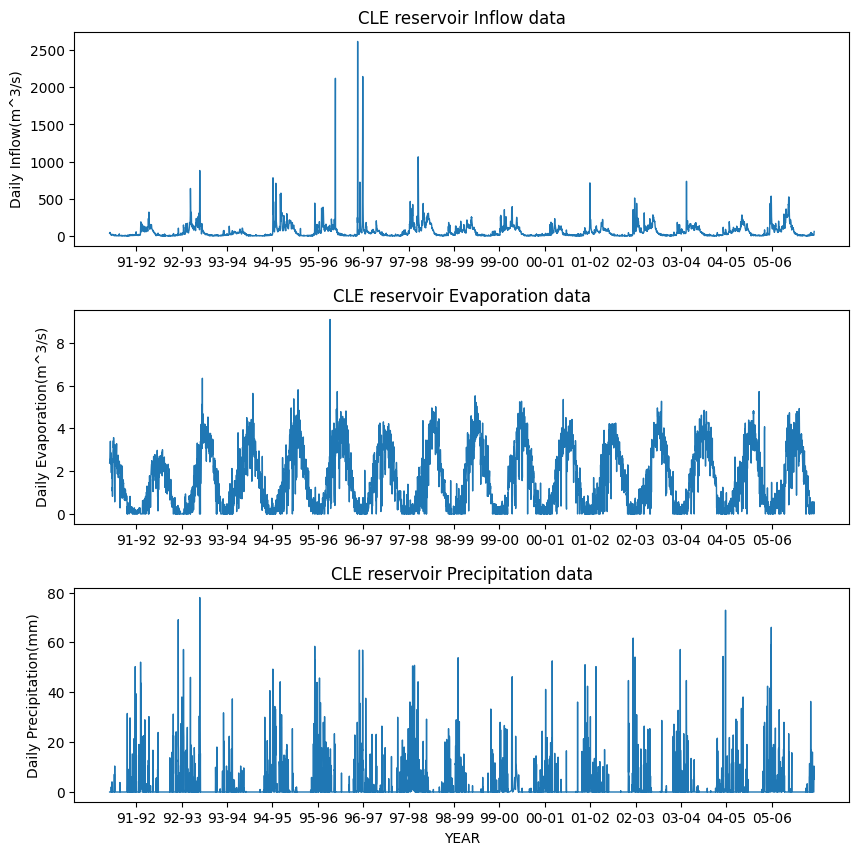

In [26]:
a = list(cle_inflow['VALUE'])
b = list(cle_evaporation['VALUE'])
c = list(cle_precipitation['VALUE'])
fig,ax =  plt.subplots(3,1,figsize=(10,10))
plt.setp(ax, xticks=[ 215,  580,  945, 1310, 1675, 2040, 2405, 2770, 3135, 3500, 3865, 4230, 4595, 4960, 5325],
         xticklabels=['91-92','92-93','93-94','94-95','95-96','96-97','97-98','98-99','99-00','00-01','01-02','02-03','03-04','04-05','05-06'])
ax[0].plot(a,linewidth=1)
ax[0].set_title('CLE reservoir Inflow data')
ax[0].set_ylabel('Daily Inflow(m^3/s)')
ax[1].plot(b,linewidth=1)
ax[1].set_title('CLE reservoir Evaporation data')
ax[1].set_ylabel('Daily Evaporation(m^3/s)')
ax[2].plot(c,linewidth=1)
ax[2].set_title('CLE reservoir Precipitation data')
ax[2].set_ylabel('Daily Precipitation(mm)')
plt.xlabel('YEAR')
fig.subplots_adjust(wspace=0.1, hspace=0.3)
plt.savefig("CLE.png")
plt.show()

In [27]:
cle = pd.DataFrame({'inflow':a,'evaporation':b,'precipitation':c})
cle.to_csv('cle.csv')

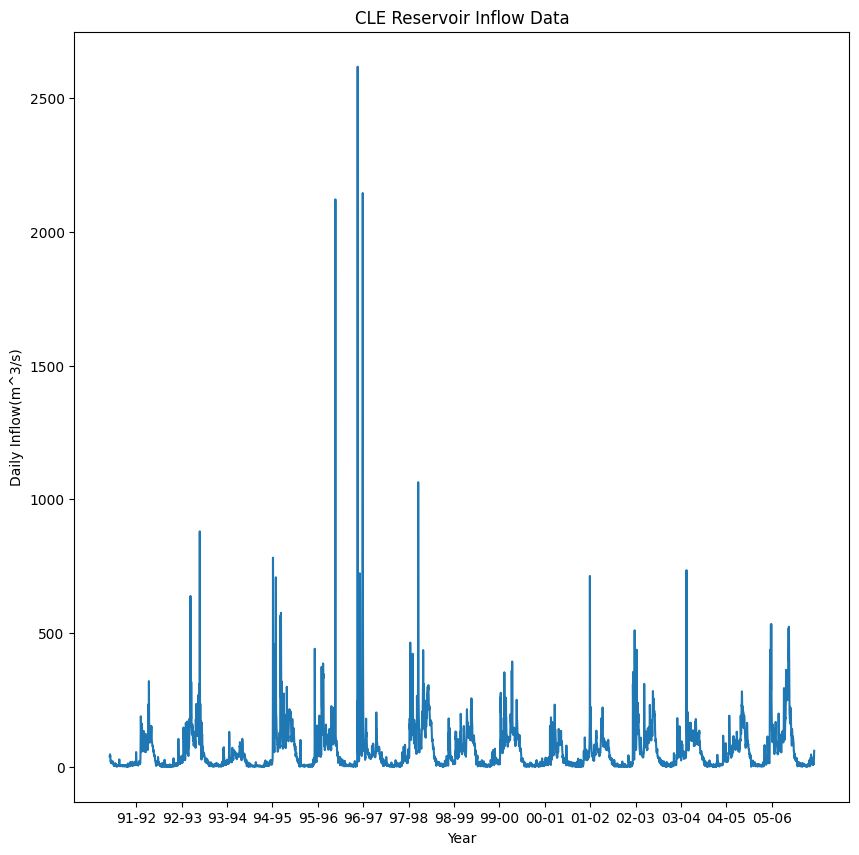

In [28]:
a= list(cle_inflow['VALUE'])
plt.figure(figsize=(10,10))
plt.plot(a)
plt.ylabel('Daily Inflow(m^3/s)')
plt.xlabel('Year')
plt.title('CLE Reservoir Inflow Data')
plt.xticks([ 215,  580,  945, 1310, 1675, 2040, 2405, 2770, 3135, 3500, 3865, 4230, 4595, 4960, 5325],['91-92','92-93','93-94','94-95','95-96','96-97','97-98','98-99','99-00','00-01','01-02','02-03','03-04','04-05','05-06'])
plt.show()

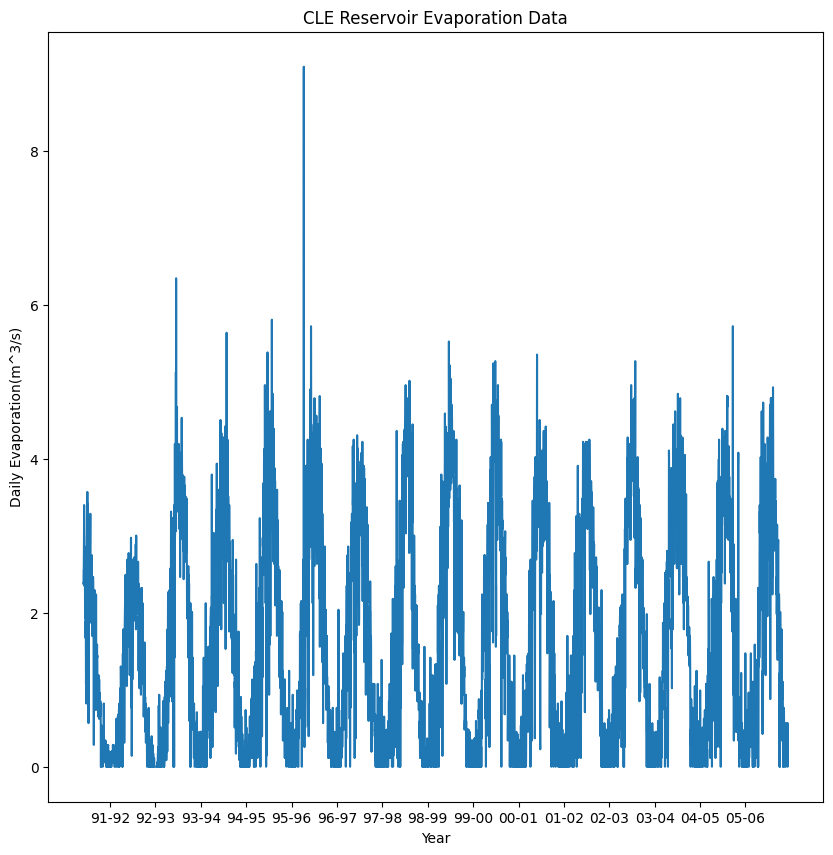

In [29]:
a= list(cle_evaporation['VALUE'])
plt.figure(figsize=(10,10))
plt.plot(a)
plt.ylabel('Daily Evaporation(m^3/s)')
plt.xlabel('Year')
plt.title('CLE Reservoir Evaporation Data')
plt.xticks([ 215,  580,  945, 1310, 1675, 2040, 2405, 2770, 3135, 3500, 3865, 4230, 4595, 4960, 5325],['91-92','92-93','93-94','94-95','95-96','96-97','97-98','98-99','99-00','00-01','01-02','02-03','03-04','04-05','05-06'])
plt.show()

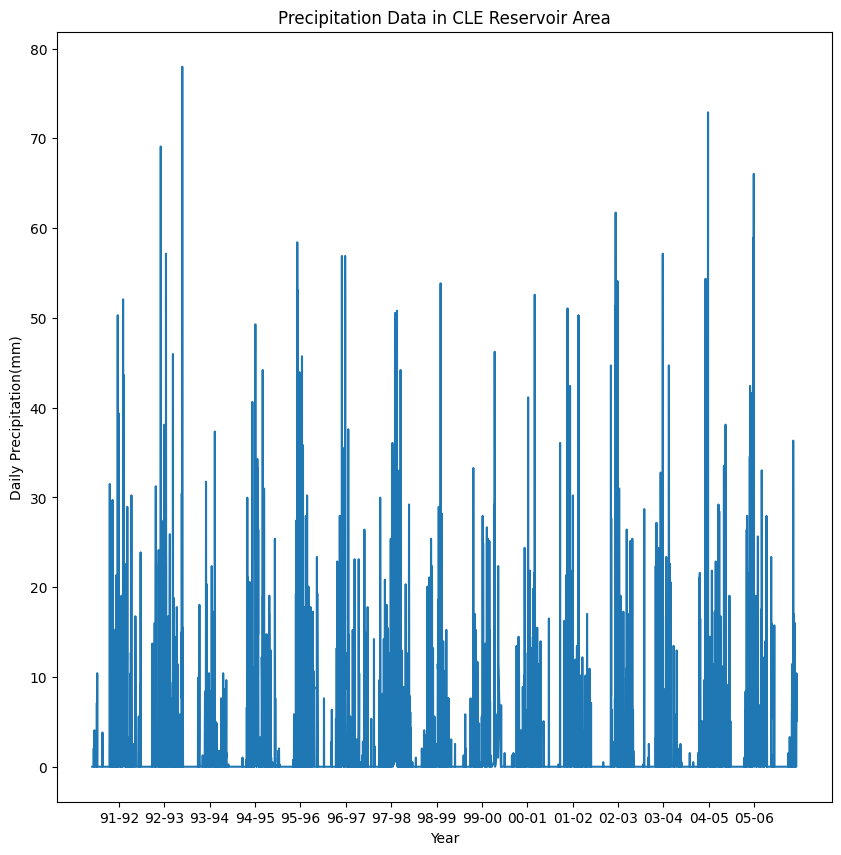

In [30]:
a= list(cle_precipitation['VALUE'])
plt.figure(figsize=(10,10))
plt.plot(a)
plt.ylabel('Daily Precipitation(mm)')
plt.xlabel('Year')
plt.title('Precipitation Data in CLE Reservoir Area')
plt.xticks([ 215,  580,  945, 1310, 1675, 2040, 2405, 2770, 3135, 3500, 3865, 4230, 4595, 4960, 5325],['91-92','92-93','93-94','94-95','95-96','96-97','97-98','98-99','99-00','00-01','01-02','02-03','03-04','04-05','05-06'])
plt.show()

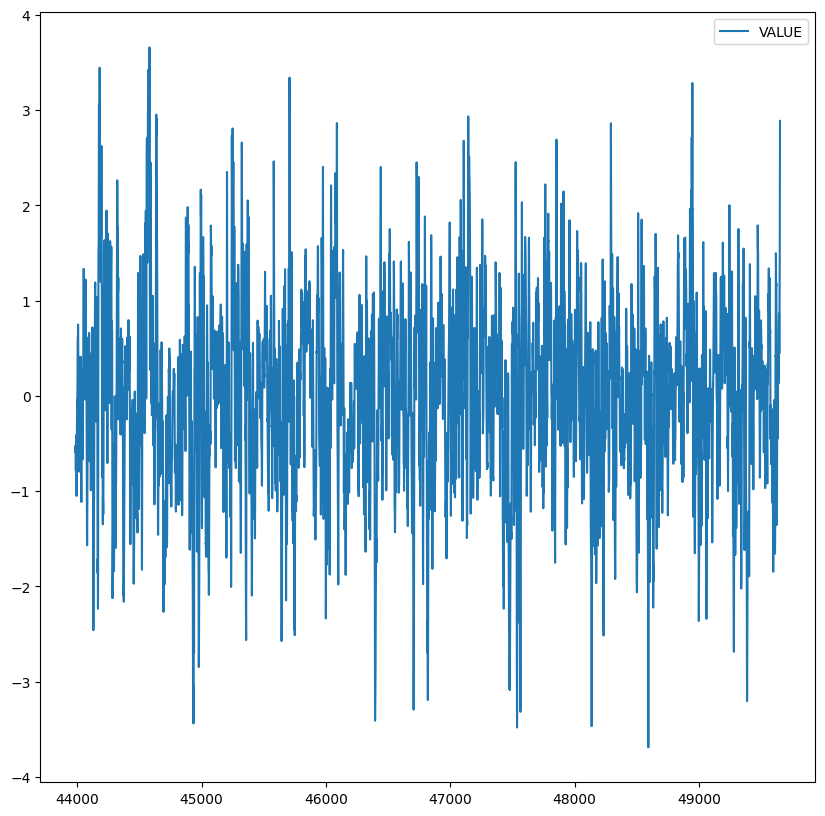

In [31]:
ao.plot(figsize=(10,10))
plt.show()

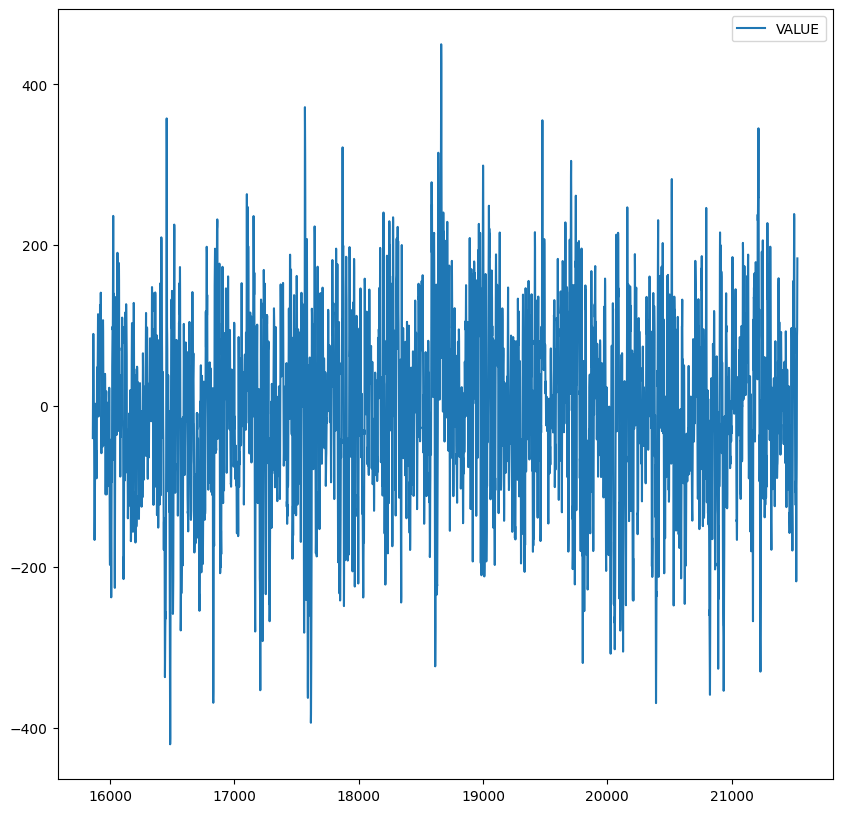

In [32]:
epo.plot(figsize=(10,10))
plt.show()

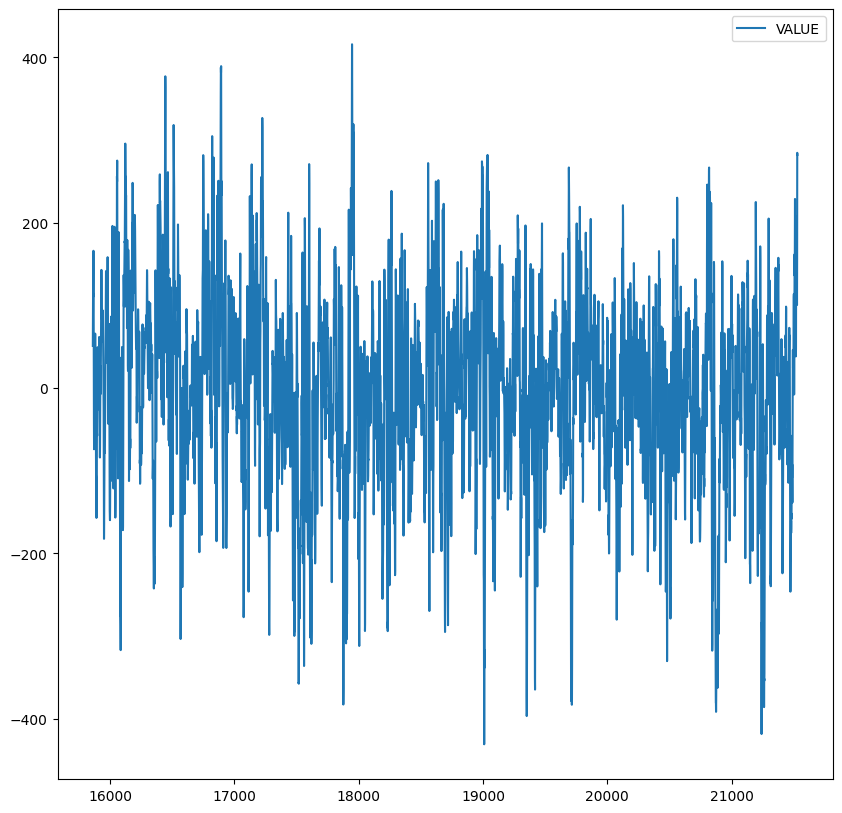

In [33]:
nao.plot(figsize=(10,10))
plt.show()

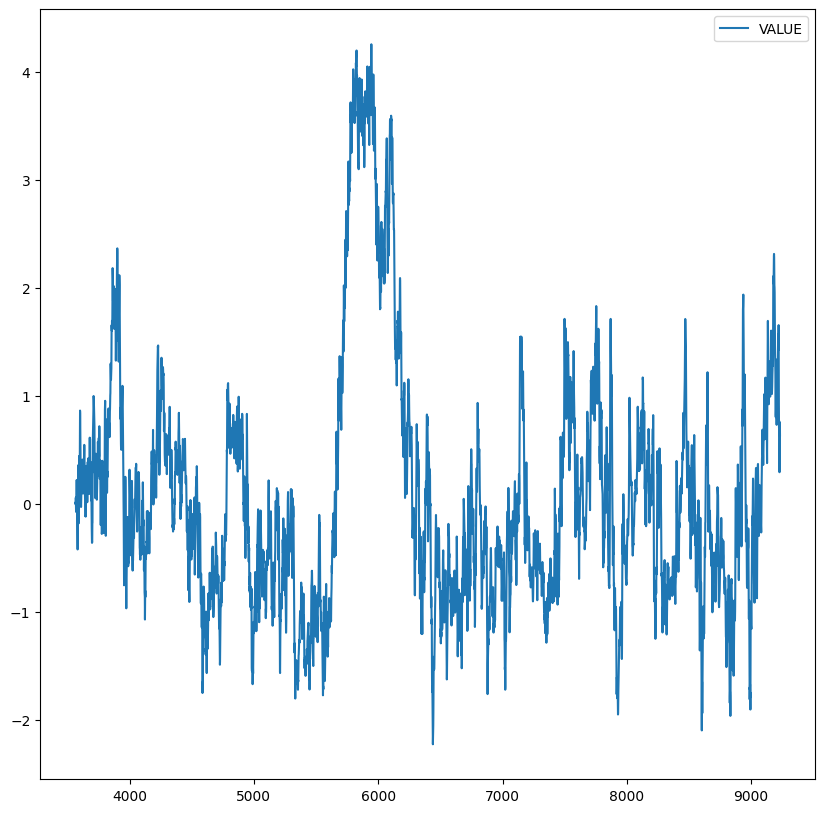

In [34]:
nino12.plot(figsize=(10,10))
plt.show()

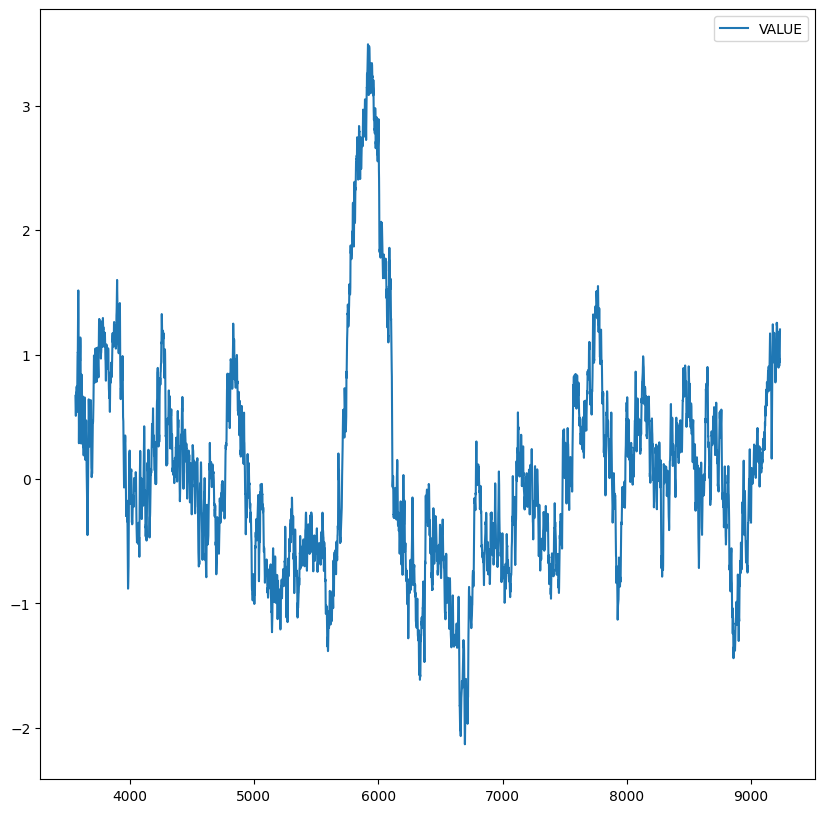

In [35]:
nino3.plot(figsize=(10,10))
plt.show()

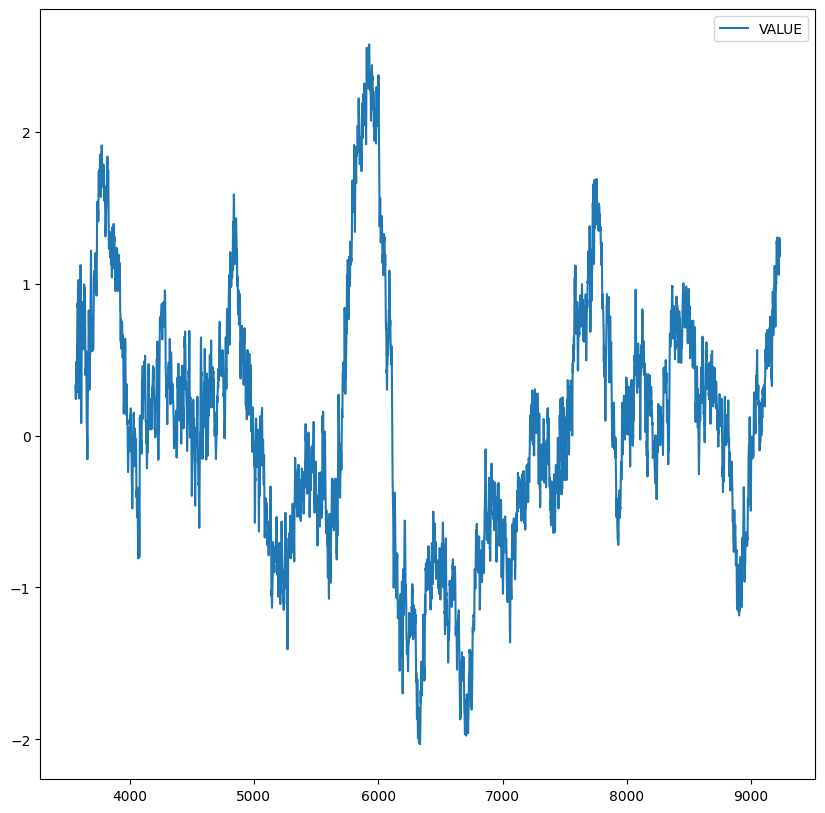

In [36]:
nino34.plot(figsize=(10,10))
plt.show()

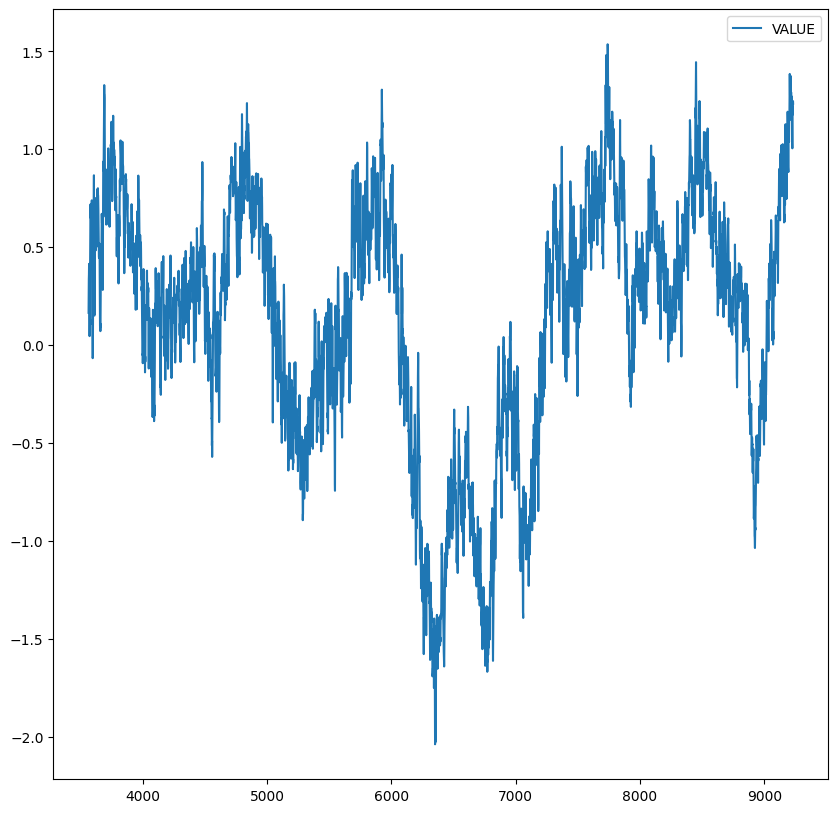

In [37]:
nino4.plot(figsize=(10,10))
plt.show()

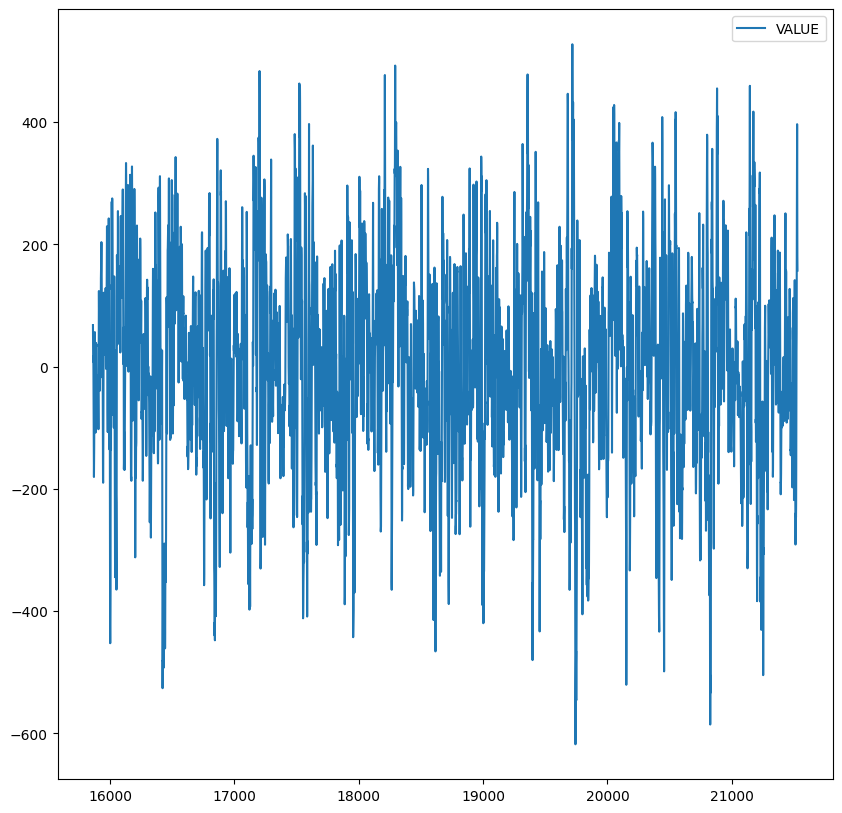

In [38]:
pna.plot(figsize=(10,10))
plt.show()

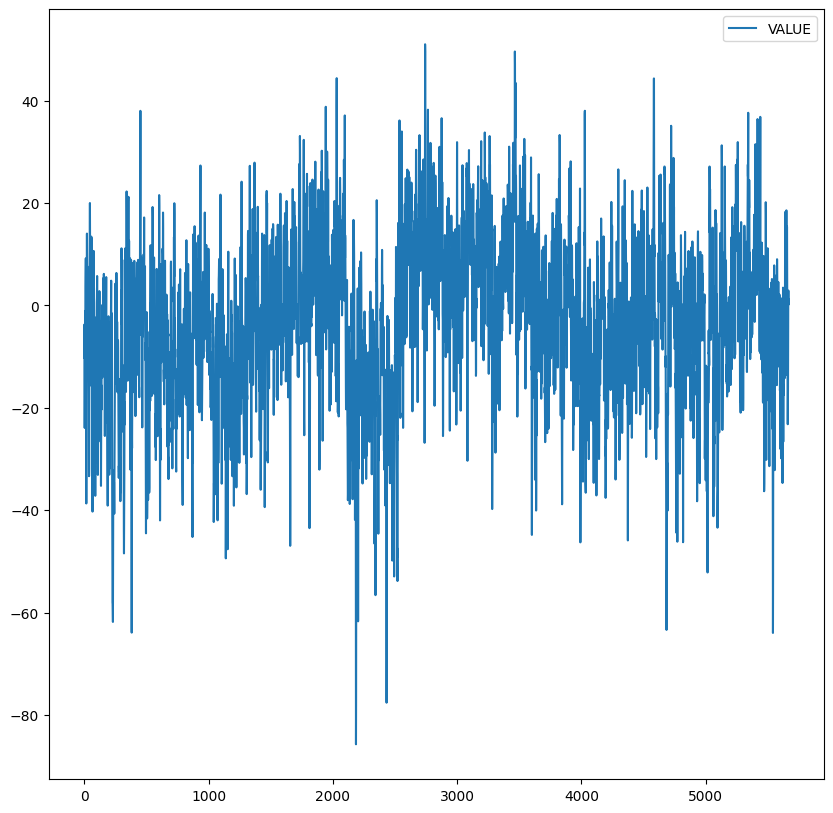

In [39]:
soi.plot(figsize=(10,10))
plt.show()

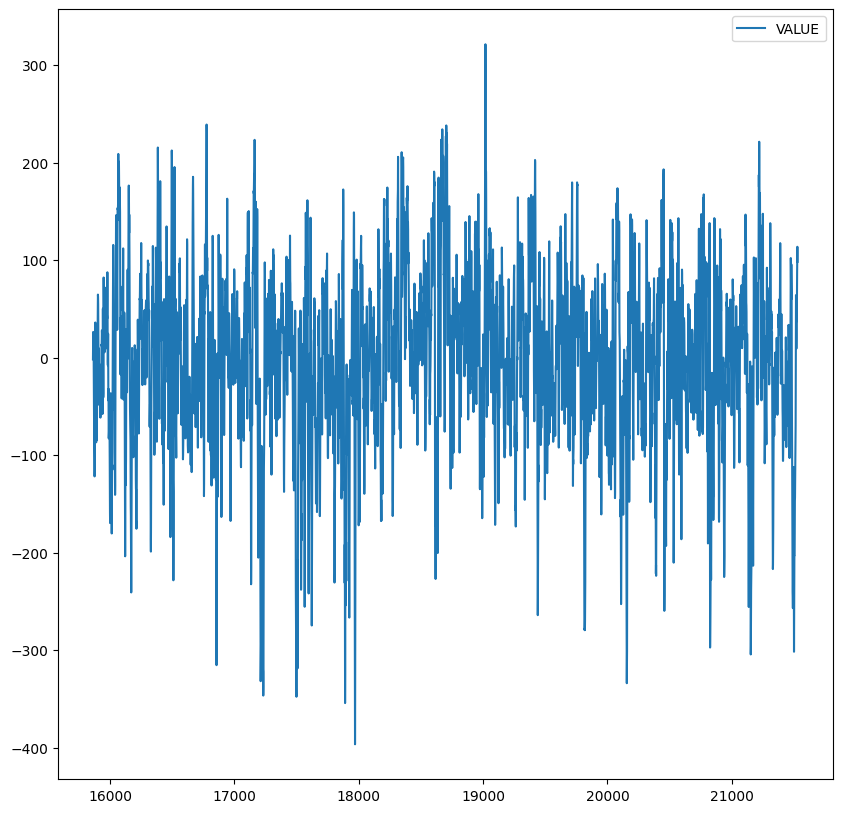

In [40]:
wpo.plot(figsize=(10,10))
plt.show()

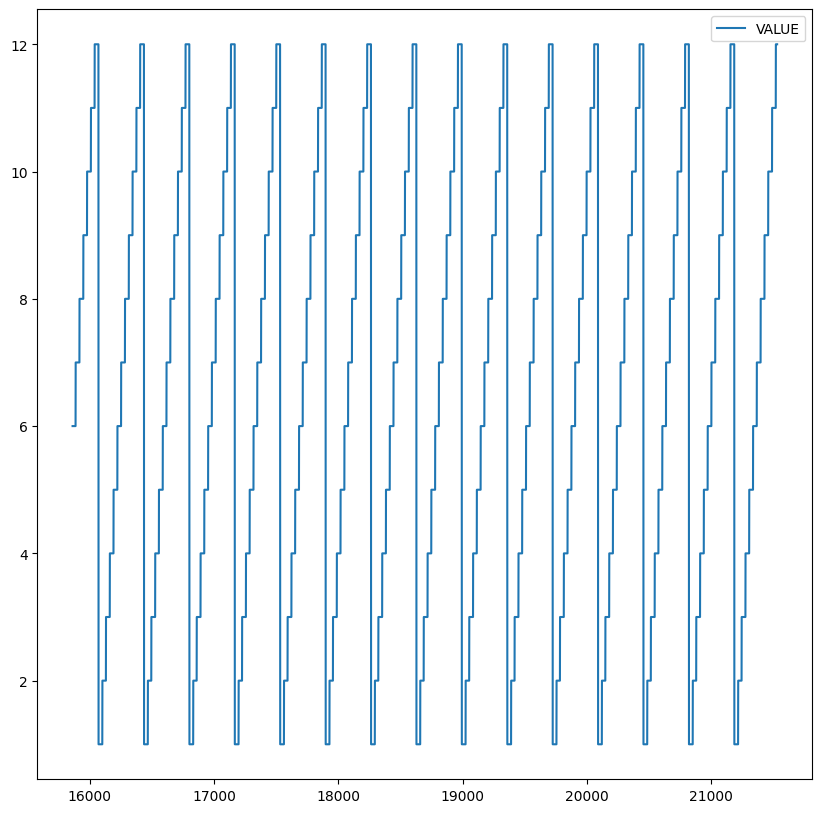

In [41]:
seasonality.plot(figsize=(10,10))
plt.show()

##Checking Autocorrelation

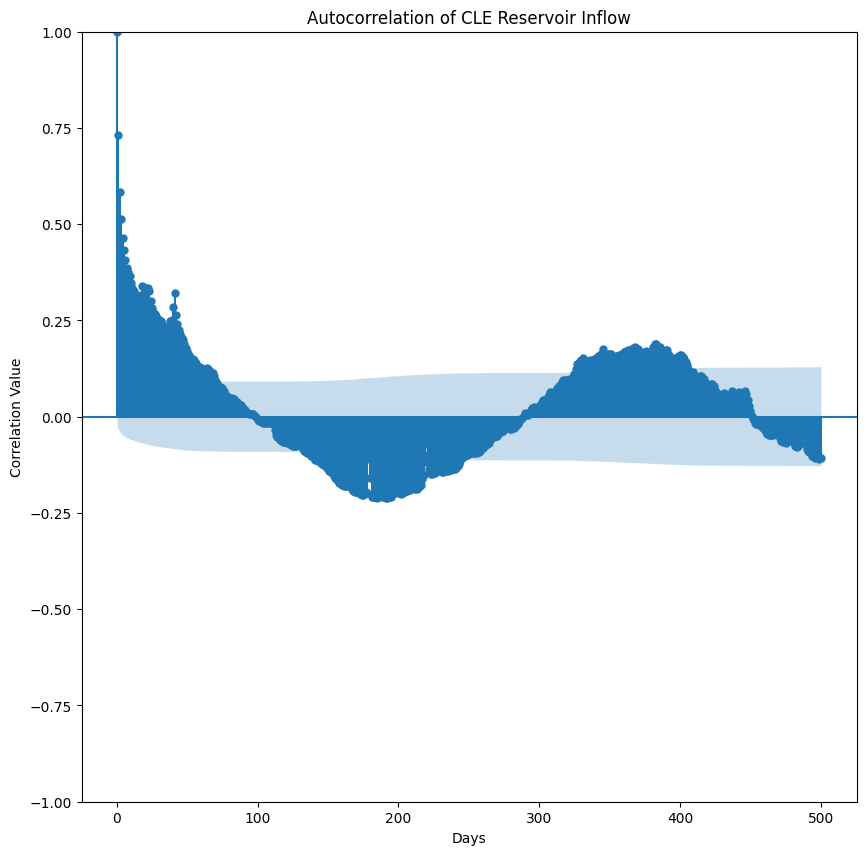

In [42]:
with mp.rc_context():
  mp.rc("figure",figsize=(10,10))
  plot_acf(cle_inflow,lags=500)
  plt.title('Autocorrelation of CLE Reservoir Inflow')
  plt.ylabel('Correlation Value')
  plt.xlabel('Days')
  plt.show()

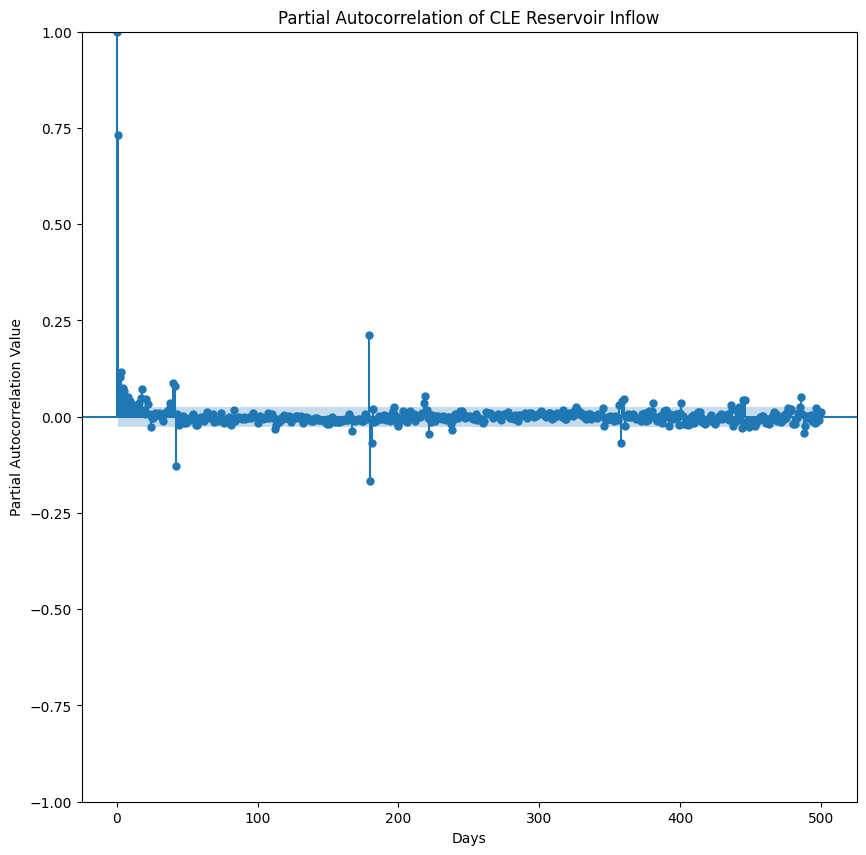

In [43]:
with mp.rc_context():
  mp.rc("figure",figsize=(10,10))
  plot_pacf(cle_inflow,lags=500)
  plt.title('Partial Autocorrelation of CLE Reservoir Inflow')
  plt.ylabel('Partial Autocorrelation Value')
  plt.xlabel('Days')
  plt.show()

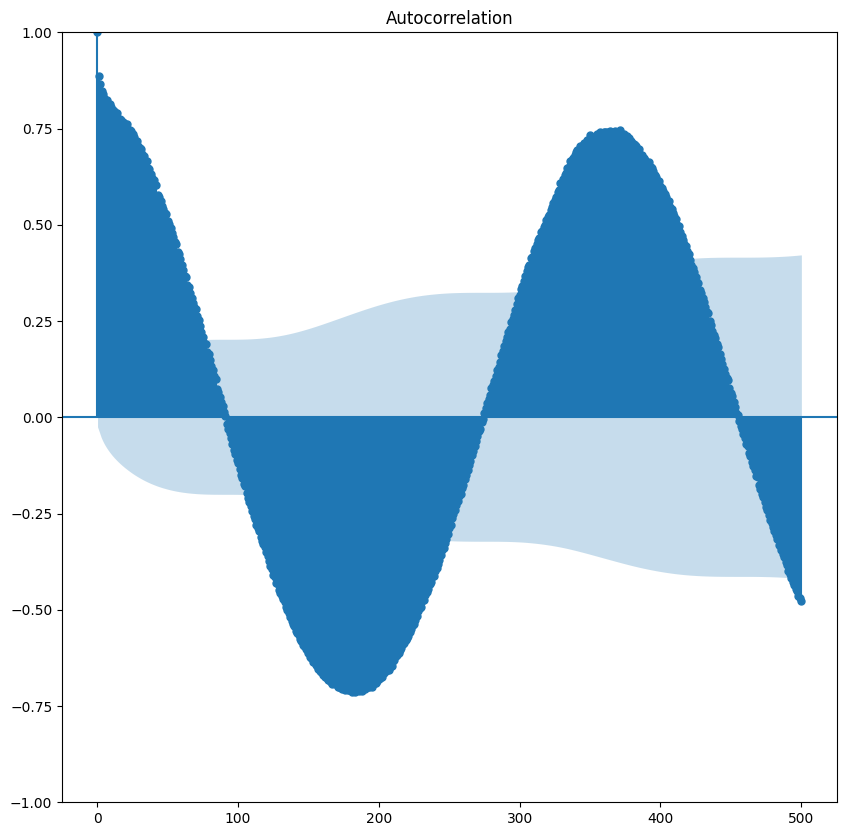

In [44]:
with mp.rc_context():
  mp.rc("figure",figsize=(10,10))
  plot_acf(cle_evaporation,lags=500)
  plt.show()

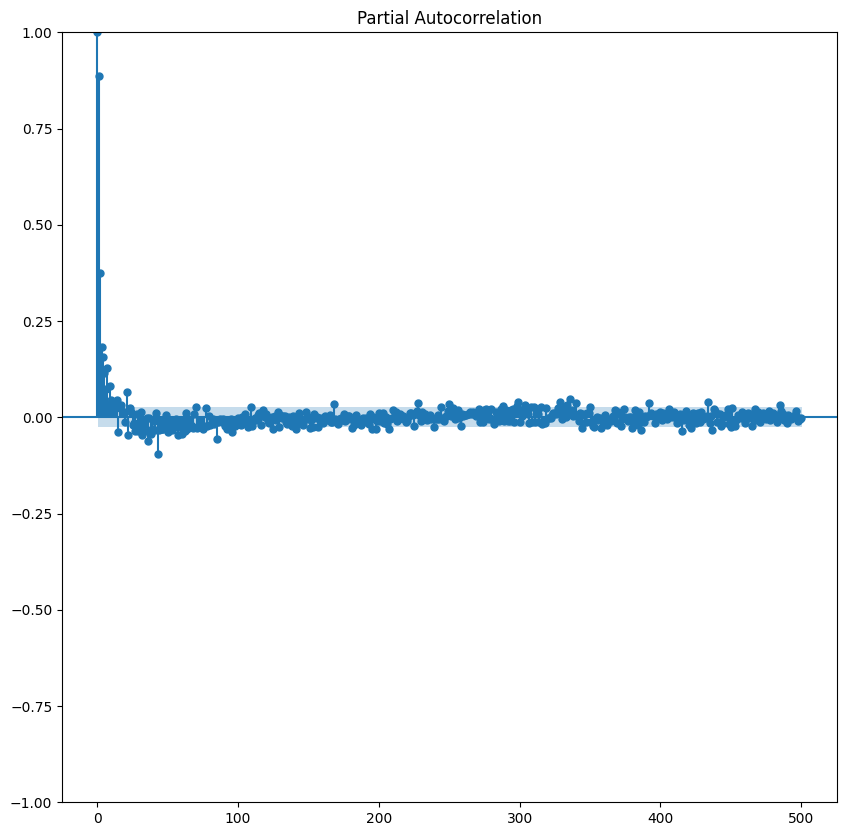

In [45]:
with mp.rc_context():
  mp.rc("figure",figsize=(10,10))
  plot_pacf(cle_evaporation,lags=500)
  plt.show()

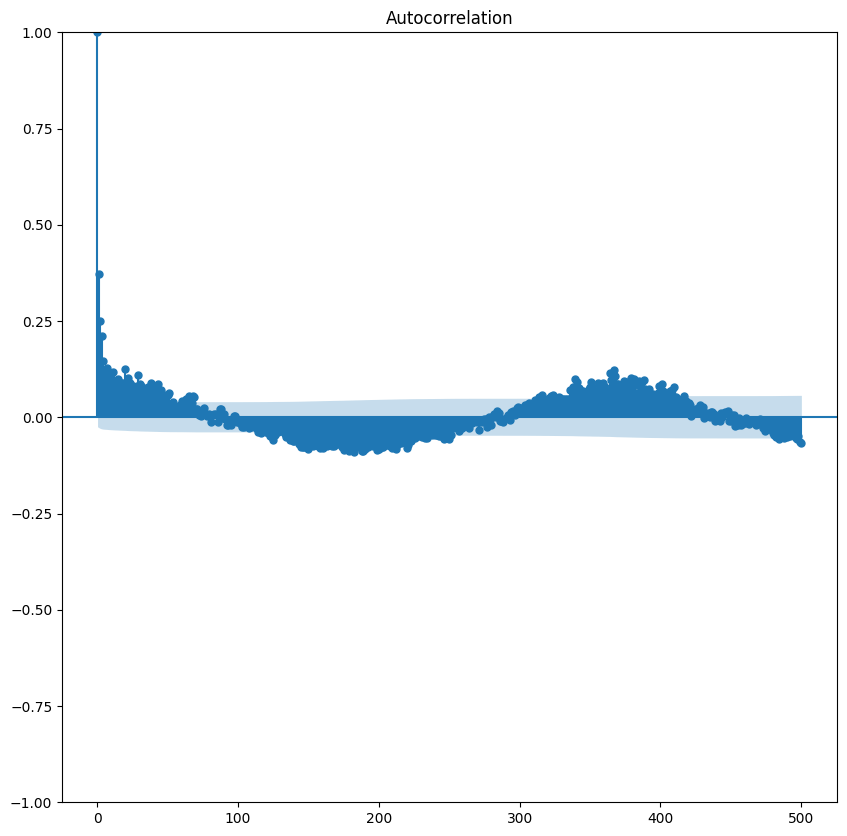

In [46]:
with mp.rc_context():
  mp.rc("figure",figsize=(10,10))
  plot_acf(cle_precipitation,lags=500)
  plt.show()

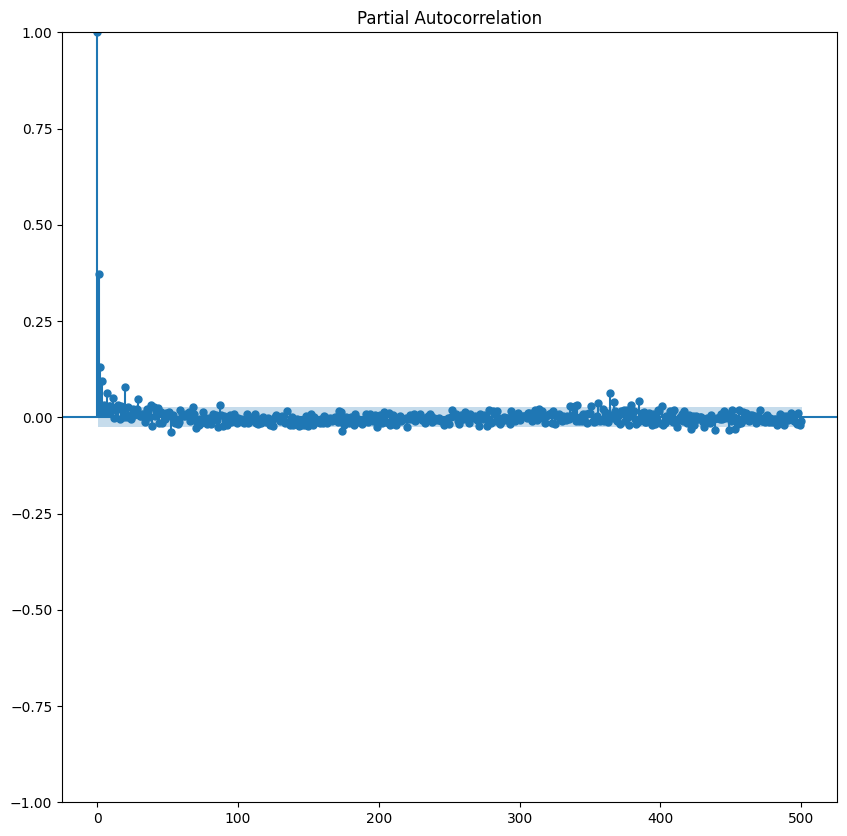

In [47]:
with mp.rc_context():
  mp.rc("figure",figsize=(10,10))
  plot_pacf(cle_precipitation,lags=500)
  plt.show()

##Preparaing Lagged Dataset

In [48]:
ao_lag = pd.DataFrame()
for i in range(179,0,-1):
	ao_lag['ao_t-'+str(i)] = ao.shift(i).values[:,0]
ao_lag['ao_t'] = ao.values[:,0]
ao_lag = ao_lag[180:]

/tmp/ipykernel_559318/2510020110.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ao_lag['ao_t-'+str(i)] = ao.shift(i).values[:,0]
/tmp/ipykernel_559318/2510020110.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ao_lag['ao_t-'+str(i)] = ao.shift(i).values[:,0]
/tmp/ipykernel_559318/2510020110.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

In [49]:
epo_lag = pd.DataFrame()
for i in range(179,0,-1):
	epo_lag['epo_t-'+str(i)] = epo.shift(i).values[:,0]
epo_lag['epo_t'] = epo.values[:,0]
epo_lag = epo_lag[180:]

/tmp/ipykernel_559318/3027694287.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  epo_lag['epo_t-'+str(i)] = epo.shift(i).values[:,0]
/tmp/ipykernel_559318/3027694287.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  epo_lag['epo_t-'+str(i)] = epo.shift(i).values[:,0]
/tmp/ipykernel_559318/3027694287.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To g

In [50]:
nao_lag = pd.DataFrame()
for i in range(179,0,-1):
	nao_lag['nao_t-'+str(i)] = nao.shift(i).values[:,0]
nao_lag['nao_t'] = nao.values[:,0]
nao_lag = nao_lag[180:]

/tmp/ipykernel_559318/3414129057.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  nao_lag['nao_t-'+str(i)] = nao.shift(i).values[:,0]
/tmp/ipykernel_559318/3414129057.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  nao_lag['nao_t-'+str(i)] = nao.shift(i).values[:,0]
/tmp/ipykernel_559318/3414129057.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To g

In [51]:
nino12_lag = pd.DataFrame()
for i in range(179,0,-1):
	nino12_lag['nino12_t-'+str(i)] = nino12.shift(i).values[:,0]
nino12_lag['nino12_t'] = nino12.values[:,0]
nino12_lag = nino12_lag[180:]

/tmp/ipykernel_559318/2494203650.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  nino12_lag['nino12_t-'+str(i)] = nino12.shift(i).values[:,0]
/tmp/ipykernel_559318/2494203650.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  nino12_lag['nino12_t-'+str(i)] = nino12.shift(i).values[:,0]
/tmp/ipykernel_559318/2494203650.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axi

In [52]:
nino3_lag = pd.DataFrame()
for i in range(179,0,-1):
	nino3_lag['nino3_t-'+str(i)] = nino3.shift(i).values[:,0]
nino3_lag['nino3_t'] = nino3.values[:,0]
nino3_lag = nino3_lag[180:]

/tmp/ipykernel_559318/184534040.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  nino3_lag['nino3_t-'+str(i)] = nino3.shift(i).values[:,0]
/tmp/ipykernel_559318/184534040.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  nino3_lag['nino3_t-'+str(i)] = nino3.shift(i).values[:,0]
/tmp/ipykernel_559318/184534040.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) inst

In [53]:
nino34_lag = pd.DataFrame()
for i in range(179,0,-1):
	nino34_lag['nino34_t-'+str(i)] = nino34.shift(i).values[:,0]
nino34_lag['nino34_t'] = nino34.values[:,0]
nino34_lag = nino34_lag[180:]

/tmp/ipykernel_559318/3503870706.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  nino34_lag['nino34_t-'+str(i)] = nino34.shift(i).values[:,0]
/tmp/ipykernel_559318/3503870706.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  nino34_lag['nino34_t-'+str(i)] = nino34.shift(i).values[:,0]
/tmp/ipykernel_559318/3503870706.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axi

In [54]:
nino4_lag = pd.DataFrame()
for i in range(179,0,-1):
	nino4_lag['nino4_t-'+str(i)] = nino4.shift(i).values[:,0]
nino4_lag['nino4_t'] = nino4.values[:,0]
nino4_lag = nino4_lag[180:]

/tmp/ipykernel_559318/2684406603.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  nino4_lag['nino4_t-'+str(i)] = nino4.shift(i).values[:,0]
/tmp/ipykernel_559318/2684406603.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  nino4_lag['nino4_t-'+str(i)] = nino4.shift(i).values[:,0]
/tmp/ipykernel_559318/2684406603.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) i

In [55]:
pna_lag = pd.DataFrame()
for i in range(179,0,-1):
	pna_lag['pna_t-'+str(i)] = pna.shift(i).values[:,0]
pna_lag['pna_t'] = pna.values[:,0]
pna_lag = pna_lag[180:]

/tmp/ipykernel_559318/704568641.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  pna_lag['pna_t-'+str(i)] = pna.shift(i).values[:,0]
/tmp/ipykernel_559318/704568641.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  pna_lag['pna_t-'+str(i)] = pna.shift(i).values[:,0]
/tmp/ipykernel_559318/704568641.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get 

In [56]:
soi_lag = pd.DataFrame()
for i in range(179,0,-1):
	soi_lag['soi_t-'+str(i)] = soi.shift(i).values[:,0]
soi_lag['soi_t'] = soi.values[:,0]
soi_lag = soi_lag[180:]

/tmp/ipykernel_559318/20559637.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  soi_lag['soi_t-'+str(i)] = soi.shift(i).values[:,0]
/tmp/ipykernel_559318/20559637.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  soi_lag['soi_t-'+str(i)] = soi.shift(i).values[:,0]
/tmp/ipykernel_559318/20559637.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

In [57]:
wpo_lag = pd.DataFrame()
for i in range(179,0,-1):
	wpo_lag['wpo_t-'+str(i)] = wpo.shift(i).values[:,0]
wpo_lag['wpo_t'] = wpo.values[:,0]
wpo_lag = wpo_lag[180:]

/tmp/ipykernel_559318/3607610618.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  wpo_lag['wpo_t-'+str(i)] = wpo.shift(i).values[:,0]
/tmp/ipykernel_559318/3607610618.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  wpo_lag['wpo_t-'+str(i)] = wpo.shift(i).values[:,0]
/tmp/ipykernel_559318/3607610618.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To g

In [58]:
seasonality_lag = pd.DataFrame()
for i in range(179,0,-1):
	seasonality_lag['seasonality_t-'+str(i)] = seasonality.shift(i).values[:,0]
seasonality_lag['seasonality_t'] = seasonality.values[:,0]
seasonality_lag = seasonality_lag[180:]

/tmp/ipykernel_559318/3764693145.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  seasonality_lag['seasonality_t-'+str(i)] = seasonality.shift(i).values[:,0]
/tmp/ipykernel_559318/3764693145.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  seasonality_lag['seasonality_t-'+str(i)] = seasonality.shift(i).values[:,0]
/tmp/ipykernel_559318/3764693145.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all colum

In [59]:
cle_evaporation_lag = pd.DataFrame()
for i in range(179,0,-1):
	cle_evaporation_lag['evaporation_t-'+str(i)] = cle_evaporation.shift(i).values[:,0]
cle_evaporation_lag['evaporation_t'] = cle_evaporation.values[:,0]
cle_evaporation_lag = cle_evaporation_lag[180:]

/tmp/ipykernel_559318/3373247061.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  cle_evaporation_lag['evaporation_t-'+str(i)] = cle_evaporation.shift(i).values[:,0]
/tmp/ipykernel_559318/3373247061.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  cle_evaporation_lag['evaporation_t-'+str(i)] = cle_evaporation.shift(i).values[:,0]
/tmp/ipykernel_559318/3373247061.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider j

In [60]:
cle_precipitation_lag = pd.DataFrame()
for i in range(179,0,-1):
	cle_precipitation_lag['precipitation_t-'+str(i)] = cle_precipitation.shift(i).values[:,0]
cle_precipitation_lag['precipitation_t'] = cle_precipitation.values[:,0]
cle_precipitation_lag = cle_precipitation_lag[180:]

/tmp/ipykernel_559318/4033409855.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  cle_precipitation_lag['precipitation_t-'+str(i)] = cle_precipitation.shift(i).values[:,0]
/tmp/ipykernel_559318/4033409855.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  cle_precipitation_lag['precipitation_t-'+str(i)] = cle_precipitation.shift(i).values[:,0]
/tmp/ipykernel_559318/4033409855.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.

In [61]:
cle_inflow_lag = pd.DataFrame()
inflow = pd.DataFrame()
for i in range(179,0,-1):
	cle_inflow_lag['inflow_t-'+str(i)] = cle_inflow.shift(i).values[:,0]
inflow['VALUE'] = cle_inflow.values[:,0]
cle_inflow_lag = cle_inflow_lag[180:]
inflow = inflow[180:]

/tmp/ipykernel_559318/840509823.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  cle_inflow_lag['inflow_t-'+str(i)] = cle_inflow.shift(i).values[:,0]
/tmp/ipykernel_559318/840509823.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  cle_inflow_lag['inflow_t-'+str(i)] = cle_inflow.shift(i).values[:,0]
/tmp/ipykernel_559318/840509823.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using 

##Formatting Dataset

In [62]:
df_list = [ao_lag,epo_lag,nao_lag,nino12_lag,nino3_lag,nino34_lag,nino4_lag,pna_lag,soi_lag,wpo_lag,seasonality_lag,cle_evaporation_lag,cle_precipitation_lag,cle_inflow_lag]
X = pd.concat(df_list,axis=1)
y = inflow.copy()

##StandardScaler

In [63]:
scaler = StandardScaler()
X_scaler = scaler.fit_transform(X)

##Principal Component Analysis

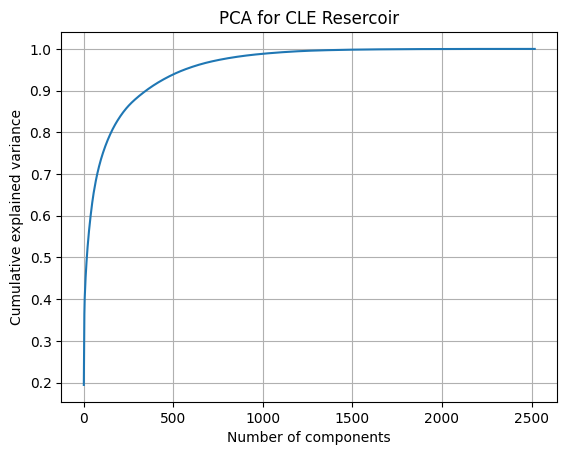

In [64]:
pca = PCA().fit(X_scaler)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.title('PCA for CLE Resercoir')
plt.grid()
plt.show()

##Number of Components taken 500 considering these 500 contans almost 95% variance

In [65]:
pca = PCA(n_components=500)
X_pca = pca.fit_transform(X_scaler)

In [66]:
def correlation(s, o):
    if s.size == 0:
        corr = np.NaN
    else:
        corr = np.corrcoef(o, s)[0,1]
    return corr

In [67]:
def NS(s, o):
    return 1 - np.sum((s-o)**2)/np.sum((o-np.mean(o))**2)

In [68]:
def KGE(s, o):
    cc = correlation(s,o)
    alpha = np.std(s)/np.std(o)
    beta = np.sum(s)/np.sum(o)
    kge = 1- np.sqrt( (cc-1)**2 + (alpha-1)**2 + (beta-1)**2 )
    return kge

In [69]:
from scipy.stats import pearsonr
def CORR(s,o):
  corr, _ = pearsonr(test,preds)
  return corr

In [70]:
def Absolute_Percentage_Error(s,o):
  return (np.sum(np.abs(s-o))/np.sum(o))*100

##Random Forest

In [71]:
from sklearn.ensemble import RandomForestRegressor

**n_estimators = 500 min_samples = 29**

In [72]:
rf = RandomForestRegressor(n_estimators=500,n_jobs=-1,min_samples_leaf=29,max_features='sqrt')
kf = KFold(n_splits=15,shuffle=False)
rmse_rf_100_29 = []
corr_rf_100_29 = []
r2_rf_100_29 = []
mae_rf_100_29 = []
apb_rf_100_29 = []
p_rf_500_29 = []
r_rf_500_29 = []
for train_index, test_index in tqdm(kf.split(X_pca),total=kf.get_n_splits(),desc="k-fold"):
    X_train, X_test, y_train, y_test = X_pca[train_index], X_pca[test_index], y.iloc[train_index], y.iloc[test_index]
    y_train = np.array(y_train).ravel()
    rf.fit(X_train, y_train)
    y_list_pred = list(rf.predict(X_test))
    y_pred = np.array(y_list_pred)
    y_real_list = list(y_test['VALUE'])
    y_real = np.array(y_real_list)
    p_rf_500_29.extend(y_list_pred)
    r_rf_500_29.extend(y_real_list)
    rmse_rf_100_29.append(math.sqrt(mean_squared_error(y_real,y_pred)))
    corr_rf_100_29.append(correlation(y_real,y_pred))
    r2_rf_100_29.append(r2_score(y_real,y_pred))
    mae_rf_100_29.append(mean_absolute_error(y_real,y_pred))
    apb_rf_100_29.append(Absolute_Percentage_Error(y_real,y_pred))

k-fold: 100%|██████████| 15/15 [01:58<00:00,  7.93s/it]


In [73]:
print('RMSE ',mean(rmse_rf_100_29))
print('CORR ',mean(corr_rf_100_29))
print('R2 ',mean(r2_rf_100_29))
print('MAE ',mean(mae_rf_100_29))
print('APB ',mean(apb_rf_100_29))

RMSE  76.4102473209717
CORR  0.6227392355277848
R2  0.12672778861395007
MAE  42.95577083406757
APB  65.8640997217481


**n_estimators = 500* min_samples_leaf = 31**

In [74]:
rf = RandomForestRegressor(n_estimators=500,n_jobs=-1,min_samples_leaf=31,max_features='sqrt')
kf = KFold(n_splits=15,shuffle=False)
rmse_rf_100_29 = []
corr_rf_100_29 = []
r2_rf_100_29 = []
mae_rf_100_29 = []
apb_rf_100_29 = []
p_rf_500_31 = []
r_rf_500_31 = []
for train_index, test_index in tqdm(kf.split(X_pca),total=kf.get_n_splits(),desc="k-fold"):
    X_train, X_test, y_train, y_test = X_pca[train_index], X_pca[test_index], y.iloc[train_index], y.iloc[test_index]
    y_train = np.array(y_train).ravel()
    rf.fit(X_train, y_train)
    y_list_pred = list(rf.predict(X_test))
    y_pred = np.array(y_list_pred)
    y_real_list = list(y_test['VALUE'])
    y_real = np.array(y_real_list)
    p_rf_500_31.extend(y_list_pred)
    r_rf_500_31.extend(y_real_list)
    rmse_rf_100_29.append(math.sqrt(mean_squared_error(y_real,y_pred)))
    corr_rf_100_29.append(correlation(y_real,y_pred))
    r2_rf_100_29.append(r2_score(y_real,y_pred))
    mae_rf_100_29.append(mean_absolute_error(y_real,y_pred))
    apb_rf_100_29.append(Absolute_Percentage_Error(y_real,y_pred))

k-fold: 100%|██████████| 15/15 [02:01<00:00,  8.13s/it]


In [75]:
print('RMSE ',mean(rmse_rf_100_29))
print('CORR ',mean(corr_rf_100_29))
print('R2 ',mean(r2_rf_100_29))
print('MAE ',mean(mae_rf_100_29))
print('APB ',mean(apb_rf_100_29))

RMSE  76.48541529065533
CORR  0.623168713805703
R2  0.1289373207480561
MAE  42.93945165792416
APB  66.07769006155723


**n_estimators = 600 min_samples_leaf = 29**

In [76]:
rf = RandomForestRegressor(n_estimators=600,n_jobs=-1,min_samples_leaf=29,max_features='sqrt')
kf = KFold(n_splits=15,shuffle=False)
rmse_rf_100_29 = []
corr_rf_100_29 = []
r2_rf_100_29 = []
mae_rf_100_29 = []
apb_rf_100_29 = []
p_rf_600_29 = []
r_rf_600_29 = []
for train_index, test_index in tqdm(kf.split(X_pca),total=kf.get_n_splits(),desc="k-fold"):
    X_train, X_test, y_train, y_test = X_pca[train_index], X_pca[test_index], y.iloc[train_index], y.iloc[test_index]
    y_train = np.array(y_train).ravel()
    rf.fit(X_train, y_train)
    y_list_pred = list(rf.predict(X_test))
    y_pred = np.array(y_list_pred)
    y_real_list = list(y_test['VALUE'])
    y_real = np.array(y_real_list)
    p_rf_600_29.extend(y_list_pred)
    r_rf_600_29.extend(y_real_list)
    rmse_rf_100_29.append(math.sqrt(mean_squared_error(y_real,y_pred)))
    corr_rf_100_29.append(correlation(y_real,y_pred))
    r2_rf_100_29.append(r2_score(y_real,y_pred))
    mae_rf_100_29.append(mean_absolute_error(y_real,y_pred))
    apb_rf_100_29.append(Absolute_Percentage_Error(y_real,y_pred))

k-fold: 100%|██████████| 15/15 [02:35<00:00, 10.36s/it]


In [77]:
print('RMSE ',mean(rmse_rf_100_29))
print('CORR ',mean(corr_rf_100_29))
print('R2 ',mean(r2_rf_100_29))
print('MAE ',mean(mae_rf_100_29))
print('APB ',mean(apb_rf_100_29))

RMSE  76.29195810249009
CORR  0.6234752432664026
R2  0.1381261963737074
MAE  42.79649487213973
APB  65.71214439113184


**n_estimators = 600 min_samples_leaf = 31**

In [78]:
rf = RandomForestRegressor(n_estimators=600,n_jobs=-1,min_samples_leaf=31,max_features='sqrt')
kf = KFold(n_splits=15,shuffle=False)
rmse_rf_100_29 = []
corr_rf_100_29 = []
r2_rf_100_29 = []
mae_rf_100_29 = []
apb_rf_100_29 = []
p_rf_600_31 = []
r_rf_600_31 = []
for train_index, test_index in tqdm(kf.split(X_pca),total=kf.get_n_splits(),desc="k-fold"):
    X_train, X_test, y_train, y_test = X_pca[train_index], X_pca[test_index], y.iloc[train_index], y.iloc[test_index]
    y_train = np.array(y_train).ravel()
    rf.fit(X_train, y_train)
    y_list_pred = list(rf.predict(X_test))
    y_pred = np.array(y_list_pred)
    y_real_list = list(y_test['VALUE'])
    y_real = np.array(y_real_list)
    p_rf_600_31.extend(y_list_pred)
    r_rf_600_31.extend(y_real_list)
    rmse_rf_100_29.append(math.sqrt(mean_squared_error(y_real,y_pred)))
    corr_rf_100_29.append(correlation(y_real,y_pred))
    r2_rf_100_29.append(r2_score(y_real,y_pred))
    mae_rf_100_29.append(mean_absolute_error(y_real,y_pred))
    apb_rf_100_29.append(Absolute_Percentage_Error(y_real,y_pred))

k-fold: 100%|██████████| 15/15 [02:33<00:00, 10.24s/it]


In [79]:
print('RMSE ',mean(rmse_rf_100_29))
print('CORR ',mean(corr_rf_100_29))
print('R2 ',mean(r2_rf_100_29))
print('MAE ',mean(mae_rf_100_29))
print('APB ',mean(apb_rf_100_29))

RMSE  76.26317490013957
CORR  0.6290650412737855
R2  0.13247483356993076
MAE  42.920694004566435
APB  66.00468720864369


**n_estimators = 700 min_samples_leaf = 29**

In [80]:
rf = RandomForestRegressor(n_estimators=700,n_jobs=-1,min_samples_leaf=29,max_features='sqrt')
kf = KFold(n_splits=15,shuffle=False)
rmse_rf_100_29 = []
corr_rf_100_29 = []
r2_rf_100_29 = []
mae_rf_100_29 = []
apb_rf_100_29 = []
p_rf_700_29 = []
r_rf_700_29 = []
for train_index, test_index in tqdm(kf.split(X_pca),total=kf.get_n_splits(),desc="k-fold"):
    X_train, X_test, y_train, y_test = X_pca[train_index], X_pca[test_index], y.iloc[train_index], y.iloc[test_index]
    y_train = np.array(y_train).ravel()
    rf.fit(X_train, y_train)
    y_list_pred = list(rf.predict(X_test))
    y_pred = np.array(y_list_pred)
    y_real_list = list(y_test['VALUE'])
    y_real = np.array(y_real_list)
    p_rf_700_29.extend(y_list_pred)
    r_rf_700_29.extend(y_real_list)
    rmse_rf_100_29.append(math.sqrt(mean_squared_error(y_real,y_pred)))
    corr_rf_100_29.append(correlation(y_real,y_pred))
    r2_rf_100_29.append(r2_score(y_real,y_pred))
    mae_rf_100_29.append(mean_absolute_error(y_real,y_pred))
    apb_rf_100_29.append(Absolute_Percentage_Error(y_real,y_pred))

k-fold: 100%|██████████| 15/15 [03:05<00:00, 12.34s/it]


In [81]:
print('RMSE ',mean(rmse_rf_100_29))
print('CORR ',mean(corr_rf_100_29))
print('R2 ',mean(r2_rf_100_29))
print('MAE ',mean(mae_rf_100_29))
print('APB ',mean(apb_rf_100_29))

RMSE  76.22627935392046
CORR  0.6258185332825005
R2  0.13798399757922983
MAE  42.833049705676174
APB  65.61279555571673


**n_estimators =700 min_samples=31**

In [82]:
rf = RandomForestRegressor(n_estimators=700,n_jobs=-1,min_samples_leaf=31,max_features='sqrt')
kf = KFold(n_splits=15,shuffle=False)
rmse_rf_100_29 = []
corr_rf_100_29 = []
r2_rf_100_29 = []
mae_rf_100_29 = []
apb_rf_100_29 = []
p_rf_700_31 = []
r_rf_700_31 = []
for train_index, test_index in tqdm(kf.split(X_pca),total=kf.get_n_splits(),desc="k-fold"):
    X_train, X_test, y_train, y_test = X_pca[train_index], X_pca[test_index], y.iloc[train_index], y.iloc[test_index]
    y_train = np.array(y_train).ravel()
    rf.fit(X_train, y_train)
    y_list_pred = list(rf.predict(X_test))
    y_pred = np.array(y_list_pred)
    y_real_list = list(y_test['VALUE'])
    y_real = np.array(y_real_list)
    p_rf_700_31.extend(y_list_pred)
    r_rf_700_31.extend(y_real_list)
    rmse_rf_100_29.append(math.sqrt(mean_squared_error(y_real,y_pred)))
    corr_rf_100_29.append(correlation(y_real,y_pred))
    r2_rf_100_29.append(r2_score(y_real,y_pred))
    mae_rf_100_29.append(mean_absolute_error(y_real,y_pred))
    apb_rf_100_29.append(Absolute_Percentage_Error(y_real,y_pred))

k-fold: 100%|██████████| 15/15 [03:07<00:00, 12.53s/it]


In [83]:
print('RMSE ',mean(rmse_rf_100_29))
print('CORR ',mean(corr_rf_100_29))
print('R2 ',mean(r2_rf_100_29))
print('MAE ',mean(mae_rf_100_29))
print('APB ',mean(apb_rf_100_29))

RMSE  76.40743191534081
CORR  0.625149420770909
R2  0.12353687501453163
MAE  43.011259811066616
APB  65.96908609685248


**n_estimators=800 min_samples= 29**

In [84]:
rf = RandomForestRegressor(n_estimators=800,n_jobs=-1,min_samples_leaf=29,max_features='sqrt')
kf = KFold(n_splits=15,shuffle=False)
rmse_rf_100_29 = []
corr_rf_100_29 = []
r2_rf_100_29 = []
mae_rf_100_29 = []
apb_rf_100_29 = []
p_rf_800_29 = []
r_rf_800_29 = []
for train_index, test_index in tqdm(kf.split(X_pca),total=kf.get_n_splits(),desc="k-fold"):
    X_train, X_test, y_train, y_test = X_pca[train_index], X_pca[test_index], y.iloc[train_index], y.iloc[test_index]
    y_train = np.array(y_train).ravel()
    rf.fit(X_train, y_train)
    y_list_pred = list(rf.predict(X_test))
    y_pred = np.array(y_list_pred)
    y_real_list = list(y_test['VALUE'])
    y_real = np.array(y_real_list)
    p_rf_800_29.extend(y_list_pred)
    r_rf_800_29.extend(y_real_list)
    rmse_rf_100_29.append(math.sqrt(mean_squared_error(y_real,y_pred)))
    corr_rf_100_29.append(correlation(y_real,y_pred))
    r2_rf_100_29.append(r2_score(y_real,y_pred))
    mae_rf_100_29.append(mean_absolute_error(y_real,y_pred))
    apb_rf_100_29.append(Absolute_Percentage_Error(y_real,y_pred))

k-fold: 100%|██████████| 15/15 [03:24<00:00, 13.65s/it]


In [85]:
print('RMSE ',mean(rmse_rf_100_29))
print('CORR ',mean(corr_rf_100_29))
print('R2 ',mean(r2_rf_100_29))
print('MAE ',mean(mae_rf_100_29))
print('APB ',mean(apb_rf_100_29))

RMSE  76.22902871789844
CORR  0.6256580437566963
R2  0.13816752878659347
MAE  42.800439403641164
APB  65.69583582910478


**n_estimators=800 min_samples=31**

In [86]:
rf = RandomForestRegressor(n_estimators=800,n_jobs=-1,min_samples_leaf=31,max_features='sqrt')
kf = KFold(n_splits=15,shuffle=False)
rmse_rf_100_29 = []
corr_rf_100_29 = []
r2_rf_100_29 = []
mae_rf_100_29 = []
apb_rf_100_29 = []
p_rf_800_31 = []
r_rf_800_31 = []
for train_index, test_index in tqdm(kf.split(X_pca),total=kf.get_n_splits(),desc="k-fold"):
    X_train, X_test, y_train, y_test = X_pca[train_index], X_pca[test_index], y.iloc[train_index], y.iloc[test_index]
    y_train = np.array(y_train).ravel()
    rf.fit(X_train, y_train)
    y_list_pred = list(rf.predict(X_test))
    y_pred = np.array(y_list_pred)
    y_real_list = list(y_test['VALUE'])
    y_real = np.array(y_real_list)
    p_rf_800_31.extend(y_list_pred)
    r_rf_800_31.extend(y_real_list)
    rmse_rf_100_29.append(math.sqrt(mean_squared_error(y_real,y_pred)))
    corr_rf_100_29.append(correlation(y_real,y_pred))
    r2_rf_100_29.append(r2_score(y_real,y_pred))
    mae_rf_100_29.append(mean_absolute_error(y_real,y_pred))
    apb_rf_100_29.append(Absolute_Percentage_Error(y_real,y_pred))

k-fold: 100%|██████████| 15/15 [03:17<00:00, 13.13s/it]


In [87]:
print('RMSE ',mean(rmse_rf_100_29))
print('CORR ',mean(corr_rf_100_29))
print('R2 ',mean(r2_rf_100_29))
print('MAE ',mean(mae_rf_100_29))
print('APB ',mean(apb_rf_100_29))

RMSE  76.41614693373485
CORR  0.6251607091843626
R2  0.12589031595626915
MAE  43.04568426052798
APB  65.97968442018502


**n_estimators=900 min_samples=29**

In [88]:
rf = RandomForestRegressor(n_estimators=900,n_jobs=-1,min_samples_leaf=29,max_features='sqrt')
kf = KFold(n_splits=15,shuffle=False)
rmse_rf_100_29 = []
corr_rf_100_29 = []
r2_rf_100_29 = []
mae_rf_100_29 = []
apb_rf_100_29 = []
p_rf_900_29 = []
r_rf_900_29 = []
for train_index, test_index in tqdm(kf.split(X_pca),total=kf.get_n_splits(),desc="k-fold"):
    X_train, X_test, y_train, y_test = X_pca[train_index], X_pca[test_index], y.iloc[train_index], y.iloc[test_index]
    y_train = np.array(y_train).ravel()
    rf.fit(X_train, y_train)
    y_list_pred = list(rf.predict(X_test))
    y_pred = np.array(y_list_pred)
    y_real_list = list(y_test['VALUE'])
    y_real = np.array(y_real_list)
    p_rf_900_29.extend(y_list_pred)
    r_rf_900_29.extend(y_real_list)
    rmse_rf_100_29.append(math.sqrt(mean_squared_error(y_real,y_pred)))
    corr_rf_100_29.append(correlation(y_real,y_pred))
    r2_rf_100_29.append(r2_score(y_real,y_pred))
    mae_rf_100_29.append(mean_absolute_error(y_real,y_pred))
    apb_rf_100_29.append(Absolute_Percentage_Error(y_real,y_pred))

k-fold: 100%|██████████| 15/15 [03:56<00:00, 15.74s/it]


In [89]:
print('RMSE ',mean(rmse_rf_100_29))
print('CORR ',mean(corr_rf_100_29))
print('R2 ',mean(r2_rf_100_29))
print('MAE ',mean(mae_rf_100_29))
print('APB ',mean(apb_rf_100_29))

RMSE  76.28133419501727
CORR  0.6258202062188928
R2  0.13405849962562455
MAE  42.893188948340004
APB  65.72094633965172


**n_estimators=900 min_samples=31**

In [90]:
rf = RandomForestRegressor(n_estimators=900,n_jobs=-1,min_samples_leaf=31,max_features='sqrt')
kf = KFold(n_splits=15,shuffle=False)
rmse_rf_100_29 = []
corr_rf_100_29 = []
r2_rf_100_29 = []
mae_rf_100_29 = []
apb_rf_100_29 = []
p_rf_900_31 = []
r_rf_900_31 = []
for train_index, test_index in tqdm(kf.split(X_pca),total=kf.get_n_splits(),desc="k-fold"):
    X_train, X_test, y_train, y_test = X_pca[train_index], X_pca[test_index], y.iloc[train_index], y.iloc[test_index]
    y_train = np.array(y_train).ravel()
    rf.fit(X_train, y_train)
    y_list_pred = list(rf.predict(X_test))
    y_pred = np.array(y_list_pred)
    y_real_list = list(y_test['VALUE'])
    y_real = np.array(y_real_list)
    p_rf_900_31.extend(y_list_pred)
    r_rf_900_31.extend(y_real_list)
    rmse_rf_100_29.append(math.sqrt(mean_squared_error(y_real,y_pred)))
    corr_rf_100_29.append(correlation(y_real,y_pred))
    r2_rf_100_29.append(r2_score(y_real,y_pred))
    mae_rf_100_29.append(mean_absolute_error(y_real,y_pred))
    apb_rf_100_29.append(Absolute_Percentage_Error(y_real,y_pred))

k-fold: 100%|██████████| 15/15 [04:14<00:00, 16.95s/it]


In [91]:
print('RMSE ',mean(rmse_rf_100_29))
print('CORR ',mean(corr_rf_100_29))
print('R2 ',mean(r2_rf_100_29))
print('MAE ',mean(mae_rf_100_29))
print('APB ',mean(apb_rf_100_29))

RMSE  76.41840947855569
CORR  0.6263385976639768
R2  0.12752944500246066
MAE  43.02051351437689
APB  66.0130885073179


**n_estimators=1000 min_samples=29**

In [92]:
rf = RandomForestRegressor(n_estimators=1000,n_jobs=-1,min_samples_leaf=29,max_features='sqrt')
kf = KFold(n_splits=15,shuffle=False)
rmse_rf_100_29 = []
corr_rf_100_29 = []
r2_rf_100_29 = []
mae_rf_100_29 = []
apb_rf_100_29 = []
p_rf_1000_29 = []
r_rf_1000_29 = []
for train_index, test_index in tqdm(kf.split(X_pca),total=kf.get_n_splits(),desc="k-fold"):
    X_train, X_test, y_train, y_test = X_pca[train_index], X_pca[test_index], y.iloc[train_index], y.iloc[test_index]
    y_train = np.array(y_train).ravel()
    rf.fit(X_train, y_train)
    y_list_pred = list(rf.predict(X_test))
    y_pred = np.array(y_list_pred)
    y_real_list = list(y_test['VALUE'])
    y_real = np.array(y_real_list)
    p_rf_1000_29.extend(y_list_pred)
    r_rf_1000_29.extend(y_real_list)
    rmse_rf_100_29.append(math.sqrt(mean_squared_error(y_real,y_pred)))
    corr_rf_100_29.append(correlation(y_real,y_pred))
    r2_rf_100_29.append(r2_score(y_real,y_pred))
    mae_rf_100_29.append(mean_absolute_error(y_real,y_pred))
    apb_rf_100_29.append(Absolute_Percentage_Error(y_real,y_pred))

k-fold: 100%|██████████| 15/15 [04:28<00:00, 17.89s/it]


In [93]:
print('RMSE ',mean(rmse_rf_100_29))
print('CORR ',mean(corr_rf_100_29))
print('R2 ',mean(r2_rf_100_29))
print('MAE ',mean(mae_rf_100_29))
print('APB ',mean(apb_rf_100_29))

RMSE  76.25316385330207
CORR  0.6260890731051174
R2  0.1315606036413341
MAE  42.81117603401482
APB  65.71236082129042


**n_estimators=1000 min_samples=31**

In [94]:
rf = RandomForestRegressor(n_estimators=1000,n_jobs=-1,min_samples_leaf=31,max_features='sqrt')
kf = KFold(n_splits=15,shuffle=False)
rmse_rf_100_29 = []
corr_rf_100_29 = []
r2_rf_100_29 = []
mae_rf_100_29 = []
apb_rf_100_29 = []
p_rf_1000_31 = []
r_rf_1000_31 = []
for train_index, test_index in tqdm(kf.split(X_pca),total=kf.get_n_splits(),desc="k-fold"):
    X_train, X_test, y_train, y_test = X_pca[train_index], X_pca[test_index], y.iloc[train_index], y.iloc[test_index]
    y_train = np.array(y_train).ravel()
    rf.fit(X_train, y_train)
    y_list_pred = list(rf.predict(X_test))
    y_pred = np.array(y_list_pred)
    y_real_list = list(y_test['VALUE'])
    y_real = np.array(y_real_list)
    p_rf_1000_31.extend(y_list_pred)
    r_rf_1000_31.extend(y_real_list)
    rmse_rf_100_29.append(math.sqrt(mean_squared_error(y_real,y_pred)))
    corr_rf_100_29.append(correlation(y_real,y_pred))
    r2_rf_100_29.append(r2_score(y_real,y_pred))
    mae_rf_100_29.append(mean_absolute_error(y_real,y_pred))
    apb_rf_100_29.append(Absolute_Percentage_Error(y_real,y_pred))

k-fold: 100%|██████████| 15/15 [04:29<00:00, 17.94s/it]


In [95]:
print('RMSE ',mean(rmse_rf_100_29))
print('CORR ',mean(corr_rf_100_29))
print('R2 ',mean(r2_rf_100_29))
print('MAE ',mean(mae_rf_100_29))
print('APB ',mean(apb_rf_100_29))

RMSE  76.35804498011824
CORR  0.625583329437038
R2  0.12781633052313418
MAE  42.95387917938345
APB  65.93271994675753


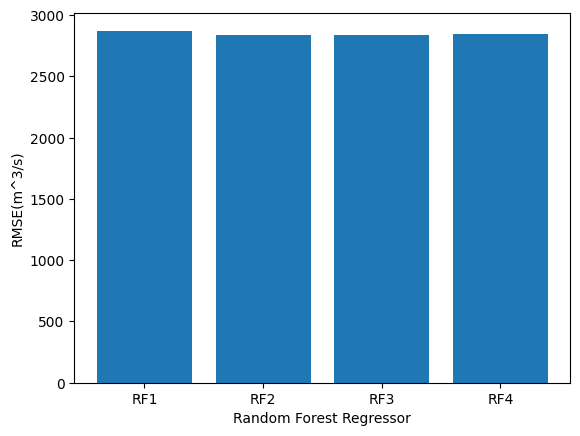

In [96]:
D = {'RF1':2873.209675403621,'RF2':2839.750828563568,'RF3':2840.2114644614076,'RF4':2848.812038003635}
plt.bar(range(len(D)), list(D.values()), align='center')
plt.ylabel('RMSE(m^3/s)')
plt.xlabel('Random Forest Regressor')
plt.xticks(range(len(D)), list(D.keys()))
plt.show()

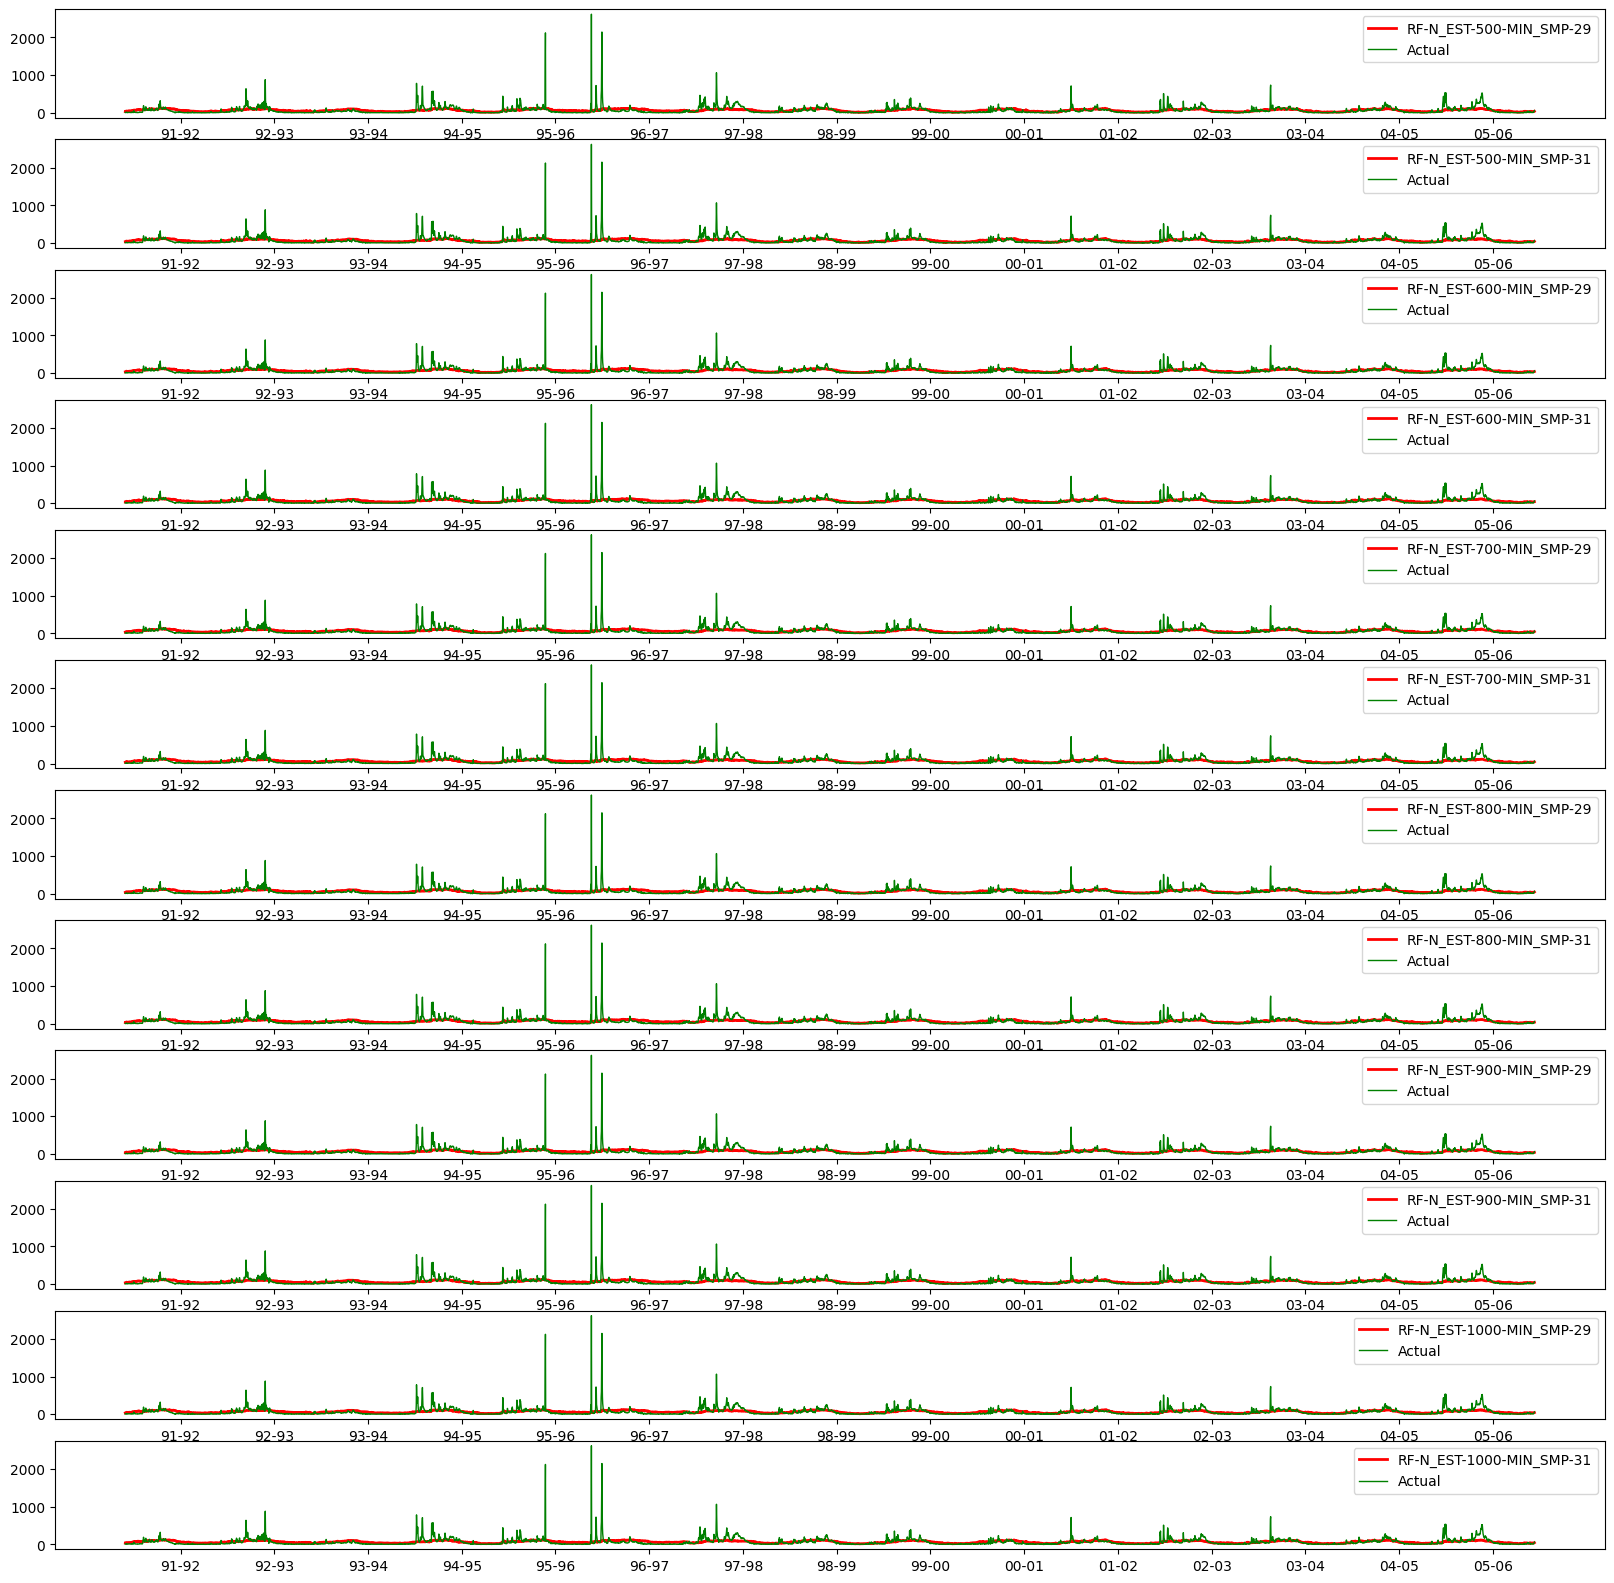

In [97]:
fig,ax = plt.subplots(12,1,figsize=(20,20))
plt.setp(ax, xticks=np.arange(215,5488,step=365),xticklabels=['91-92','92-93','93-94','94-95','95-96','96-97','97-98','98-99','99-00','00-01','01-02','02-03','03-04','04-05','05-06'])
ax[0].plot(p_rf_500_29,"red",label='RF-N_EST-500-MIN_SMP-29',linewidth=2.0)
ax[0].plot(r_rf_500_29,"green",label='Actual',linewidth=1.0)
ax[0].legend()
ax[1].plot(p_rf_500_31,"red",label='RF-N_EST-500-MIN_SMP-31',linewidth=2.0)
ax[1].plot(r_rf_500_31,"green",label='Actual',linewidth=1.0)
ax[1].legend()
ax[2].plot(p_rf_600_29,"red",label='RF-N_EST-600-MIN_SMP-29',linewidth=2.0)
ax[2].plot(r_rf_600_29,"green",label='Actual',linewidth=1.0)
ax[2].legend()
ax[3].plot(p_rf_600_31,"red",label='RF-N_EST-600-MIN_SMP-31',linewidth=2.0)
ax[3].plot(r_rf_600_31,"green",label='Actual',linewidth=1.0)
ax[3].legend()
ax[4].plot(p_rf_700_29,"red",label='RF-N_EST-700-MIN_SMP-29',linewidth=2.0)
ax[4].plot(r_rf_700_29,"green",label='Actual',linewidth=1.0)
ax[4].legend()
ax[5].plot(p_rf_700_31,"red",label='RF-N_EST-700-MIN_SMP-31',linewidth=2.0)
ax[5].plot(r_rf_700_31,"green",label='Actual',linewidth=1.0)
ax[5].legend()
ax[6].plot(p_rf_800_29,"red",label='RF-N_EST-800-MIN_SMP-29',linewidth=2.0)
ax[6].plot(r_rf_800_29,"green",label='Actual',linewidth=1.0)
ax[6].legend()
ax[7].plot(p_rf_800_31,"red",label='RF-N_EST-800-MIN_SMP-31',linewidth=2.0)
ax[7].plot(r_rf_800_31,"green",label='Actual',linewidth=1.0)
ax[7].legend()
ax[8].plot(p_rf_900_29,"red",label='RF-N_EST-900-MIN_SMP-29',linewidth=2.0)
ax[8].plot(r_rf_900_29,"green",label='Actual',linewidth=1.0)
ax[8].legend()
ax[9].plot(p_rf_900_31,"red",label='RF-N_EST-900-MIN_SMP-31',linewidth=2.0)
ax[9].plot(r_rf_900_31,"green",label='Actual',linewidth=1.0)
ax[9].legend()
ax[10].plot(p_rf_1000_29,"red",label='RF-N_EST-1000-MIN_SMP-29',linewidth=2.0)
ax[10].plot(r_rf_1000_29,"green",label='Actual',linewidth=1.0)
ax[10].legend()
ax[11].plot(p_rf_1000_31,"red",label='RF-N_EST-1000-MIN_SMP-31',linewidth=2.0)
ax[11].plot(r_rf_1000_31,"green",label='Actual',linewidth=1.0)
ax[11].legend()
plt.show()

##Final Random Forest

In [98]:
rf = RandomForestRegressor(n_estimators=900,n_jobs=-1,min_samples_leaf=29,max_features='sqrt')
kf = KFold(n_splits=15,shuffle=False)
rmse_rf_300 = []
corr_rf_300 = []
r2_rf_300 = []
mae_rf_300 = []
predictions_rf = []
real_rf = []
for train_index, test_index in tqdm(kf.split(X_pca),total=kf.get_n_splits(),desc="k-fold"):
    X_train, X_test, y_train, y_test = X_pca[train_index], X_pca[test_index], y.iloc[train_index], y.iloc[test_index]
    y_train = np.array(y_train).ravel()
    rf.fit(X_train, y_train)
    y_list_pred = list(rf.predict(X_test))
    y_pred = np.array(y_list_pred)
    y_real_list = list(y_test['VALUE'])
    y_real = np.array(y_real_list)
    rmse_rf_300.append(math.sqrt(mean_squared_error(y_real,y_pred)))
    corr_rf_300.append(correlation(y_real,y_pred))
    r2_rf_300.append(r2_score(y_real,y_pred))
    mae_rf_300.append(mean_absolute_error(y_real,y_pred))
    predictions_rf.extend(y_list_pred)
    real_rf.extend(y_real_list)

k-fold: 100%|██████████| 15/15 [04:16<00:00, 17.13s/it]


**Daily Accuracy**

In [99]:
print('RMSE ', mean(rmse_rf_300))
# print('Monthly NS ', mean(ns_rf_300))
# print('Monthly KGE ', mean(kge_rf_300))
print('CORR ', mean(corr_rf_300))
print('R2 ',mean(r2_rf_300))
print('MAE ',mean(mae_rf_300))

RMSE  76.39491509856781
CORR  0.6240874134873958
R2  0.1285281151819454
MAE  43.022840274466056


**Monthly Accuracy**

In [100]:
a = predictions_rf[24:-4]
b = real_rf[24:-4]
i = 0
p = []
r = []
while i < len(a):
  t = a[i:i+30]
  avg = sum(t)/30
  p.append(avg)
  t = b[i:i+30]
  avg = sum(t)/30
  r.append(avg)
  i = i+30
print('Monthly RMSE ',math.sqrt(mean_squared_error(p, r)))
# print('Monthly NS ',NS(np.array(r),np.array(p)))
# print('Monthly KGE ',KGE(np.array(r),np.array(p)))
print('Monthly CORR ',correlation(np.array(r),np.array(p)))
print('Monthly R2 ',r2_score(r,p))
print('Monthly MAE ',mean_absolute_error(r,p))

Monthly RMSE  47.77885960657965
Monthly CORR  0.7148425012353289
Monthly R2  0.4360900199398766
Monthly MAE  36.11287589747382


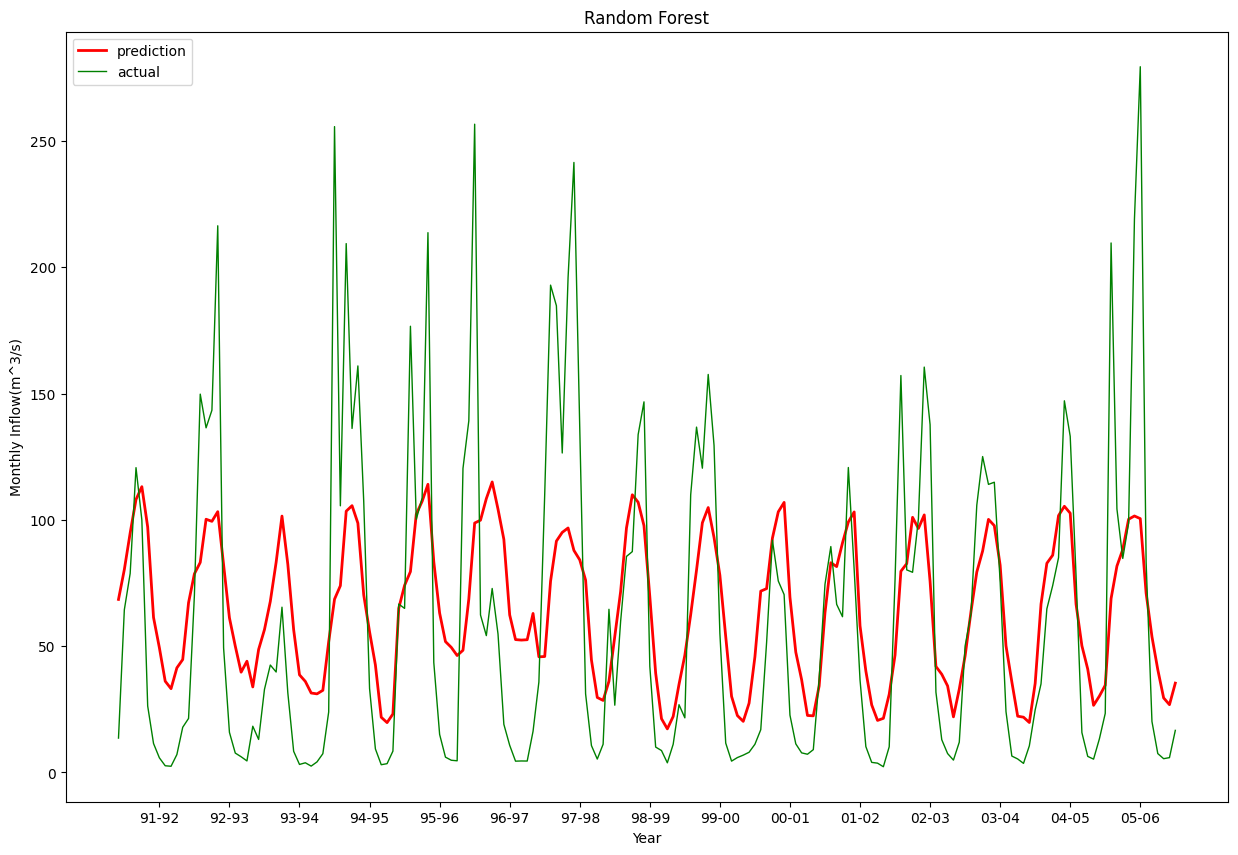

In [101]:
a = predictions_rf[24:-4]
b = real_rf[24:-4]
i = 0
p = []
r = []
while i < len(a):
  t = a[i:i+30]
  avg = sum(t)/30
  p.append(avg)
  t = b[i:i+30]
  avg = sum(t)/30
  r.append(avg)
  i = i+30
plt.figure(figsize=(15, 10))
plt.plot(p, "red", label="prediction", linewidth=2.0)
plt.plot(r, 'green', label="actual", linewidth=1.0)
plt.legend()
plt.ylabel('Monthly Inflow(m^3/s)')
plt.xlabel('Year')
plt.xticks(np.arange(7,182,step=12),['91-92','92-93','93-94','94-95','95-96','96-97','97-98','98-99','99-00','00-01','01-02','02-03','03-04','04-05','05-06'])
plt.title("Random Forest")
plt.show()

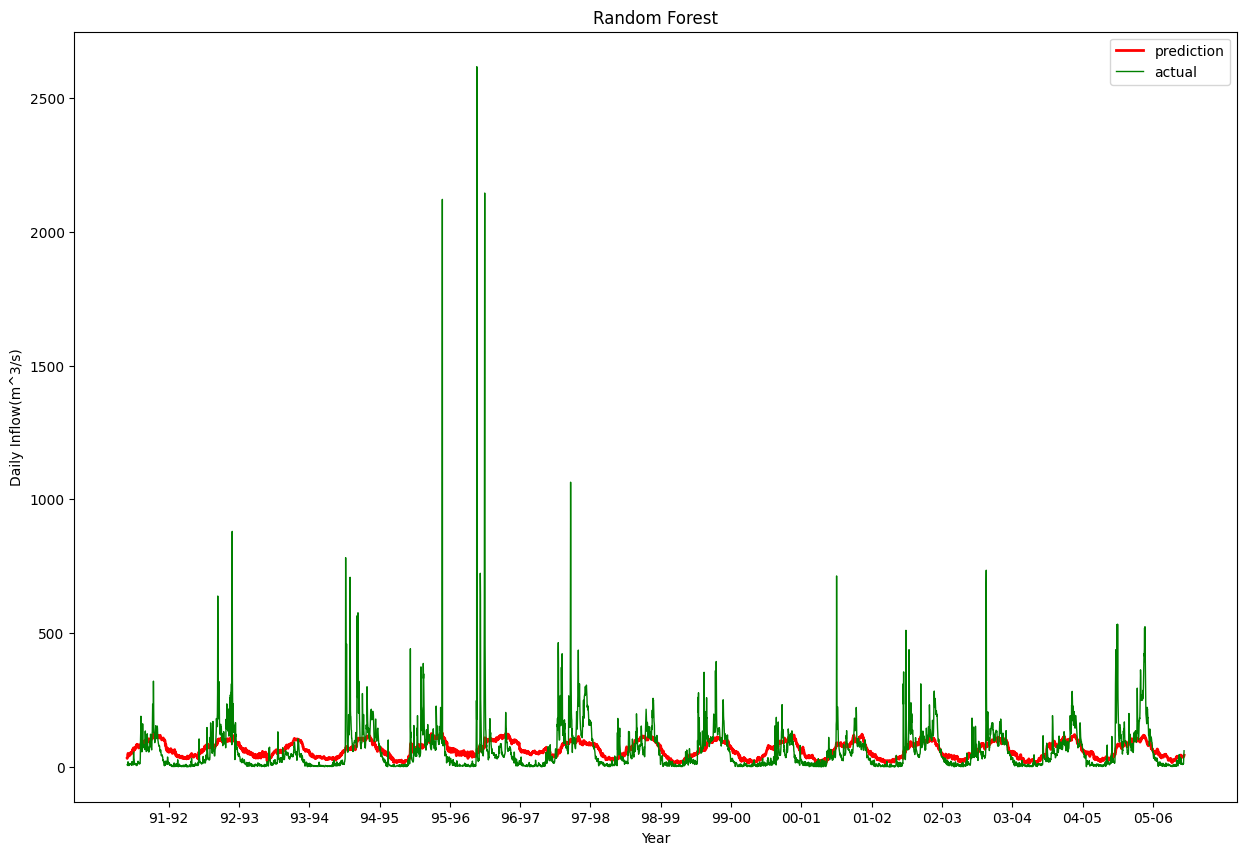

In [102]:
plt.figure(figsize=(15, 10))
plt.plot(predictions_rf, "red", label="prediction", linewidth=2.0)
plt.plot(real_rf, 'green', label="actual", linewidth=1.0)
plt.legend()
plt.ylabel('Daily Inflow(m^3/s)')
plt.xlabel('Year')
plt.xticks(np.arange(215,5488,step=365),['91-92','92-93','93-94','94-95','95-96','96-97','97-98','98-99','99-00','00-01','01-02','02-03','03-04','04-05','05-06'])
plt.title("Random Forest")
plt.show()

##Gradient Boosting Regressor

In [103]:
from sklearn.ensemble import GradientBoostingRegressor

**n_est=100 min_samples=10**

In [104]:
gbr = GradientBoostingRegressor(n_estimators=100,min_samples_leaf=10)
kf = KFold(n_splits=15, shuffle=False)
def_gbr_score_rmse = []
def_gbr_score_corr = []
def_gbr_score_r2 = []
def_gbr_score_mae = []
def_gbr_score_apb = []
r_gbr_100_10 = []
p_gbr_100_10 = []
for train_index, test_index in tqdm(kf.split(X_pca),total=kf.get_n_splits(),desc="k-fold"):
    X_train, X_test, y_train, y_test = X_pca[train_index], X_pca[test_index], y.iloc[train_index], y.iloc[test_index]
    y_train = np.array(y_train).ravel()
    gbr.fit(X_train, y_train)
    y_list_pred = list(gbr.predict(X_test))
    for i in range(len(y_list_pred)):
      if y_list_pred[i] < 0:
        y_list_pred[i]=0
    y_pred = np.array(y_list_pred)
    y_list_real = list(y_test['VALUE'])
    y_real = np.array(y_list_real)
    r_gbr_100_10.extend(y_list_real)
    p_gbr_100_10.extend(y_list_pred)
    def_gbr_score_rmse.append(math.sqrt(mean_squared_error(y_pred, y_real)))
    def_gbr_score_corr.append(correlation(y_real,y_pred))
    def_gbr_score_r2.append(r2_score(y_real,y_pred))
    def_gbr_score_mae.append(mean_absolute_error(y_real,y_pred))
    def_gbr_score_apb.append(Absolute_Percentage_Error(y_real,y_pred))

k-fold: 100%|██████████| 15/15 [19:38<00:00, 78.56s/it]


In [105]:
print('RMSE ',mean(def_gbr_score_rmse))
print('CORR ',mean(def_gbr_score_corr))
print('R2 ',mean(def_gbr_score_r2))
print('MAE ',mean(def_gbr_score_mae))
print('APB ',mean(def_gbr_score_apb))

RMSE  77.6156943333482
CORR  0.5609116293540635
R2  0.10472616493259045
MAE  40.52231143860059
APB  61.766100531642735


**n_est=100 min_samples=15**

In [106]:
gbr = GradientBoostingRegressor(n_estimators=100,min_samples_leaf=15)
kf = KFold(n_splits=15, shuffle=False)
def_gbr_score_rmse = []
def_gbr_score_corr = []
def_gbr_score_r2 = []
def_gbr_score_mae = []
def_gbr_score_apb = []
r_gbr_100_15 = []
p_gbr_100_15 = []
for train_index, test_index in tqdm(kf.split(X_pca),total=kf.get_n_splits(),desc="k-fold"):
    X_train, X_test, y_train, y_test = X_pca[train_index], X_pca[test_index], y.iloc[train_index], y.iloc[test_index]
    y_train = np.array(y_train).ravel()
    gbr.fit(X_train, y_train)
    y_list_pred = list(gbr.predict(X_test))
    for i in range(len(y_list_pred)):
      if y_list_pred[i] < 0:
        y_list_pred[i]=0
    y_pred = np.array(y_list_pred)
    y_list_real = list(y_test['VALUE'])
    y_real = np.array(y_list_real)
    r_gbr_100_15.extend(y_list_real)
    p_gbr_100_15.extend(y_list_pred)
    def_gbr_score_rmse.append(math.sqrt(mean_squared_error(y_pred, y_real)))
    def_gbr_score_corr.append(correlation(y_real,y_pred))
    def_gbr_score_r2.append(r2_score(y_real,y_pred))
    def_gbr_score_mae.append(mean_absolute_error(y_real,y_pred))
    def_gbr_score_apb.append(Absolute_Percentage_Error(y_real,y_pred))

k-fold: 100%|██████████| 15/15 [19:42<00:00, 78.81s/it]


In [107]:
print('RMSE ',mean(def_gbr_score_rmse))
print('CORR ',mean(def_gbr_score_corr))
print('R2 ',mean(def_gbr_score_r2))
print('MAE ',mean(def_gbr_score_mae))
print('APB ',mean(def_gbr_score_apb))

RMSE  76.53135616608441
CORR  0.5662776303536325
R2  0.13303608371183048
MAE  40.29753237123015
APB  61.43912693592205


**n_est=200 min_samples=10**

In [108]:
gbr = GradientBoostingRegressor(n_estimators=200,min_samples_leaf=10)
kf = KFold(n_splits=15, shuffle=False)
def_gbr_score_rmse = []
def_gbr_score_corr = []
def_gbr_score_r2 = []
def_gbr_score_mae = []
def_gbr_score_apb = []
r_gbr_200_10 = []
p_gbr_200_10 = []
for train_index, test_index in tqdm(kf.split(X_pca),total=kf.get_n_splits(),desc="k-fold"):
    X_train, X_test, y_train, y_test = X_pca[train_index], X_pca[test_index], y.iloc[train_index], y.iloc[test_index]
    y_train = np.array(y_train).ravel()
    gbr.fit(X_train, y_train)
    y_list_pred = list(gbr.predict(X_test))
    for i in range(len(y_list_pred)):
      if y_list_pred[i] < 0:
        y_list_pred[i]=0
    y_pred = np.array(y_list_pred)
    y_list_real = list(y_test['VALUE'])
    y_real = np.array(y_list_real)
    r_gbr_200_10.extend(y_list_real)
    p_gbr_200_10.extend(y_list_pred)
    def_gbr_score_rmse.append(math.sqrt(mean_squared_error(y_pred, y_real)))
    def_gbr_score_corr.append(correlation(y_real,y_pred))
    def_gbr_score_r2.append(r2_score(y_real,y_pred))
    def_gbr_score_mae.append(mean_absolute_error(y_real,y_pred))
    def_gbr_score_apb.append(Absolute_Percentage_Error(y_real,y_pred))

k-fold: 100%|██████████| 15/15 [38:18<00:00, 153.24s/it]


In [109]:
print('RMSE ',mean(def_gbr_score_rmse))
print('CORR ',mean(def_gbr_score_corr))
print('R2 ',mean(def_gbr_score_r2))
print('MAE ',mean(def_gbr_score_mae))
print('APB ',mean(def_gbr_score_apb))

RMSE  77.62371285307705
CORR  0.5640249147413173
R2  0.10664074365073978
MAE  41.045889355958586
APB  61.68600721545298


**n_est=200 min_samples=15**

In [110]:
gbr = GradientBoostingRegressor(n_estimators=200,min_samples_leaf=15)
kf = KFold(n_splits=15, shuffle=False)
def_gbr_score_rmse = []
def_gbr_score_corr = []
def_gbr_score_r2 = []
def_gbr_score_mae = []
def_gbr_score_apb = []
r_gbr_200_15 = []
p_gbr_200_15 = []
for train_index, test_index in tqdm(kf.split(X_pca),total=kf.get_n_splits(),desc="k-fold"):
    X_train, X_test, y_train, y_test = X_pca[train_index], X_pca[test_index], y.iloc[train_index], y.iloc[test_index]
    y_train = np.array(y_train).ravel()
    gbr.fit(X_train, y_train)
    y_list_pred = list(gbr.predict(X_test))
    for i in range(len(y_list_pred)):
      if y_list_pred[i] < 0:
        y_list_pred[i]=0
    y_pred = np.array(y_list_pred)
    y_list_real = list(y_test['VALUE'])
    y_real = np.array(y_list_real)
    r_gbr_200_15.extend(y_list_real)
    p_gbr_200_15.extend(y_list_pred)
    def_gbr_score_rmse.append(math.sqrt(mean_squared_error(y_pred, y_real)))
    def_gbr_score_corr.append(correlation(y_real,y_pred))
    def_gbr_score_r2.append(r2_score(y_real,y_pred))
    def_gbr_score_mae.append(mean_absolute_error(y_real,y_pred))
    def_gbr_score_apb.append(Absolute_Percentage_Error(y_real,y_pred))

k-fold: 100%|██████████| 15/15 [39:33<00:00, 158.24s/it]


In [111]:
print('RMSE ',mean(def_gbr_score_rmse))
print('CORR ',mean(def_gbr_score_corr))
print('R2 ',mean(def_gbr_score_r2))
print('MAE ',mean(def_gbr_score_mae))
print('APB ',mean(def_gbr_score_apb))

RMSE  76.55819803169177
CORR  0.569689398382909
R2  0.13474347453743277
MAE  41.02091279987124
APB  61.47895313593872


**n_est=300 min_samples=10**

In [112]:
gbr = GradientBoostingRegressor(n_estimators=300,min_samples_leaf=10)
kf = KFold(n_splits=15, shuffle=False)
def_gbr_score_rmse = []
def_gbr_score_corr = []
def_gbr_score_r2 = []
def_gbr_score_mae = []
def_gbr_score_apb = []
r_gbr_300_10 = []
p_gbr_300_10 = []
for train_index, test_index in tqdm(kf.split(X_pca),total=kf.get_n_splits(),desc="k-fold"):
    X_train, X_test, y_train, y_test = X_pca[train_index], X_pca[test_index], y.iloc[train_index], y.iloc[test_index]
    y_train = np.array(y_train).ravel()
    gbr.fit(X_train, y_train)
    y_list_pred = list(gbr.predict(X_test))
    for i in range(len(y_list_pred)):
      if y_list_pred[i] < 0:
        y_list_pred[i]=0
    y_pred = np.array(y_list_pred)
    y_list_real = list(y_test['VALUE'])
    y_real = np.array(y_list_real)
    r_gbr_300_10.extend(y_list_real)
    p_gbr_300_10.extend(y_list_pred)
    def_gbr_score_rmse.append(math.sqrt(mean_squared_error(y_pred, y_real)))
    def_gbr_score_corr.append(correlation(y_real,y_pred))
    def_gbr_score_r2.append(r2_score(y_real,y_pred))
    def_gbr_score_mae.append(mean_absolute_error(y_real,y_pred))
    def_gbr_score_apb.append(Absolute_Percentage_Error(y_real,y_pred))

k-fold: 100%|██████████| 15/15 [1:02:53<00:00, 251.57s/it]


In [113]:
print('RMSE ',mean(def_gbr_score_rmse))
print('CORR ',mean(def_gbr_score_corr))
print('R2 ',mean(def_gbr_score_r2))
print('MAE ',mean(def_gbr_score_mae))
print('APB ',mean(def_gbr_score_apb))

RMSE  77.24425267108369
CORR  0.57032660300277
R2  0.11031633620825848
MAE  41.297896020799385
APB  61.16654075806962


**n_est=300 min_samples=15**

In [114]:
gbr = GradientBoostingRegressor(n_estimators=300,min_samples_leaf=15)
kf = KFold(n_splits=15, shuffle=False)
def_gbr_score_rmse = []
def_gbr_score_corr = []
def_gbr_score_r2 = []
def_gbr_score_mae = []
def_gbr_score_apb = []
r_gbr_300_15 = []
p_gbr_300_15 = []
for train_index, test_index in tqdm(kf.split(X_pca),total=kf.get_n_splits(),desc="k-fold"):
    X_train, X_test, y_train, y_test = X_pca[train_index], X_pca[test_index], y.iloc[train_index], y.iloc[test_index]
    y_train = np.array(y_train).ravel()
    gbr.fit(X_train, y_train)
    y_list_pred = list(gbr.predict(X_test))
    for i in range(len(y_list_pred)):
      if y_list_pred[i] < 0:
        y_list_pred[i]=0
    y_pred = np.array(y_list_pred)
    y_list_real = list(y_test['VALUE'])
    y_real = np.array(y_list_real)
    r_gbr_300_15.extend(y_list_real)
    p_gbr_300_15.extend(y_list_pred)
    def_gbr_score_rmse.append(math.sqrt(mean_squared_error(y_pred, y_real)))
    def_gbr_score_corr.append(correlation(y_real,y_pred))
    def_gbr_score_r2.append(r2_score(y_real,y_pred))
    def_gbr_score_mae.append(mean_absolute_error(y_real,y_pred))
    def_gbr_score_apb.append(Absolute_Percentage_Error(y_real,y_pred))

k-fold: 100%|██████████| 15/15 [1:06:21<00:00, 265.45s/it]


In [115]:
print('RMSE ',mean(def_gbr_score_rmse))
print('CORR ',mean(def_gbr_score_corr))
print('R2 ',mean(def_gbr_score_r2))
print('MAE ',mean(def_gbr_score_mae))
print('APB ',mean(def_gbr_score_apb))

RMSE  76.5770698149672
CORR  0.5718131091532069
R2  0.13558789131501983
MAE  41.426979823448185
APB  61.306439548429836


**n_est=400 min_samples=10**

In [116]:
gbr = GradientBoostingRegressor(n_estimators=400,min_samples_leaf=10)
kf = KFold(n_splits=15, shuffle=False)
def_gbr_score_rmse = []
def_gbr_score_corr = []
def_gbr_score_r2 = []
def_gbr_score_mae = []
def_gbr_score_apb = []
r_gbr_400_10= []
p_gbr_400_10 = []
for train_index, test_index in tqdm(kf.split(X_pca),total=kf.get_n_splits(),desc="k-fold"):
    X_train, X_test, y_train, y_test = X_pca[train_index], X_pca[test_index], y.iloc[train_index], y.iloc[test_index]
    y_train = np.array(y_train).ravel()
    gbr.fit(X_train, y_train)
    y_list_pred = list(gbr.predict(X_test))
    for i in range(len(y_list_pred)):
      if y_list_pred[i] < 0:
        y_list_pred[i]=0
    y_pred = np.array(y_list_pred)
    y_list_real = list(y_test['VALUE'])
    y_real = np.array(y_list_real)
    r_gbr_400_10.extend(y_list_real)
    p_gbr_400_10.extend(y_list_pred)
    def_gbr_score_rmse.append(math.sqrt(mean_squared_error(y_pred, y_real)))
    def_gbr_score_corr.append(correlation(y_real,y_pred))
    def_gbr_score_r2.append(r2_score(y_real,y_pred))
    def_gbr_score_mae.append(mean_absolute_error(y_real,y_pred))
    def_gbr_score_apb.append(Absolute_Percentage_Error(y_real,y_pred))

k-fold: 100%|██████████| 15/15 [1:26:35<00:00, 346.34s/it]


In [117]:
print('RMSE ',mean(def_gbr_score_rmse))
print('CORR ',mean(def_gbr_score_corr))
print('R2 ',mean(def_gbr_score_r2))
print('MAE ',mean(def_gbr_score_mae))
print('APB ',mean(def_gbr_score_apb))

RMSE  77.20508125016653
CORR  0.5708381168410979
R2  0.11514097093871042
MAE  41.53186072216128
APB  60.79312811190846


**n_est=400 min_samples=15**

In [118]:
gbr = GradientBoostingRegressor(n_estimators=400,min_samples_leaf=15)
kf = KFold(n_splits=15, shuffle=False)
def_gbr_score_rmse = []
def_gbr_score_corr = []
def_gbr_score_r2 = []
def_gbr_score_mae = []
def_gbr_score_apb = []
r_gbr_400_15 = []
p_gbr_400_15 = []
for train_index, test_index in tqdm(kf.split(X_pca),total=kf.get_n_splits(),desc="k-fold"):
    X_train, X_test, y_train, y_test = X_pca[train_index], X_pca[test_index], y.iloc[train_index], y.iloc[test_index]
    y_train = np.array(y_train).ravel()
    gbr.fit(X_train, y_train)
    y_list_pred = list(gbr.predict(X_test))
    for i in range(len(y_list_pred)):
      if y_list_pred[i] < 0:
        y_list_pred[i]=0
    y_pred = np.array(y_list_pred)
    y_list_real = list(y_test['VALUE'])
    y_real = np.array(y_list_real)
    r_gbr_400_15.extend(y_list_real)
    p_gbr_400_15.extend(y_list_pred)
    def_gbr_score_rmse.append(math.sqrt(mean_squared_error(y_pred, y_real)))
    def_gbr_score_corr.append(correlation(y_real,y_pred))
    def_gbr_score_r2.append(r2_score(y_real,y_pred))
    def_gbr_score_mae.append(mean_absolute_error(y_real,y_pred))
    def_gbr_score_apb.append(Absolute_Percentage_Error(y_real,y_pred))

k-fold: 100%|██████████| 15/15 [1:21:19<00:00, 325.28s/it]


In [119]:
print('RMSE ',mean(def_gbr_score_rmse))
print('CORR ',mean(def_gbr_score_corr))
print('R2 ',mean(def_gbr_score_r2))
print('MAE ',mean(def_gbr_score_mae))
print('APB ',mean(def_gbr_score_apb))

RMSE  76.2343370930631
CORR  0.5771582242526959
R2  0.14420308908164078
MAE  41.5556809621395
APB  60.82279577319542


**n_esti = 500, min_samples = 10**

In [120]:
gbr = GradientBoostingRegressor(n_estimators=500,min_samples_leaf=10)
kf = KFold(n_splits=15, shuffle=False)
def_gbr_score_rmse = []
def_gbr_score_corr = []
def_gbr_score_r2 = []
def_gbr_score_mae = []
def_gbr_score_apb = []
r_gbr_500_10 = []
p_gbr_500_10 = []
for train_index, test_index in tqdm(kf.split(X_pca),total=kf.get_n_splits(),desc="k-fold"):
    X_train, X_test, y_train, y_test = X_pca[train_index], X_pca[test_index], y.iloc[train_index], y.iloc[test_index]
    y_train = np.array(y_train).ravel()
    gbr.fit(X_train, y_train)
    y_list_pred = list(gbr.predict(X_test))
    for i in range(len(y_list_pred)):
      if y_list_pred[i] < 0:
        y_list_pred[i]=0
    y_pred = np.array(y_list_pred)
    y_list_real = list(y_test['VALUE'])
    y_real = np.array(y_list_real)
    r_gbr_500_10.extend(y_list_real)
    p_gbr_500_10.extend(y_list_pred)
    def_gbr_score_rmse.append(math.sqrt(mean_squared_error(y_pred, y_real)))
    def_gbr_score_corr.append(correlation(y_real,y_pred))
    def_gbr_score_r2.append(r2_score(y_real,y_pred))
    def_gbr_score_mae.append(mean_absolute_error(y_real,y_pred))
    def_gbr_score_apb.append(Absolute_Percentage_Error(y_real,y_pred))

k-fold: 100%|██████████| 15/15 [1:40:29<00:00, 401.99s/it]


In [121]:
print('RMSE ',mean(def_gbr_score_rmse))
print('CORR ',mean(def_gbr_score_corr))
print('R2 ',mean(def_gbr_score_r2))
print('MAE ',mean(def_gbr_score_mae))
print('APB ',mean(def_gbr_score_apb))

RMSE  76.87962811891067
CORR  0.5758473657479529
R2  0.12160430694266662
MAE  41.57865759669755
APB  60.49092398011522


**n_est=500 min_samples=15**

In [122]:
gbr = GradientBoostingRegressor(n_estimators=500,min_samples_leaf=15)
kf = KFold(n_splits=15, shuffle=False)
def_gbr_score_rmse = []
def_gbr_score_corr = []
def_gbr_score_r2 = []
def_gbr_score_mae = []
def_gbr_score_apb = []
r_gbr_500_15 = []
p_gbr_500_15 = []
for train_index, test_index in tqdm(kf.split(X_pca),total=kf.get_n_splits(),desc="k-fold"):
    X_train, X_test, y_train, y_test = X_pca[train_index], X_pca[test_index], y.iloc[train_index], y.iloc[test_index]
    y_train = np.array(y_train).ravel()
    gbr.fit(X_train, y_train)
    y_list_pred = list(gbr.predict(X_test))
    for i in range(len(y_list_pred)):
      if y_list_pred[i] < 0:
        y_list_pred[i]=0
    y_pred = np.array(y_list_pred)
    y_list_real = list(y_test['VALUE'])
    y_real = np.array(y_list_real)
    r_gbr_500_15.extend(y_list_real)
    p_gbr_500_15.extend(y_list_pred)
    def_gbr_score_rmse.append(math.sqrt(mean_squared_error(y_pred, y_real)))
    def_gbr_score_corr.append(correlation(y_real,y_pred))
    def_gbr_score_r2.append(r2_score(y_real,y_pred))
    def_gbr_score_mae.append(mean_absolute_error(y_real,y_pred))
    def_gbr_score_apb.append(Absolute_Percentage_Error(y_real,y_pred))

k-fold: 100%|██████████| 15/15 [1:41:12<00:00, 404.81s/it]


In [123]:
print('RMSE ',mean(def_gbr_score_rmse))
print('CORR ',mean(def_gbr_score_corr))
print('R2 ',mean(def_gbr_score_r2))
print('MAE ',mean(def_gbr_score_mae))
print('APB ',mean(def_gbr_score_apb))

RMSE  76.03161625943689
CORR  0.5802782607878658
R2  0.14794350436484205
MAE  41.67305410529901
APB  60.5511939418853


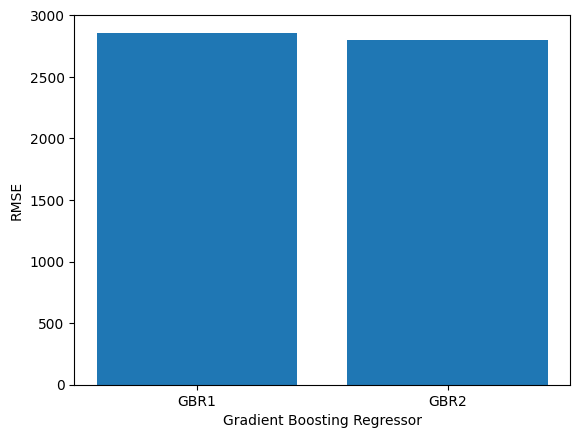

In [124]:
D = {'GBR1':2858.750227575626,'GBR2':2797.4144812840773}
plt.bar(range(len(D)), list(D.values()), align='center')
plt.ylabel('RMSE')
plt.xlabel('Gradient Boosting Regressor')
plt.xticks(range(len(D)), list(D.keys()))
plt.show()

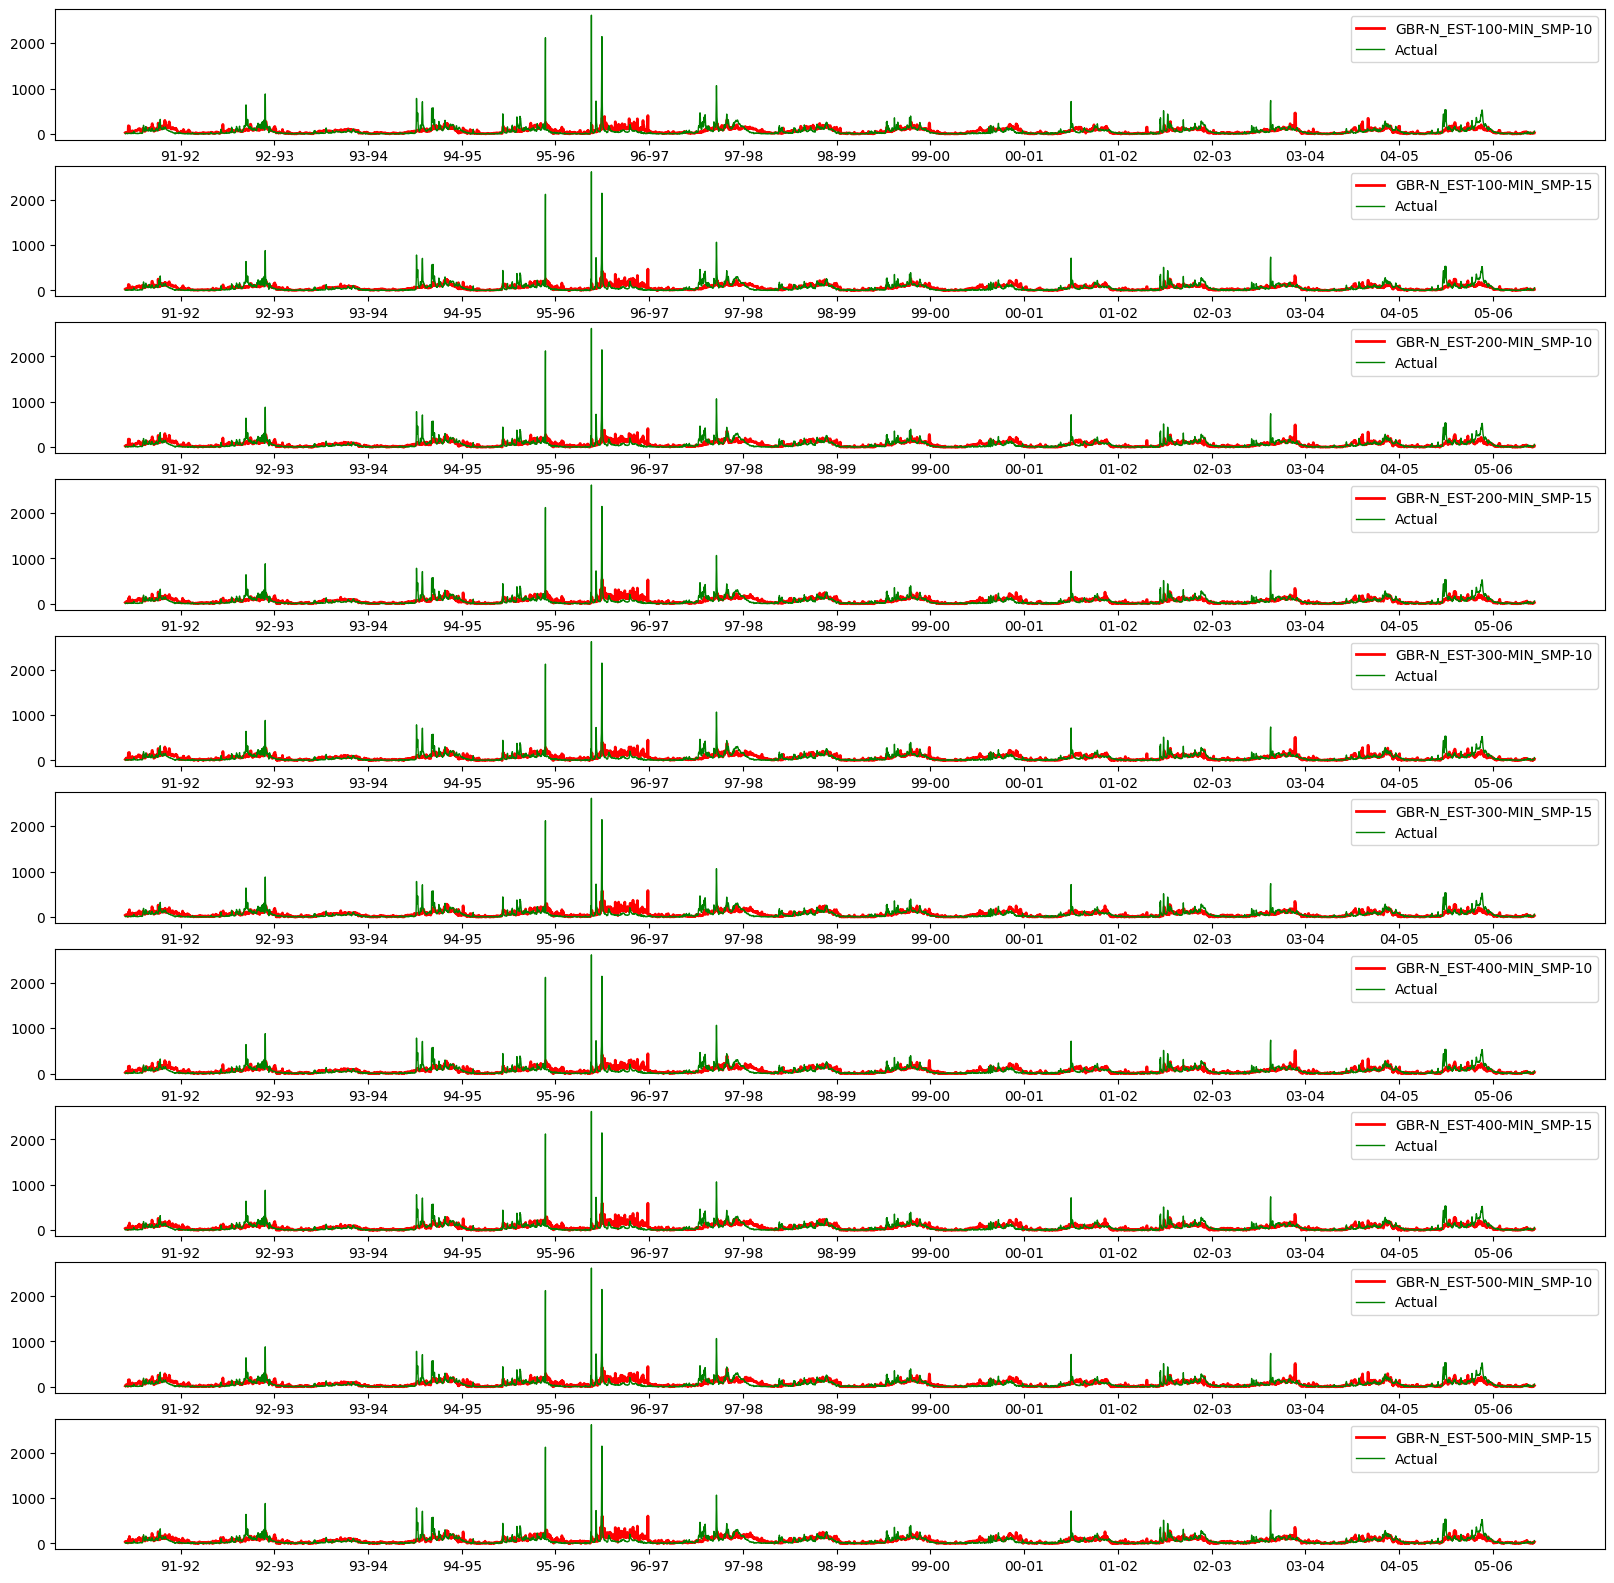

In [125]:
fig,ax = plt.subplots(10,1,figsize=(20,20))
plt.setp(ax, xticks=np.arange(215,5488,step=365),xticklabels=['91-92','92-93','93-94','94-95','95-96','96-97','97-98','98-99','99-00','00-01','01-02','02-03','03-04','04-05','05-06'])
ax[0].plot(p_gbr_100_10,"red",label='GBR-N_EST-100-MIN_SMP-10',linewidth=2.0)
ax[0].plot(r_gbr_100_10,"green",label='Actual',linewidth=1.0)
ax[0].legend()
ax[1].plot(p_gbr_100_15,"red",label='GBR-N_EST-100-MIN_SMP-15',linewidth=2.0)
ax[1].plot(r_gbr_100_15,"green",label='Actual',linewidth=1.0)
ax[1].legend()
ax[2].plot(p_gbr_200_10,"red",label='GBR-N_EST-200-MIN_SMP-10',linewidth=2.0)
ax[2].plot(r_gbr_200_10,"green",label='Actual',linewidth=1.0)
ax[2].legend()
ax[3].plot(p_gbr_200_15,"red",label='GBR-N_EST-200-MIN_SMP-15',linewidth=2.0)
ax[3].plot(r_gbr_200_15,"green",label='Actual',linewidth=1.0)
ax[3].legend()
ax[4].plot(p_gbr_300_10,"red",label='GBR-N_EST-300-MIN_SMP-10',linewidth=2.0)
ax[4].plot(r_gbr_300_10,"green",label='Actual',linewidth=1.0)
ax[4].legend()
ax[5].plot(p_gbr_300_15,"red",label='GBR-N_EST-300-MIN_SMP-15',linewidth=2.0)
ax[5].plot(r_gbr_300_15,"green",label='Actual',linewidth=1.0)
ax[5].legend()
ax[6].plot(p_gbr_400_10,"red",label='GBR-N_EST-400-MIN_SMP-10',linewidth=2.0)
ax[6].plot(r_gbr_400_10,"green",label='Actual',linewidth=1.0)
ax[6].legend()
ax[7].plot(p_gbr_400_15,"red",label='GBR-N_EST-400-MIN_SMP-15',linewidth=2.0)
ax[7].plot(r_gbr_400_15,"green",label='Actual',linewidth=1.0)
ax[7].legend()
ax[8].plot(p_gbr_500_10,"red",label='GBR-N_EST-500-MIN_SMP-10',linewidth=2.0)
ax[8].plot(r_gbr_500_10,"green",label='Actual',linewidth=1.0)
ax[8].legend()
ax[9].plot(p_gbr_500_15,"red",label='GBR-N_EST-500-MIN_SMP-15',linewidth=2.0)
ax[9].plot(r_gbr_500_15,"green",label='Actual',linewidth=1.0)
ax[9].legend()
plt.show()

##Final GBR

In [126]:
gbr = GradientBoostingRegressor(n_estimators=500,min_samples_leaf=15)
kf = KFold(n_splits=15, shuffle=False)
gbr_5_rmse = []
gbr_5_ns = []
gbr_5_kge = []
gbr_5_corr = []
predictions_gbr = []
real_gbr = []
for train_index, test_index in tqdm(kf.split(X_pca),total=kf.get_n_splits(),desc="k-fold"):
    X_train, X_test, y_train, y_test = X_pca[train_index], X_pca[test_index], y.iloc[train_index], y.iloc[test_index]
    y_train= np.array(y_train).ravel()
    gbr.fit(X_train, y_train)
    y_list_pred = list(gbr.predict(X_test))
    y_pred = np.array(y_list_pred)
    y_list_real = list(y_test['VALUE'])
    y_real = np.array(y_list_real)
    predictions_gbr.extend(y_list_pred)
    real_gbr.extend(y_list_real)
    gbr_5_rmse.append(math.sqrt(mean_squared_error(y_pred, y_real)))
    gbr_5_ns.append(NS(y_real,y_pred))
    gbr_5_kge.append(KGE(y_real,y_pred))
    gbr_5_corr.append(correlation(y_real,y_pred))

k-fold: 100%|██████████| 15/15 [1:45:00<00:00, 420.04s/it]


**Daily Accuracy**

In [127]:
print('RMSE ',mean(gbr_5_rmse))
print('NS ',mean(gbr_5_ns))
print('KGE ',mean(gbr_5_kge))
print('CORR ',mean(gbr_5_corr))

RMSE  76.1880730483359
NS  -1.0292142224288294
KGE  0.22835817839369354
CORR  0.5795388787323906


In [128]:
Variance = np.var(np.array(predictions_gbr))
SSE = np.mean((np.mean(np.array(predictions_gbr)) - np.array(real_gbr))** 2)
Bias = SSE - Variance
print('Bias ', Bias)
print('Variance ',Variance)

Bias  6034.157423041905
Variance  3679.373915089274


**Monthly Accuracy**

In [129]:
a = predictions_gbr[24:-4]
b = real_gbr[24:-4]
i = 0
p = []
r = []
while i < len(a):
  t = a[i:i+30]
  avg = sum(t)/30
  p.append(avg)
  t = b[i:i+30]
  avg = sum(t)/30
  r.append(avg)
  i = i+30
print('Monthly RMSE ',math.sqrt(mean_squared_error(p, r)))
print('Monthly NS ',NS(np.array(r),np.array(p)))
print('Monthly KGE ',KGE(np.array(r),np.array(p)))
print('Monthly CORR ',correlation(np.array(r),np.array(p)))

Monthly RMSE  43.39025047741393
Monthly NS  0.3124918788864991
Monthly KGE  0.6558887384981555
Monthly CORR  0.7388155240768661


In [130]:
Variance = np.var(np.array(p))
SSE = np.mean((np.mean(np.array(p)) - np.array(r))** 2)
Bias = SSE - Variance
print('Bias ', Bias)
print('Variance ',Variance)

Bias  1325.6233000299703
Variance  2738.4605049369334


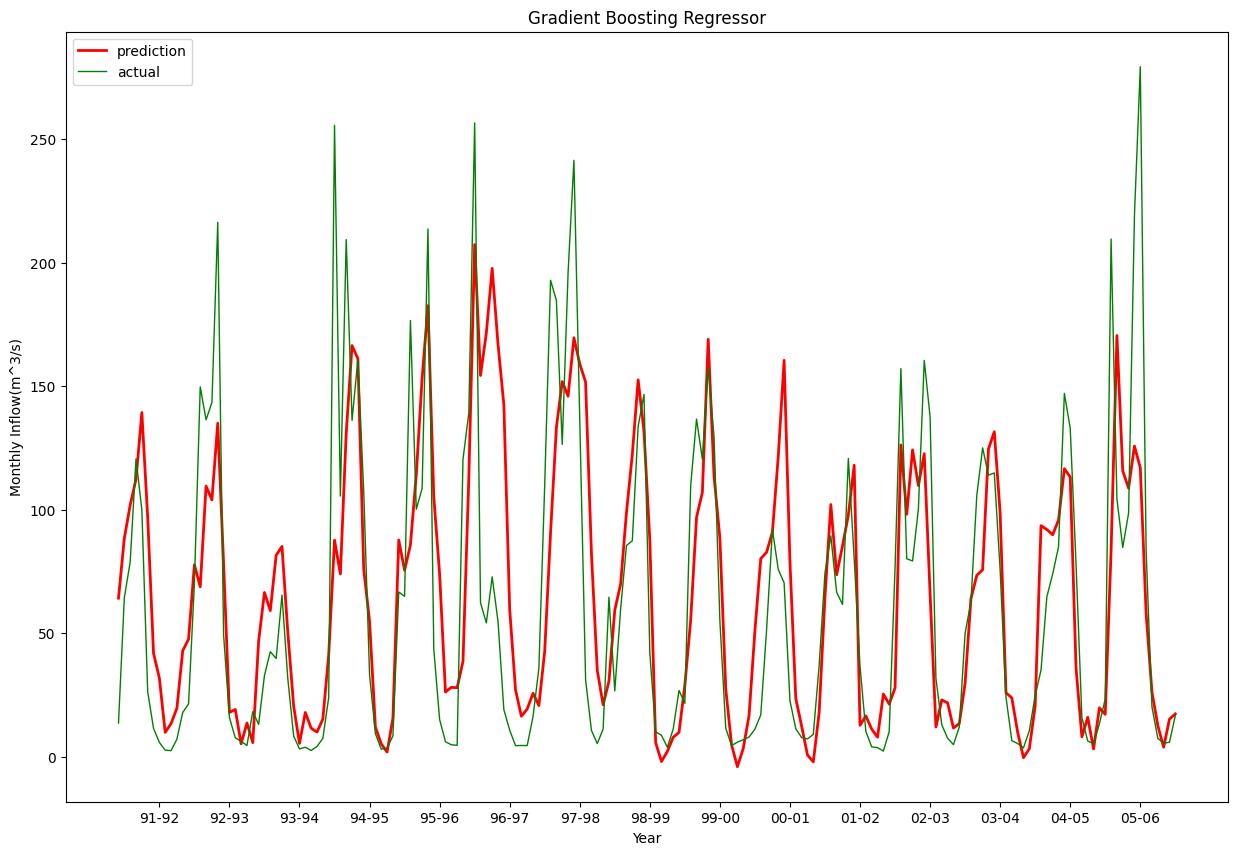

In [131]:
a = predictions_gbr[24:-4]
b = real_gbr[24:-4]
i = 0
p = []
r = []
while i < len(a):
  t = a[i:i+30]
  avg = sum(t)/30
  p.append(avg)
  t = b[i:i+30]
  avg = sum(t)/30
  r.append(avg)
  i = i+30
plt.figure(figsize=(15, 10))
plt.plot(p, "red", label="prediction", linewidth=2.0)
plt.plot(r, 'green', label="actual", linewidth=1.0)
plt.legend()
plt.ylabel('Monthly Inflow(m^3/s)')
plt.xlabel('Year')
plt.xticks(np.arange(7,182,step=12),['91-92','92-93','93-94','94-95','95-96','96-97','97-98','98-99','99-00','00-01','01-02','02-03','03-04','04-05','05-06'])
plt.title("Gradient Boosting Regressor")
plt.show()

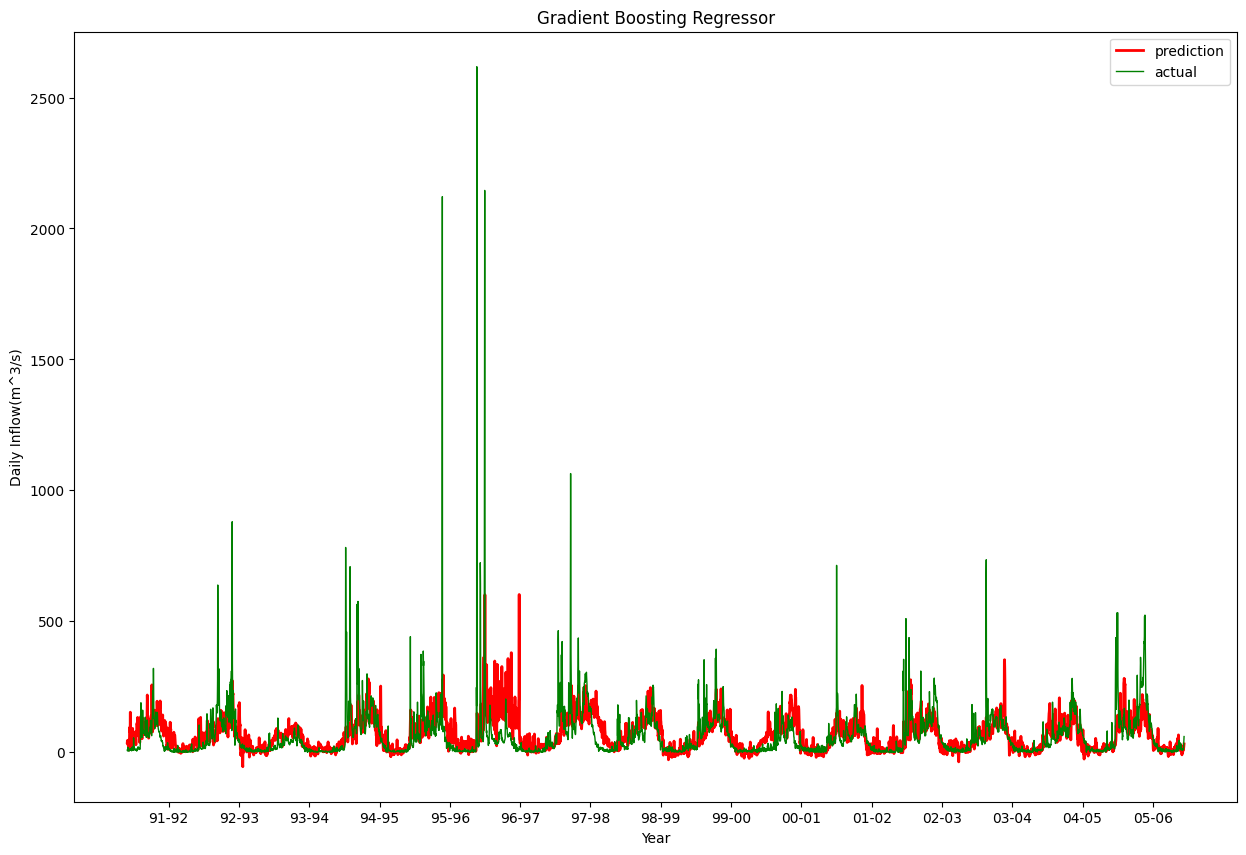

In [132]:
plt.figure(figsize=(15, 10))
plt.plot(predictions_gbr, "red", label="prediction", linewidth=2.0)
plt.plot(real_gbr, 'green', label="actual", linewidth=1.0)
plt.legend()
plt.ylabel('Daily Inflow(m^3/s)')
plt.xlabel('Year')
plt.xticks(np.arange(215,5488,step=365),['91-92','92-93','93-94','94-95','95-96','96-97','97-98','98-99','99-00','00-01','01-02','02-03','03-04','04-05','05-06'])
plt.title("Gradient Boosting Regressor")
plt.show()

##KNN Regressor

In [133]:
from sklearn.neighbors import KNeighborsRegressor

**n=55**

In [134]:
knn = KNeighborsRegressor(n_neighbors=55)
kf = KFold(n_splits=15, shuffle=False)
knn_21_rmse = []
knn_21_corr = []
knn_21_r2 = []
knn_21_mae = []
knn_21_apb =[]
p_knn_55 = []
r_knn_55 = []
for train_index, test_index in tqdm(kf.split(X_pca),total=kf.get_n_splits(),desc="k-fold"):
    X_train, X_test, y_train, y_test = X_pca[train_index], X_pca[test_index], y.iloc[train_index], y.iloc[test_index]
    knn.fit(X_train, y_train)
    y_list = knn.predict(X_test)
    y_real = []
    y_pred = []
    for i in y_test['VALUE']:
      y_real.append(i)
    for i in y_list:
      y_pred.append(i)
    p_knn_55.extend(y_pred)
    r_knn_55.extend(y_real)
    y_pred = np.array(y_pred).reshape(len(y_pred))
    y_real = np.array(y_real)
    knn_21_rmse.append(math.sqrt(mean_squared_error(y_real, y_pred)))
    knn_21_corr.append(correlation(y_real,y_pred))
    knn_21_r2.append(r2_score(y_real,y_pred))
    knn_21_mae.append(mean_absolute_error(y_real,y_pred))
    knn_21_apb.append(Absolute_Percentage_Error(y_real,y_pred))

k-fold: 100%|██████████| 15/15 [00:06<00:00,  2.47it/s]


In [135]:
print('RMSE ',mean(knn_21_rmse))
print('CORR ',mean(knn_21_corr))
print('R2 ',mean(knn_21_r2))
print('MAE ',mean(knn_21_mae))
print('APB ',mean(knn_21_apb))

RMSE  82.48511301176913
CORR  0.5496386627174822
R2  0.12566234028596635
MAE  40.00321369760437
APB  140.18891235027718


**N=57**

In [136]:
knn = KNeighborsRegressor(n_neighbors=57)
kf = KFold(n_splits=15, shuffle=False)
knn_23_rmse = []
knn_23_corr = []
knn_23_r2 = []
knn_23_mae = []
knn_23_apb = []
p_knn_57 = []
r_knn_57 = []
for train_index, test_index in tqdm(kf.split(X_pca),total=kf.get_n_splits(),desc="k-fold"):
    X_train, X_test, y_train, y_test = X_pca[train_index], X_pca[test_index], y.iloc[train_index], y.iloc[test_index]
    knn.fit(X_train, y_train)
    y_list = knn.predict(X_test)
    y_real = []
    y_pred = []
    for i in y_test['VALUE']:
      y_real.append(i)
    for i in y_list:
      y_pred.append(i)
    p_knn_57.extend(y_pred)
    r_knn_57.extend(y_real)
    y_pred = np.array(y_pred).reshape(len(y_pred))
    y_real = np.array(y_real)
    knn_23_rmse.append(math.sqrt(mean_squared_error(y_real, y_pred)))
    knn_23_corr.append(correlation(y_real,y_pred))
    knn_23_r2.append(r2_score(y_real,y_pred))
    knn_23_mae.append(mean_absolute_error(y_real,y_pred))
    knn_23_apb.append(Absolute_Percentage_Error(y_real,y_pred))

k-fold: 100%|██████████| 15/15 [00:04<00:00,  3.14it/s]


In [137]:
print('RMSE ',mean(knn_23_rmse))
print('CORR ',mean(knn_23_corr))
print('R2 ',mean(knn_23_r2))
print('MAE ',mean(knn_23_mae))
print('APB ',mean(knn_23_apb))

RMSE  82.50444807936857
CORR  0.5501819700849914
R2  0.12647426613011187
MAE  40.02257247588495
APB  140.7044237714348


**N=59**

In [138]:
knn = KNeighborsRegressor(n_neighbors=59)
kf = KFold(n_splits=15, shuffle=False)
knn_25_rmse = []
knn_25_corr = []
knn_25_r2 = []
knn_25_mae = []
knn_25_apb =[]
p_knn_59 = []
r_knn_59 = []
for train_index, test_index in tqdm(kf.split(X_pca),total=kf.get_n_splits(),desc="k-fold"):
    X_train, X_test, y_train, y_test = X_pca[train_index], X_pca[test_index], y.iloc[train_index], y.iloc[test_index]
    knn.fit(X_train, y_train)
    y_list = knn.predict(X_test)
    y_real = []
    y_pred = []
    for i in y_test['VALUE']:
      y_real.append(i)
    for i in y_list:
      y_pred.append(i)
    p_knn_59.extend(y_pred)
    r_knn_59.extend(y_real)
    y_pred = np.array(y_pred).reshape(len(y_pred))
    y_real = np.array(y_real)
    knn_25_rmse.append(math.sqrt(mean_squared_error(y_real, y_pred)))
    knn_25_corr.append(correlation(y_real,y_pred))
    knn_25_r2.append(r2_score(y_real,y_pred))
    knn_25_mae.append(mean_absolute_error(y_real,y_pred))
    knn_25_apb.append(Absolute_Percentage_Error(y_real,y_pred))

k-fold: 100%|██████████| 15/15 [00:05<00:00,  2.99it/s]


In [139]:
print('RMSE ',mean(knn_25_rmse))
print('CORR ',mean(knn_25_corr))
print('R2 ',mean(knn_25_r2))
print('MAE ',mean(knn_25_mae))
print('APB ',mean(knn_25_apb))

RMSE  82.51271413250399
CORR  0.5512036768283892
R2  0.1274219620815285
MAE  40.0616713380799
APB  141.31111453129117


**N=61**

In [140]:
knn = KNeighborsRegressor(n_neighbors=61)
kf = KFold(n_splits=15, shuffle=False)
knn_27_rmse = []
knn_27_corr = []
knn_27_r2 = []
knn_27_mae = []
knn_27_apb =[]
p_knn_61 = []
r_knn_61 = []
for train_index, test_index in tqdm(kf.split(X_pca),total=kf.get_n_splits(),desc="k-fold"):
    X_train, X_test, y_train, y_test = X_pca[train_index], X_pca[test_index], y.iloc[train_index], y.iloc[test_index]
    knn.fit(X_train, y_train)
    y_list = knn.predict(X_test)
    y_real = []
    y_pred = []
    for i in y_test['VALUE']:
      y_real.append(i)
    for i in y_list:
      y_pred.append(i)
    p_knn_61.extend(y_pred)
    r_knn_61.extend(y_real)
    y_pred = np.array(y_pred).reshape(len(y_pred))
    y_real = np.array(y_real)
    knn_27_rmse.append(math.sqrt(mean_squared_error(y_real, y_pred)))
    knn_27_corr.append(correlation(y_real,y_pred))
    knn_27_r2.append(r2_score(y_real,y_pred))
    knn_27_mae.append(mean_absolute_error(y_real,y_pred))
    knn_27_apb.append(Absolute_Percentage_Error(y_real,y_pred))

k-fold: 100%|██████████| 15/15 [00:03<00:00,  4.24it/s]


In [141]:
print('RMSE ',mean(knn_27_rmse))
print('CORR ',mean(knn_27_corr))
print('R2 ',mean(knn_27_r2))
print('MAE ',mean(knn_27_mae))
print('APB ',mean(knn_27_apb))

RMSE  82.52611057065069
CORR  0.5518194590334637
R2  0.128202578015601
MAE  40.09146972398003
APB  141.768340112084


**N=63**

In [142]:
knn = KNeighborsRegressor(n_neighbors=63)
kf = KFold(n_splits=15, shuffle=False)
knn_29_rmse = []
knn_29_corr = []
knn_29_r2 = []
knn_29_mae = []
knn_29_apb = []
p_knn_63 = []
r_knn_63 = []
for train_index, test_index in tqdm(kf.split(X_pca),total=kf.get_n_splits(),desc="k-fold"):
    X_train, X_test, y_train, y_test = X_pca[train_index], X_pca[test_index], y.iloc[train_index], y.iloc[test_index]
    knn.fit(X_train, y_train)
    y_list = knn.predict(X_test)
    y_real = []
    y_pred = []
    for i in y_test['VALUE']:
      y_real.append(i)
    for i in y_list:
      y_pred.append(i)
    p_knn_63.extend(y_pred)
    r_knn_63.extend(y_real)
    y_pred = np.array(y_pred).reshape(len(y_pred))
    y_real = np.array(y_real)
    knn_29_rmse.append(math.sqrt(mean_squared_error(y_real, y_pred)))
    knn_29_corr.append(correlation(y_real,y_pred))
    knn_29_r2.append(r2_score(y_real,y_pred))
    knn_29_mae.append(mean_absolute_error(y_real,y_pred))
    knn_29_apb.append(Absolute_Percentage_Error(y_real,y_pred))

k-fold: 100%|██████████| 15/15 [00:03<00:00,  4.26it/s]


In [143]:
print('RMSE ',mean(knn_29_rmse))
print('CORR ',mean(knn_29_corr))
print('R2 ',mean(knn_29_r2))
print('MAE ',mean(knn_29_mae))
print('APB ',mean(knn_29_apb))

RMSE  82.54991551099627
CORR  0.5522064791198588
R2  0.12854607846164054
MAE  40.11034415301097
APB  142.25840885351082


**N=65**

In [144]:
knn = KNeighborsRegressor(n_neighbors=65)
kf = KFold(n_splits=15, shuffle=False)
knn_31_rmse = []
knn_31_corr = []
knn_31_r2 = []
knn_31_mae = []
knn_31_apb = []
p_knn_65= []
r_knn_65 = []
for train_index, test_index in tqdm(kf.split(X_pca),total=kf.get_n_splits(),desc="k-fold"):
    X_train, X_test, y_train, y_test = X_pca[train_index], X_pca[test_index], y.iloc[train_index], y.iloc[test_index]
    knn.fit(X_train, y_train)
    y_list = knn.predict(X_test)
    y_real = []
    y_pred = []
    for i in y_test['VALUE']:
      y_real.append(i)
    for i in y_list:
      y_pred.append(i)
    p_knn_65.extend(y_pred)
    r_knn_65.extend(y_real)
    y_pred = np.array(y_pred).reshape(len(y_pred))
    y_real = np.array(y_real)
    knn_31_rmse.append(math.sqrt(mean_squared_error(y_real, y_pred)))
    knn_31_corr.append(correlation(y_real,y_pred))
    knn_31_r2.append(r2_score(y_real,y_pred))
    knn_31_mae.append(mean_absolute_error(y_real,y_pred))
    knn_31_apb.append(Absolute_Percentage_Error(y_real,y_pred))

k-fold: 100%|██████████| 15/15 [00:03<00:00,  4.03it/s]


In [145]:
print('RMSE ',mean(knn_31_rmse))
print('CORR ',mean(knn_31_corr))
print('R2 ',mean(knn_31_r2))
print('MAE ',mean(knn_31_mae))
print('APB ',mean(knn_31_apb))

RMSE  82.62027050380706
CORR  0.5509089060476527
R2  0.12734841096797686
MAE  40.152661340088436
APB  142.92736244306653


**N=67**

In [146]:
knn = KNeighborsRegressor(n_neighbors=67)
kf = KFold(n_splits=15, shuffle=False)
knn_33_rmse = []
knn_33_corr = []
knn_33_r2 = []
knn_33_mae = []
knn_33_apb = []
p_knn_67 = []
r_knn_67 = []
for train_index, test_index in tqdm(kf.split(X_pca),total=kf.get_n_splits(),desc="k-fold"):
    X_train, X_test, y_train, y_test = X_pca[train_index], X_pca[test_index], y.iloc[train_index], y.iloc[test_index]
    knn.fit(X_train, y_train)
    y_list = knn.predict(X_test)
    y_real = []
    y_pred = []
    for i in y_test['VALUE']:
      y_real.append(i)
    for i in y_list:
      y_pred.append(i)
    p_knn_67.extend(y_pred)
    r_knn_67.extend(y_real)
    y_pred = np.array(y_pred).reshape(len(y_pred))
    y_real = np.array(y_real)
    knn_33_rmse.append(math.sqrt(mean_squared_error(y_real, y_pred)))
    knn_33_corr.append(correlation(y_real,y_pred))
    knn_33_r2.append(r2_score(y_real,y_pred))
    knn_33_mae.append(mean_absolute_error(y_real,y_pred))
    knn_33_apb.append(Absolute_Percentage_Error(y_real,y_pred))

k-fold: 100%|██████████| 15/15 [00:05<00:00,  2.83it/s]


In [147]:
print('RMSE ',mean(knn_33_rmse))
print('CORR ',mean(knn_33_corr))
print('R2 ',mean(knn_33_r2))
print('MAE ',mean(knn_33_mae))
print('APB ',mean(knn_33_apb))

RMSE  82.63113786487146
CORR  0.5522047739577709
R2  0.12720611453876363
MAE  40.155171633151795
APB  143.42134109014899


**N=69**

In [148]:
knn = KNeighborsRegressor(n_neighbors=69)
kf = KFold(n_splits=15, shuffle=False)
knn_35_rmse = []
knn_35_corr = []
knn_35_r2 = []
knn_35_mae = []
knn_35_apb =[]
p_knn_69 = []
r_knn_69 = []
for train_index, test_index in tqdm(kf.split(X_pca),total=kf.get_n_splits(),desc="k-fold"):
    X_train, X_test, y_train, y_test = X_pca[train_index], X_pca[test_index], y.iloc[train_index], y.iloc[test_index]
    knn.fit(X_train, y_train)
    y_list = knn.predict(X_test)
    y_real = []
    y_pred = []
    for i in y_test['VALUE']:
      y_real.append(i)
    for i in y_list:
      y_pred.append(i)
    p_knn_69.extend(y_pred)
    r_knn_69.extend(y_real)
    y_pred = np.array(y_pred).reshape(len(y_pred))
    y_real = np.array(y_real)
    knn_35_rmse.append(math.sqrt(mean_squared_error(y_real, y_pred)))
    knn_35_corr.append(correlation(y_real,y_pred))
    knn_35_r2.append(r2_score(y_real,y_pred))
    knn_35_mae.append(mean_absolute_error(y_real,y_pred))
    knn_35_apb.append(Absolute_Percentage_Error(y_real,y_pred))

k-fold: 100%|██████████| 15/15 [00:05<00:00,  2.82it/s]


In [149]:
print('RMSE ',mean(knn_35_rmse))
print('CORR ',mean(knn_35_corr))
print('R2 ',mean(knn_35_r2))
print('MAE ',mean(knn_35_mae))
print('APB ',mean(knn_35_apb))

RMSE  82.64737899279696
CORR  0.5526621690463125
R2  0.1270269637722254
MAE  40.17217830924476
APB  143.83325742489293


**N=71**

In [150]:
knn = KNeighborsRegressor(n_neighbors=71)
kf = KFold(n_splits=15, shuffle=False)
knn_35_rmse = []
knn_35_corr = []
knn_35_r2 = []
knn_35_mae = []
knn_35_apb =[]
p_knn_71 = []
r_knn_71 = []
for train_index, test_index in tqdm(kf.split(X_pca),total=kf.get_n_splits(),desc="k-fold"):
    X_train, X_test, y_train, y_test = X_pca[train_index], X_pca[test_index], y.iloc[train_index], y.iloc[test_index]
    knn.fit(X_train, y_train)
    y_list = knn.predict(X_test)
    y_real = []
    y_pred = []
    for i in y_test['VALUE']:
      y_real.append(i)
    for i in y_list:
      y_pred.append(i)
    p_knn_71.extend(y_pred)
    r_knn_71.extend(y_real)
    y_pred = np.array(y_pred).reshape(len(y_pred))
    y_real = np.array(y_real)
    knn_35_rmse.append(math.sqrt(mean_squared_error(y_real, y_pred)))
    knn_35_corr.append(correlation(y_real,y_pred))
    knn_35_r2.append(r2_score(y_real,y_pred))
    knn_35_mae.append(mean_absolute_error(y_real,y_pred))
    knn_35_apb.append(Absolute_Percentage_Error(y_real,y_pred))

k-fold: 100%|██████████| 15/15 [00:05<00:00,  2.81it/s]


In [151]:
print('RMSE ',mean(knn_35_rmse))
print('CORR ',mean(knn_35_corr))
print('R2 ',mean(knn_35_r2))
print('MAE ',mean(knn_35_mae))
print('APB ',mean(knn_35_apb))

RMSE  82.68901047068393
CORR  0.552665156887554
R2  0.12653642160091877
MAE  40.18441824998926
APB  144.306059175418


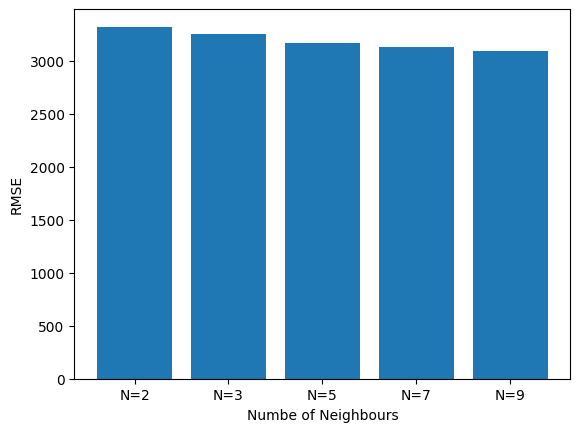

In [152]:
D = {'N=2':3322.518623791772,'N=3':3256.6557735051415,'N=5':3171.1417554308155,'N=7':3126.4909091631816,'N=9':3095.803650314192}
plt.bar(range(len(D)), list(D.values()), align='center')
plt.ylabel('RMSE')
plt.xlabel('Numbe of Neighbours')
plt.xticks(range(len(D)), list(D.keys()))
plt.show()

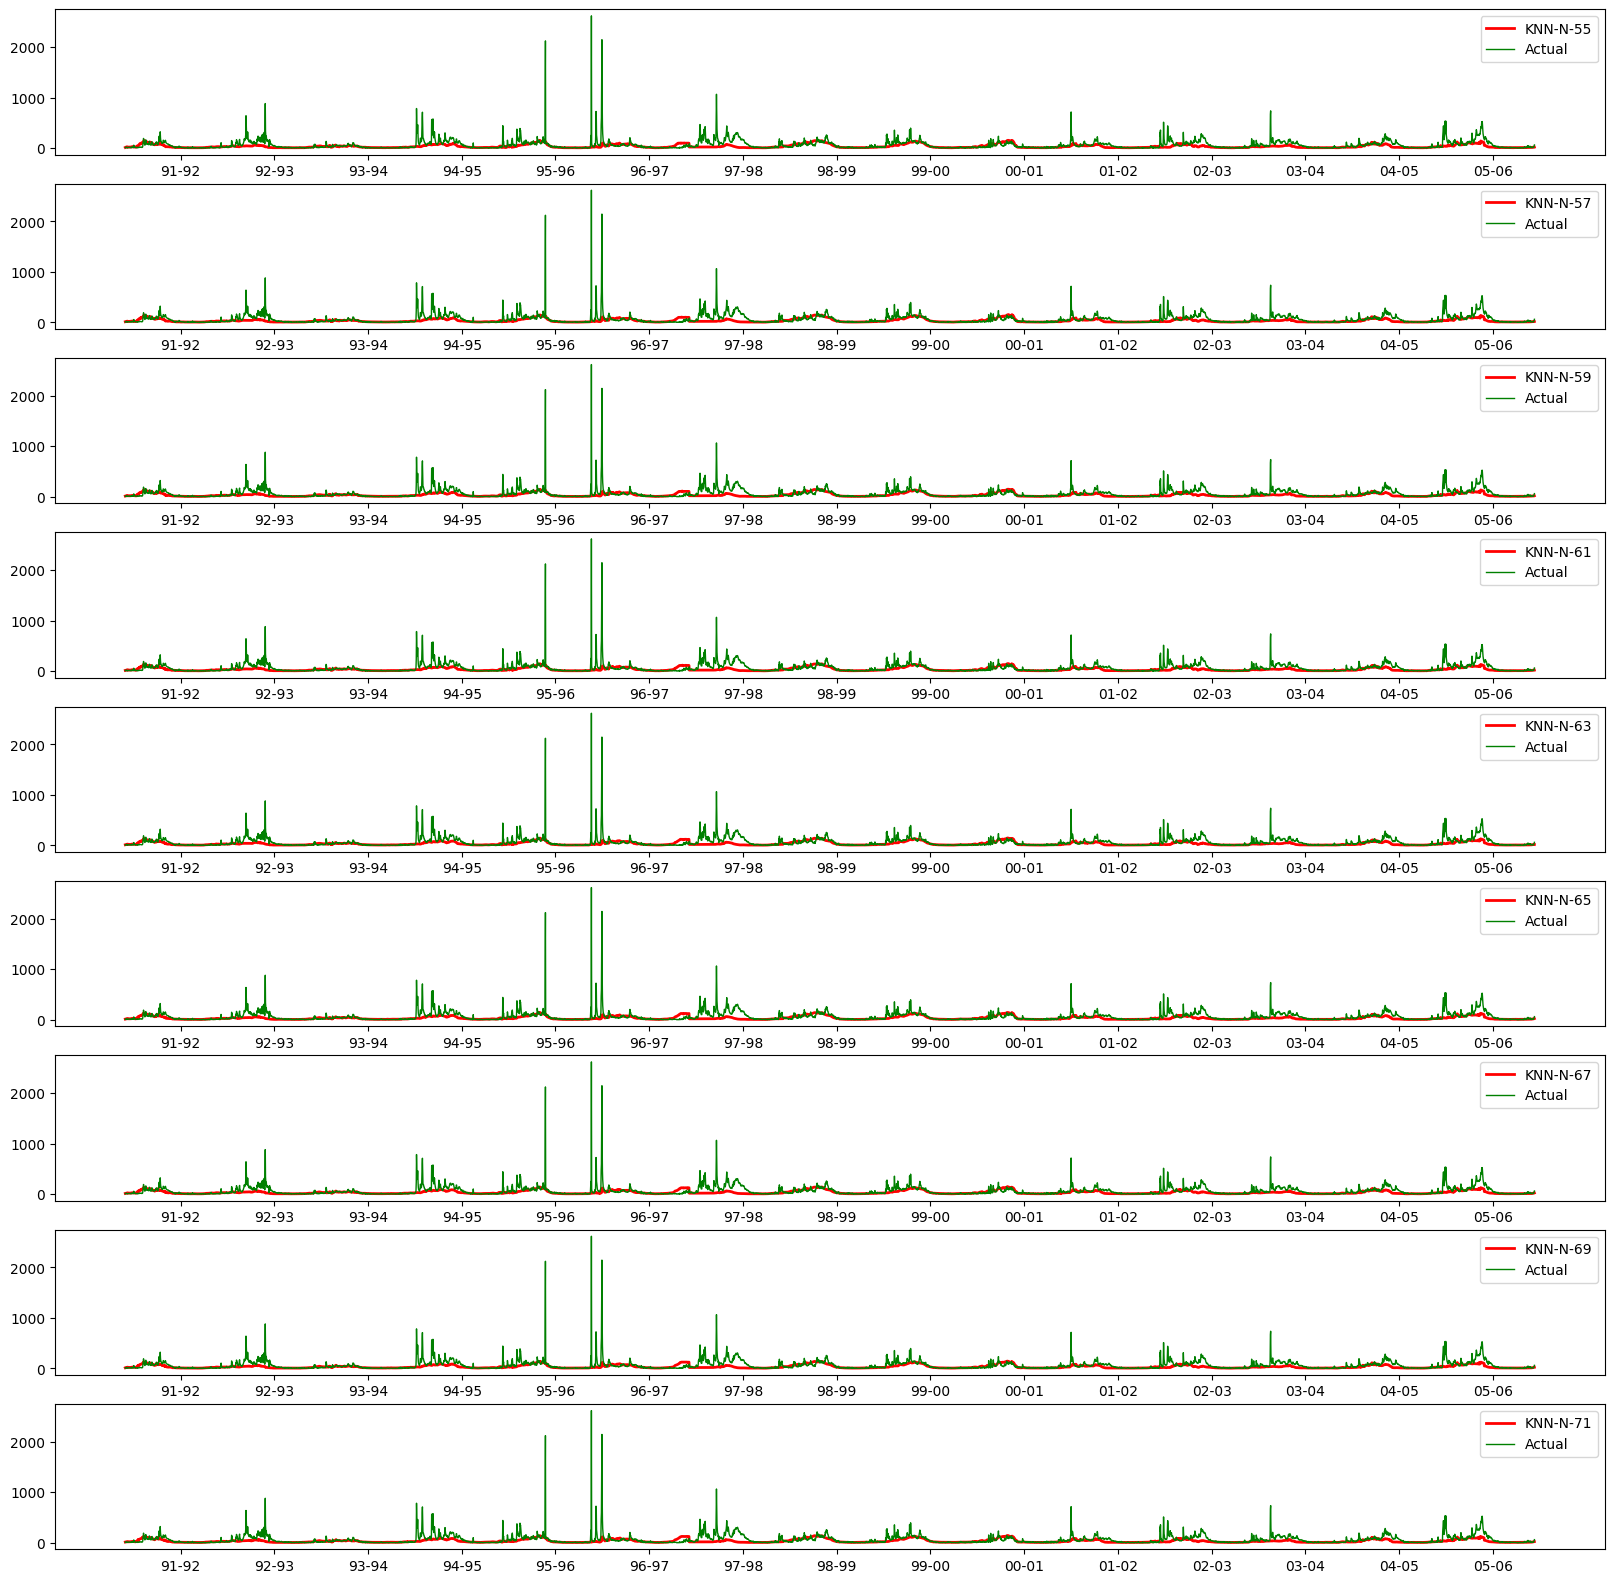

In [153]:
fig,ax = plt.subplots(9,1,figsize=(20,20))
plt.setp(ax, xticks=np.arange(215,5488,step=365),xticklabels=['91-92','92-93','93-94','94-95','95-96','96-97','97-98','98-99','99-00','00-01','01-02','02-03','03-04','04-05','05-06'])
ax[0].plot(p_knn_55,"red",label='KNN-N-55',linewidth=2.0)
ax[0].plot(r_knn_55,"green",label='Actual',linewidth=1.0)
ax[0].legend()
ax[1].plot(p_knn_57,"red",label='KNN-N-57',linewidth=2.0)
ax[1].plot(r_knn_57,"green",label='Actual',linewidth=1.0)
ax[1].legend()
ax[2].plot(p_knn_59,"red",label='KNN-N-59',linewidth=2.0)
ax[2].plot(r_knn_59,"green",label='Actual',linewidth=1.0)
ax[2].legend()
ax[3].plot(p_knn_61,"red",label='KNN-N-61',linewidth=2.0)
ax[3].plot(r_knn_61,"green",label='Actual',linewidth=1.0)
ax[3].legend()
ax[4].plot(p_knn_63,"red",label='KNN-N-63',linewidth=2.0)
ax[4].plot(r_knn_63,"green",label='Actual',linewidth=1.0)
ax[4].legend()
ax[5].plot(p_knn_65,"red",label='KNN-N-65',linewidth=2.0)
ax[5].plot(r_knn_65,"green",label='Actual',linewidth=1.0)
ax[5].legend()
ax[6].plot(p_knn_67,"red",label='KNN-N-67',linewidth=2.0)
ax[6].plot(r_knn_67,"green",label='Actual',linewidth=1.0)
ax[6].legend()
ax[7].plot(p_knn_69,"red",label='KNN-N-69',linewidth=2.0)
ax[7].plot(r_knn_69,"green",label='Actual',linewidth=1.0)
ax[7].legend()
ax[8].plot(p_knn_71,"red",label='KNN-N-71',linewidth=2.0)
ax[8].plot(r_knn_71,"green",label='Actual',linewidth=1.0)
ax[8].legend()
plt.show()

##Final KNN

In [154]:
knn = KNeighborsRegressor(n_neighbors=57)
kf = KFold(n_splits=15, shuffle=False)
knn_9_rmse = []
knn_9_ns = []
knn_9_corr = []
knn_9_kge = []
knn_9_r2score = []
knn_9_mae = []
predictions_knn = []
real_knn = []
for train_index, test_index in tqdm(kf.split(X_pca),total=kf.get_n_splits(),desc="k-fold"):
    X_train, X_test, y_train, y_test = X_pca[train_index], X_pca[test_index], y.iloc[train_index], y.iloc[test_index]
    knn.fit(X_train, y_train)
    y_list = knn.predict(X_test)
    y_real = []
    y_pred = []
    for i in y_test['VALUE']:
      y_real.append(i)
    for i in y_list:
      y_pred.append(i)
    y_pred = np.array(y_pred).reshape(len(y_pred))
    predictions_knn.extend(y_list)
    real_knn.extend(y_real)
    y_real = np.array(y_real)
    knn_9_rmse.append(math.sqrt(mean_squared_error(y_real, y_pred)))
    knn_9_ns.append(NS(y_real,y_pred))
    knn_9_kge.append(KGE(y_real,y_pred))
    knn_9_corr.append(correlation(y_real,y_pred))
    knn_9_r2score.append(r2_score(y_real,y_pred))
    knn_9_mae.append(mean_absolute_error(y_real,y_pred))

k-fold: 100%|██████████| 15/15 [00:04<00:00,  3.13it/s]


**Daily Accuracy**

In [155]:
print('RMSE ',mean(knn_9_rmse))
# print('NS ',mean(knn_9_ns))
# print('KGE ',mean(knn_9_kge))
print('CORR ',mean(knn_9_corr))
print('R2 Score ',mean(knn_9_r2score))
print('MAE ',mean(knn_9_mae))

RMSE  82.50444807936857
CORR  0.5501819700849914
R2 Score  0.12647426613011187
MAE  40.02257247588495


**Monthly Accuracy**

In [156]:
a = predictions_knn[24:-4]
b = real_knn[24:-4]
i = 0
p = []
r = []
while i < len(a):
  t = a[i:i+30]
  avg = sum(t)/30
  p.append(avg)
  t = b[i:i+30]
  avg = sum(t)/30
  r.append(avg)
  i = i+30
print('Monthly RMSE ',math.sqrt(mean_squared_error(p, r)))
# print('Monthly NS ',NS(np.array(r),np.array(p).reshape(len(p))))
# print('Monthly KGE ',KGE(np.array(r),np.array(p).reshape(len(p))))
print('Monthly CORR ',correlation(np.array(r),np.array(p).reshape(len(p))))
print('Monthly R2Score ',r2_score(r,p))
print('Monthly MAE', mean_absolute_error(r,p))

Monthly RMSE  60.82653150695431
Monthly CORR  0.543969049960596
Monthly R2Score  0.08604602426848962
Monthly MAE 36.11834167404157


**Monthly**

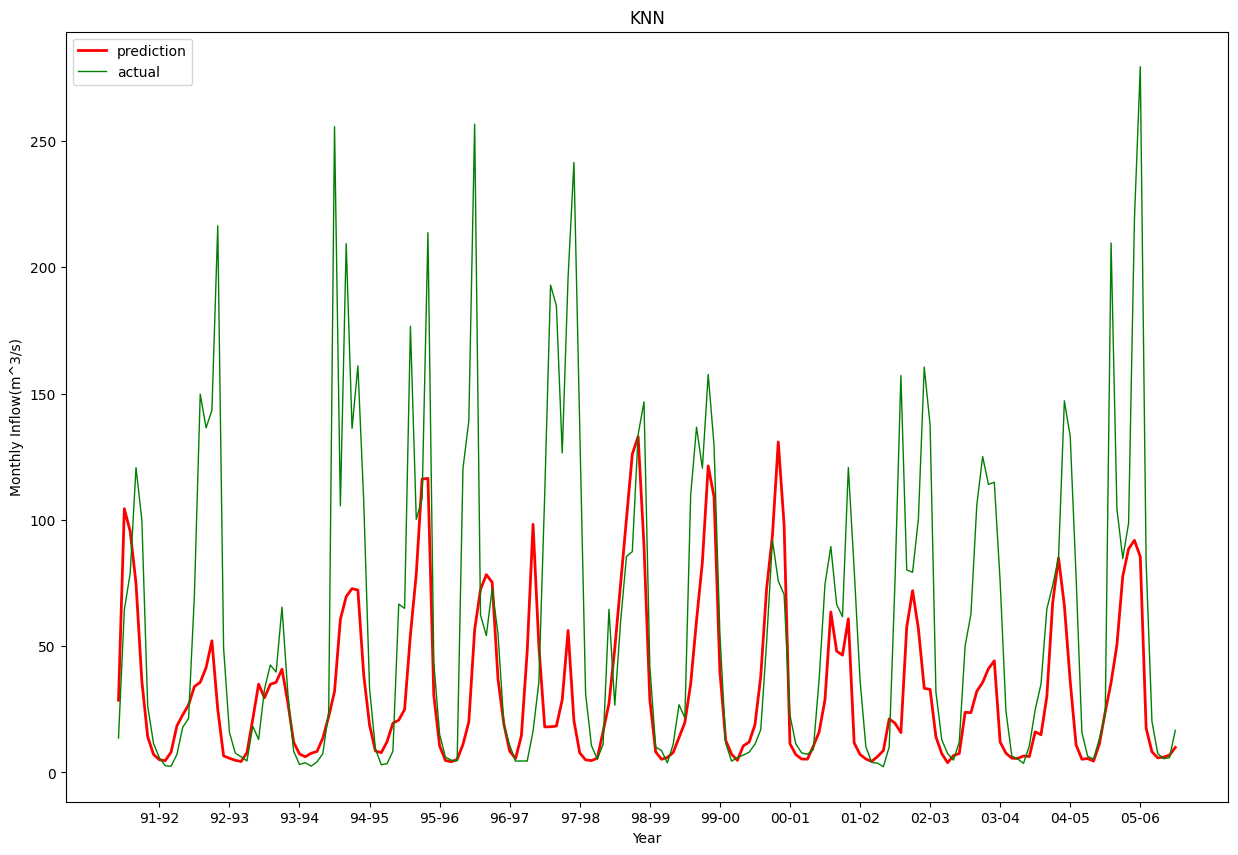

In [157]:
a = predictions_knn[24:-4]
b = real_knn[24:-4]
i = 0
p = []
r = []
while i < len(a):
  t = a[i:i+30]
  avg = sum(t)/30
  p.append(avg)
  t = b[i:i+30]
  avg = sum(t)/30
  r.append(avg)
  i = i+30
plt.figure(figsize=(15, 10))
plt.plot(p, "red", label="prediction", linewidth=2.0)
plt.plot(r, 'green', label="actual", linewidth=1.0)
plt.legend()
plt.ylabel('Monthly Inflow(m^3/s)')
plt.xlabel('Year')
plt.xticks(np.arange(7,182,step=12),['91-92','92-93','93-94','94-95','95-96','96-97','97-98','98-99','99-00','00-01','01-02','02-03','03-04','04-05','05-06'])
plt.title("KNN")
plt.show()

**Daily**

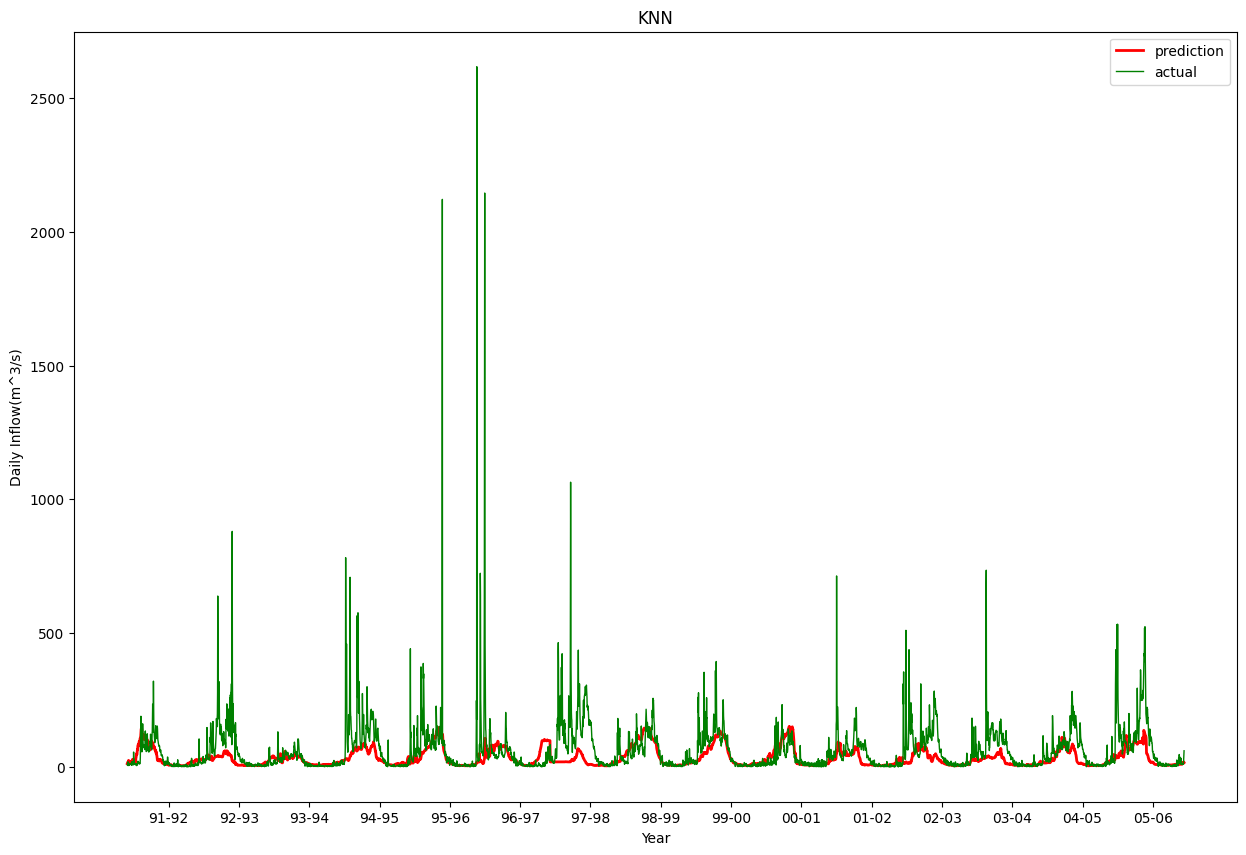

In [158]:
plt.figure(figsize=(15, 10))
plt.plot(predictions_knn, "red", label="prediction", linewidth=2.0)
plt.plot(real_knn, 'green', label="actual", linewidth=1.0)
plt.legend()
plt.ylabel('Daily Inflow(m^3/s)')
plt.xlabel('Year')
plt.xticks(np.arange(215,5488,step=365),['91-92','92-93','93-94','94-95','95-96','96-97','97-98','98-99','99-00','00-01','01-02','02-03','03-04','04-05','05-06'])
plt.title("KNN")
plt.show()

##LSTM

In [159]:
from keras.layers import Dense
from keras.layers import LSTM
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from sklearn.model_selection import train_test_split

2023-05-12 11:28:03.192001: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-12 11:28:03.346561: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-12 11:28:03.347738: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-12 11:28:04.597478: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [160]:
x_lstm = X_pca.reshape(X_pca.shape[0],1,X_pca.shape[1])

In [164]:
# print the device being used to run the code
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

# use the GPU to run LSTM
import tensorflow as tf


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9574553250246914981
xla_global_id: -1
]


2023-05-12 13:52:10.126057: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-12 13:52:10.126311: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


AttributeError: module 'tensorflow' has no attribute 'ConfigProto'

**Epochs = 30**

In [161]:
stop_noimprovement = EarlyStopping(monitor='loss', patience=10)
model = Sequential()
model.add(LSTM(units=1024, activation='relu', return_sequences=True, input_shape=(1, x_lstm.shape[2])))
model.add(LSTM(units=1024, activation='relu', return_sequences=True))
model.add(Dense(units=1,activation='relu'))
model.compile(loss='mean_squared_error', optimizer='adam')

kf = KFold(n_splits=15, shuffle=False)
score_30_rmse = []
score_30_corr = []
score_30_r2 = []
score_30_mae = []
score_30_apb = []
r_lstm_1 = []
p_lstm_1 = []
for train_index, test_index in tqdm(kf.split(x_lstm),total=kf.get_n_splits(),desc="k-fold"):
    X_train, X_test, y_train, y_test = x_lstm[train_index], x_lstm[test_index], y.iloc[train_index], y.iloc[test_index]
    lstm_history = model.fit(X_train, y_train, epochs=30, batch_size=16, validation_data=(X_test, y_test), callbacks=[stop_noimprovement], shuffle=False,verbose=False)
    yht = model.predict(X_test)
    yhat= []
    for i in yht:
      if i[0][0] < 0:
        yhat.append(0)
      else:
        yhat.append(i[0][0])
    r_lstm_1.extend(list(y_test['VALUE']))
    p_lstm_1.extend(yhat)
    yhat = np.array(yhat)
    y_test = np.array(list(y_test['VALUE']))
    score_30_rmse.append(math.sqrt(mean_squared_error(y_test, yhat)))
    score_30_corr.append(correlation(y_test,yhat))
    score_30_r2.append(r2_score(y_test,yhat))
    score_30_mae.append(mean_absolute_error(y_test,yhat))
    score_30_apb.append(Absolute_Percentage_Error(y_test,yhat))

2023-05-12 11:28:05.683984: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-12 11:28:05.684879: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
k-fold:   0%|          | 0/15 [00:00<?, ?it/s]

12/12 [==============================] - 0s 7ms/step


k-fold:   7%|▋         | 1/15 [28:43<6:42:14, 1723.88s/it]

12/12 [==============================] - 0s 8ms/step


k-fold:  13%|█▎        | 2/15 [46:40<4:51:02, 1343.27s/it]

12/12 [==============================] - 0s 8ms/step


k-fold:  20%|██        | 3/15 [1:02:54<3:54:52, 1174.36s/it]

12/12 [==============================] - 0s 7ms/step


k-fold:  27%|██▋       | 4/15 [1:19:40<3:23:10, 1108.25s/it]

12/12 [==============================] - 0s 8ms/step


k-fold:  33%|███▎      | 5/15 [1:31:57<2:42:22, 974.23s/it] 

12/12 [==============================] - 0s 13ms/step


k-fold:  40%|████      | 6/15 [2:00:33<3:03:58, 1226.45s/it]

12/12 [==============================] - 0s 13ms/step


k-fold:  47%|████▋     | 7/15 [2:22:51<2:43:16, 1224.56s/it]


KeyboardInterrupt: 

In [ ]:
lstm_30 = pd.DataFrame({'actual':r_lstm_1,'predict':p_lstm_1})
lstm_30.to_csv('lstm_30.csv')

In [ ]:
print('RMSE ',mean(score_30_rmse))
print('CORR ',mean(score_30_corr))
print('R2 ',mean(score_30_r2))
print('MAE ',mean(score_30_mae))
print('APB ',mean(score_30_apb))

RMSE  14.104986391099834
CORR  0.9814673746131882
R2  0.9462222871399577
MAE  7.084637510522924
APB  12.391112371955087


**N=40**

In [ ]:
stop_noimprovement = EarlyStopping(monitor='loss', patience=10)
model = Sequential()
model.add(LSTM(units=1024, activation='relu', return_sequences=True, input_shape=(1, x_lstm.shape[2])))
model.add(LSTM(units=1024, activation='relu', return_sequences=True))
model.add(Dense(units=1,activation='relu'))
model.compile(loss='mean_squared_error', optimizer='adam')

kf = KFold(n_splits=15, shuffle=False)
score_40_rmse = []
score_40_corr = []
score_40_r2 = []
score_40_mae = []
score_40_apb = []
r_lstm_2 = []
p_lstm_2 = []
for train_index, test_index in tqdm(kf.split(x_lstm),total=kf.get_n_splits(),desc="k-fold"):
    X_train, X_test, y_train, y_test = x_lstm[train_index], x_lstm[test_index], y.iloc[train_index], y.iloc[test_index]
    lstm_history = model.fit(X_train, y_train, epochs=40, batch_size=16, validation_data=(X_test, y_test), callbacks=[stop_noimprovement], shuffle=False,verbose=False)
    yht = model.predict(X_test)
    yhat= []
    for i in yht:
      if i[0][0] < 0:
        yhat.append(0)
      else:
        yhat.append(i[0][0])
    r_lstm_2.extend(list(y_test['VALUE']))
    p_lstm_2.extend(yhat)
    yhat = np.array(yhat)
    y_test = np.array(list(y_test['VALUE']))
    score_40_rmse.append(math.sqrt(mean_squared_error(y_test, yhat)))
    score_40_corr.append(correlation(y_test,yhat))
    score_40_r2.append(r2_score(y_test,yhat))
    score_40_mae.append(mean_absolute_error(y_test,yhat))
    score_40_apb.append(Absolute_Percentage_Error(y_test,yhat))

k-fold: 100%|██████████| 15/15 [17:37<00:00, 70.52s/it]


In [ ]:
lstm_40 = pd.DataFrame({'actual':r_lstm_2,'predict':p_lstm_2})
lstm_40.to_csv('lstm_40.csv')

In [ ]:
print('RMSE ',mean(score_40_rmse))
print('CORR ',mean(score_40_corr))
print('R2 ',mean(score_40_r2))
print('MAE ',mean(score_40_mae))
print('APB ',mean(score_40_apb))

RMSE  11.552205616066207
CORR  0.9711769776516977
R2  0.939294533861109
MAE  7.002614403135711
APB  14.69146241992887


**Epochs = 50**

In [ ]:
stop_noimprovement = EarlyStopping(monitor='loss', patience=10)
model = Sequential()
model.add(LSTM(units=1024, activation='relu', return_sequences=True, input_shape=(1, x_lstm.shape[2])))
model.add(LSTM(units=1024, activation='relu', return_sequences=True))
model.add(Dense(units=1,activation='relu'))
model.compile(loss='mean_squared_error', optimizer='adam')

kf = KFold(n_splits=15, shuffle=False)
score_50_rmse = []
score_50_corr = []
score_50_r2 = []
score_50_mae = []
score_50_apb =[]
r_lstm_3 = []
p_lstm_3 = []
for train_index, test_index in tqdm(kf.split(x_lstm),total=kf.get_n_splits(),desc="k-fold"):
    X_train, X_test, y_train, y_test = x_lstm[train_index], x_lstm[test_index], y.iloc[train_index], y.iloc[test_index]
    lstm_history = model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test), callbacks=[stop_noimprovement], shuffle=False,verbose=False)
    yht = model.predict(X_test)
    yhat= []
    for i in yht:
      if i[0][0] < 0:
        yhat.append(0)
      else:
        yhat.append(i[0][0])
    r_lstm_3.extend(list(y_test['VALUE']))
    p_lstm_3.extend(yhat)
    yhat = np.array(yhat)
    y_test = np.array(list(y_test['VALUE']))
    score_50_rmse.append(math.sqrt(mean_squared_error(y_test, yhat)))
    score_50_corr.append(correlation(y_test,yhat))
    score_50_r2.append(r2_score(y_test,yhat))
    score_50_mae.append(mean_absolute_error(y_test,yhat))
    score_50_apb.append(Absolute_Percentage_Error(y_test,yhat))

k-fold: 100%|██████████| 15/15 [16:36<00:00, 66.44s/it]


In [ ]:
lstm_50 = pd.DataFrame({'actual':r_lstm_3,'predict':p_lstm_3})
lstm_50.to_csv('lstm_50.csv')

In [ ]:
print('RMSE ',mean(score_50_rmse))
print('CORR ',mean(score_50_corr))
print('R2 ',mean(score_50_r2))
print('MAE ',mean(score_50_mae))
print('APB ',mean(score_50_apb))

RMSE  11.387174743012038
CORR  0.9798431236047463
R2  0.9309749741040146
MAE  6.535349794101615
APB  11.587287702806366


**N=60**

In [ ]:
stop_noimprovement = EarlyStopping(monitor='loss', patience=10)
model = Sequential()
model.add(LSTM(units=1024, activation='relu', return_sequences=True, input_shape=(1, x_lstm.shape[2])))
model.add(LSTM(units=1024, activation='relu', return_sequences=True))
model.add(Dense(units=1,activation='relu'))
model.compile(loss='mean_squared_error', optimizer='adam')

kf = KFold(n_splits=15, shuffle=False)
score_60_rmse = []
score_60_corr = []
score_60_r2 = []
score_60_mae = []
score_60_apb = []
r_lstm_4 = []
p_lstm_4 = []
for train_index, test_index in tqdm(kf.split(x_lstm),total=kf.get_n_splits(),desc="k-fold"):
    X_train, X_test, y_train, y_test = x_lstm[train_index], x_lstm[test_index], y.iloc[train_index], y.iloc[test_index]
    lstm_history = model.fit(X_train, y_train, epochs=60, batch_size=16, validation_data=(X_test, y_test), callbacks=[stop_noimprovement], shuffle=False,verbose=False)
    yht = model.predict(X_test)
    yhat= []
    for i in yht:
      if i[0][0] < 0:
        yhat.append(0)
      else:
        yhat.append(i[0][0])
    r_lstm_4.extend(list(y_test['VALUE']))
    p_lstm_4.extend(yhat)
    yhat = np.array(yhat)
    y_test = np.array(list(y_test['VALUE']))
    score_60_rmse.append(math.sqrt(mean_squared_error(y_test, yhat)))
    score_60_corr.append(correlation(y_test,yhat))
    score_60_r2.append(r2_score(y_test,yhat))
    score_60_mae.append(mean_absolute_error(y_test,yhat))
    score_60_apb.append(Absolute_Percentage_Error(y_test,yhat))

k-fold: 100%|██████████| 15/15 [17:17<00:00, 69.20s/it]


In [ ]:
lstm_60 = pd.DataFrame({'actual':r_lstm_4,'predict':p_lstm_4})
lstm_60.to_csv('lstm_60.csv')

In [ ]:
print('RMSE ',mean(score_60_rmse))
print('CORR ',mean(score_60_corr))
print('R2 ',mean(score_60_r2))
print('MAE ',mean(score_60_mae))
print('APB ',mean(score_60_apb))

RMSE  12.949607202576196
CORR  0.9733951315776126
R2  0.9258412562106637
MAE  7.866508022268082
APB  13.730922540915605


**Epoch = 70**

In [ ]:
stop_noimprovement = EarlyStopping(monitor='loss', patience=10)
model = Sequential()
model.add(LSTM(units=1024, activation='relu', return_sequences=True, input_shape=(1, x_lstm.shape[2])))
model.add(LSTM(units=1024, activation='relu', return_sequences=True))
model.add(Dense(units=1,activation='relu'))
model.compile(loss='mean_squared_error', optimizer='adam')

kf = KFold(n_splits=15, shuffle=False)
score_70_rmse = []
score_70_corr = []
score_70_r2 = []
score_70_mae = []
score_70_apb = []
r_lstm_5 = []
p_lstm_5 = []
for train_index, test_index in tqdm(kf.split(x_lstm),total=kf.get_n_splits(),desc="k-fold"):
    X_train, X_test, y_train, y_test = x_lstm[train_index], x_lstm[test_index], y.iloc[train_index], y.iloc[test_index]
    lstm_history = model.fit(X_train, y_train, epochs=70, batch_size=16, validation_data=(X_test, y_test), callbacks=[stop_noimprovement], shuffle=False,verbose=False)
    yht = model.predict(X_test)
    yhat= []
    for i in yht:
      if i[0][0] < 0:
        yhat.append(0)
      else:
        yhat.append(i[0][0])
    r_lstm_5.extend(list(y_test['VALUE']))
    p_lstm_5.extend(yhat)
    yhat = np.array(yhat)
    y_test = np.array(list(y_test['VALUE']))
    score_70_rmse.append(math.sqrt(mean_squared_error(y_test, yhat)))
    score_70_corr.append(correlation(y_test,yhat))
    score_70_r2.append(r2_score(y_test,yhat))
    score_70_mae.append(mean_absolute_error(y_test,yhat))
    score_70_apb.append(Absolute_Percentage_Error(y_test,yhat))

k-fold: 100%|██████████| 15/15 [16:16<00:00, 65.13s/it]


In [ ]:
lstm_70 = pd.DataFrame({'actual':r_lstm_5,'predict':p_lstm_5})
lstm_70.to_csv('lstm_70.csv')

In [ ]:
print('RMSE ',mean(score_70_rmse))
print('CORR ',mean(score_70_corr))
print('R2 ',mean(score_70_r2))
print('MAE ',mean(score_70_mae))
print('APB ',mean(score_70_apb))

RMSE  10.961268011466156
CORR  0.9837038780222491
R2  0.9459208663084174
MAE  6.217080385194242
APB  10.425938794343935


**N=80**

In [ ]:
stop_noimprovement = EarlyStopping(monitor='loss', patience=10)
model = Sequential()
model.add(LSTM(units=1024, activation='relu', return_sequences=True, input_shape=(1, x_lstm.shape[2])))
model.add(LSTM(units=1024, activation='relu', return_sequences=True))
model.add(Dense(units=1,activation='relu'))
model.compile(loss='mean_squared_error', optimizer='adam')

kf = KFold(n_splits=15, shuffle=False)
score_80_rmse = []
score_80_corr = []
score_80_r2 = []
score_80_mae = []
score_80_apb = []
r_lstm_6 = []
p_lstm_6 = []
for train_index, test_index in tqdm(kf.split(x_lstm),total=kf.get_n_splits(),desc="k-fold"):
    X_train, X_test, y_train, y_test = x_lstm[train_index], x_lstm[test_index], y.iloc[train_index], y.iloc[test_index]
    lstm_history = model.fit(X_train, y_train, epochs=80, batch_size=16, validation_data=(X_test, y_test), callbacks=[stop_noimprovement], shuffle=False,verbose=False)
    yht = model.predict(X_test)
    yhat= []
    for i in yht:
      if i[0][0] < 0:
        yhat.append(0)
      else:
        yhat.append(i[0][0])
    r_lstm_6.extend(list(y_test['VALUE']))
    p_lstm_6.extend(yhat)
    yhat = np.array(yhat)
    y_test = np.array(list(y_test['VALUE']))
    score_80_rmse.append(math.sqrt(mean_squared_error(y_test, yhat)))
    score_80_corr.append(correlation(y_test,yhat))
    score_80_r2.append(r2_score(y_test,yhat))
    score_80_mae.append(mean_absolute_error(y_test,yhat))
    score_80_apb.append(Absolute_Percentage_Error(y_test,yhat))

k-fold: 100%|██████████| 15/15 [14:52<00:00, 59.48s/it]


In [ ]:
lstm_80 = pd.DataFrame({'actual':r_lstm_6,'predict':p_lstm_6})
lstm_80.to_csv('lstm_80.csv')

In [ ]:
print('RMSE ',mean(score_80_rmse))
print('CORR ',mean(score_80_corr))
print('R2 ',mean(score_80_r2))
print('MAE ',mean(score_80_mae))
print('APB ',mean(score_80_apb))

RMSE  10.407381805871609
CORR  0.9802682724537158
R2  0.9461045844876224
MAE  5.752643606322842
APB  9.588365977604576


**N=90**

In [ ]:
stop_noimprovement = EarlyStopping(monitor='loss', patience=10)
model = Sequential()
model.add(LSTM(units=1024, activation='relu', return_sequences=True, input_shape=(1, x_lstm.shape[2])))
model.add(LSTM(units=1024, activation='relu', return_sequences=True))
model.add(Dense(units=1,activation='relu'))
model.compile(loss='mean_squared_error', optimizer='adam')

kf = KFold(n_splits=15, shuffle=False)
score_90_rmse = []
score_90_corr = []
score_90_r2 = []
score_90_mae = []
score_90_apb = []
r_lstm_7 = []
p_lstm_7 = []
for train_index, test_index in tqdm(kf.split(x_lstm),total=kf.get_n_splits(),desc="k-fold"):
    X_train, X_test, y_train, y_test = x_lstm[train_index], x_lstm[test_index], y.iloc[train_index], y.iloc[test_index]
    lstm_history = model.fit(X_train, y_train, epochs=90, batch_size=16, validation_data=(X_test, y_test), callbacks=[stop_noimprovement], shuffle=False,verbose=False)
    yht = model.predict(X_test)
    yhat= []
    for i in yht:
      if i[0][0] < 0:
        yhat.append(0)
      else:
        yhat.append(i[0][0])
    r_lstm_7.extend(list(y_test['VALUE']))
    p_lstm_7.extend(yhat)
    yhat = np.array(yhat)
    y_test = np.array(list(y_test['VALUE']))
    score_90_rmse.append(math.sqrt(mean_squared_error(y_test, yhat)))
    score_90_corr.append(correlation(y_test,yhat))
    score_90_r2.append(r2_score(y_test,yhat))
    score_90_mae.append(mean_absolute_error(y_test,yhat))
    score_90_apb.append(Absolute_Percentage_Error(y_test,yhat))

k-fold: 100%|██████████| 15/15 [15:20<00:00, 61.38s/it]


In [ ]:
lstm_90 = pd.DataFrame({'actual':r_lstm_7,'predict':p_lstm_7})
lstm_90.to_csv('lstm_90.csv')

In [ ]:
print('RMSE ',mean(score_90_rmse))
print('CORR ',mean(score_90_corr))
print('R2 ',mean(score_90_r2))
print('MAE ',mean(score_90_mae))
print('APB ',mean(score_90_apb))

RMSE  13.64194359512008
CORR  0.9752404845931203
R2  0.9454747238339093
MAE  6.742757919377353
APB  11.974159698963472


**Epoch = 100**

In [ ]:
stop_noimprovement = EarlyStopping(monitor='loss', patience=10)
model = Sequential()
model.add(LSTM(units=1024, activation='relu', return_sequences=True, input_shape=(1, x_lstm.shape[2])))
model.add(LSTM(units=1024, activation='relu', return_sequences=True))
model.add(Dense(units=1,activation='relu'))
model.compile(loss='mean_squared_error', optimizer='adam')

kf = KFold(n_splits=15, shuffle=False)
score_100_rmse = []
score_100_corr = []
score_100_r2 = []
score_100_mae = []
score_100_apb = []
r_lstm_8 = []
p_lstm_8 = []
for train_index, test_index in tqdm(kf.split(x_lstm),total=kf.get_n_splits(),desc="k-fold"):
    X_train, X_test, y_train, y_test = x_lstm[train_index], x_lstm[test_index], y.iloc[train_index], y.iloc[test_index]
    lstm_history = model.fit(X_train, y_train, epochs=100, batch_size=16, validation_data=(X_test, y_test), callbacks=[stop_noimprovement], shuffle=False,verbose=False)
    yht = model.predict(X_test)
    yhat= []
    for i in yht:
      if i[0][0] < 0:
        yhat.append(0)
      else:
        yhat.append(i[0][0])
    r_lstm_8.extend(list(y_test['VALUE']))
    p_lstm_8.extend(yhat)
    yhat = np.array(yhat)
    y_test = np.array(list(y_test['VALUE']))
    score_100_rmse.append(math.sqrt(mean_squared_error(y_test, yhat)))
    score_100_corr.append(correlation(y_test,yhat))
    score_100_r2.append(r2_score(y_test,yhat))
    score_100_mae.append(mean_absolute_error(y_test,yhat))
    score_100_apb.append(Absolute_Percentage_Error(y_test,yhat))

k-fold: 100%|██████████| 15/15 [17:41<00:00, 70.78s/it]


In [ ]:
lstm_100 = pd.DataFrame({'actual':r_lstm_8,'predict':p_lstm_8})
lstm_100.to_csv('lstm_100.csv')

In [ ]:
print('RMSE ',mean(score_100_rmse))
print('CORR ',mean(score_100_corr))
print('R2 ',mean(score_100_r2))
print('MAE ',mean(score_100_mae))
print('APB ',mean(score_100_apb))

RMSE  13.58734127144887
CORR  0.9826113631745932
R2  0.9291545578700987
MAE  7.899578126143909
APB  12.72615360655141


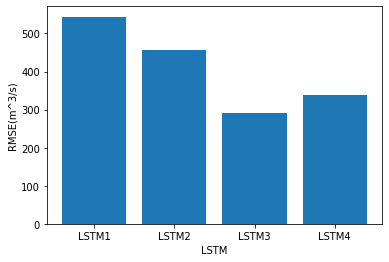

In [ ]:
D = {'LSTM1':543.9768419315196,'LSTM2':456.5707681714717,'LSTM3':292.1108931957561,'LSTM4':339.3957034619337}
plt.bar(range(len(D)), list(D.values()), align='center')
plt.ylabel('RMSE(m^3/s)')
plt.xlabel('LSTM')
plt.xticks(range(len(D)), list(D.keys()))
plt.show()

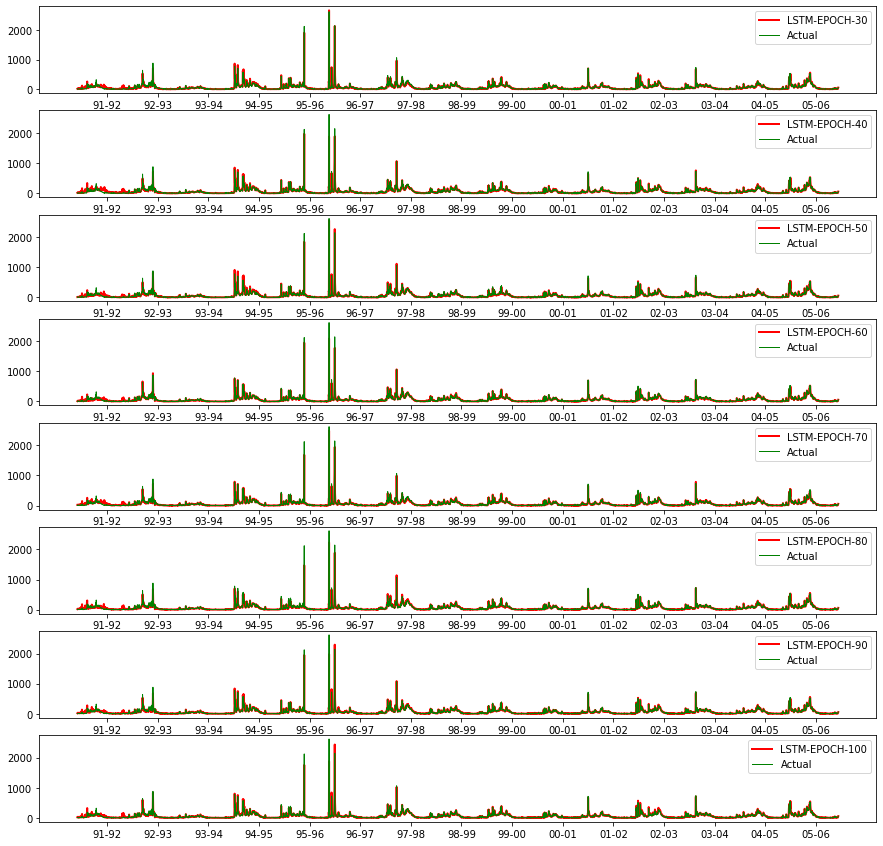

In [ ]:
fig,ax = plt.subplots(8,1,figsize=(15,15))
plt.setp(ax, xticks=np.arange(215,5488,step=365),xticklabels=['91-92','92-93','93-94','94-95','95-96','96-97','97-98','98-99','99-00','00-01','01-02','02-03','03-04','04-05','05-06'])
ax[0].plot(p_lstm_1,"red",label='LSTM-EPOCH-30',linewidth=2.0)
ax[0].plot(r_lstm_1,"green",label='Actual',linewidth=1.0)
ax[0].legend()
ax[1].plot(p_lstm_2,"red",label='LSTM-EPOCH-40',linewidth=2.0)
ax[1].plot(r_lstm_2,"green",label='Actual',linewidth=1.0)
ax[1].legend()
ax[2].plot(p_lstm_3,"red",label='LSTM-EPOCH-50',linewidth=2.0)
ax[2].plot(r_lstm_3,"green",label='Actual',linewidth=1.0)
ax[2].legend()
ax[3].plot(p_lstm_4,"red",label='LSTM-EPOCH-60',linewidth=2.0)
ax[3].plot(r_lstm_4,"green",label='Actual',linewidth=1.0)
ax[3].legend()
ax[4].plot(p_lstm_5,"red",label='LSTM-EPOCH-70',linewidth=2.0)
ax[4].plot(r_lstm_5,"green",label='Actual',linewidth=1.0)
ax[4].legend()
ax[5].plot(p_lstm_6,"red",label='LSTM-EPOCH-80',linewidth=2.0)
ax[5].plot(r_lstm_6,"green",label='Actual',linewidth=1.0)
ax[5].legend()
ax[6].plot(p_lstm_7,"red",label='LSTM-EPOCH-90',linewidth=2.0)
ax[6].plot(r_lstm_7,"green",label='Actual',linewidth=1.0)
ax[6].legend()
ax[7].plot(p_lstm_8,"red",label='LSTM-EPOCH-100',linewidth=2.0)
ax[7].plot(r_lstm_8,"green",label='Actual',linewidth=1.0)
ax[7].legend()
plt.show()

##Final LSTM

In [ ]:
stop_noimprovement = EarlyStopping(monitor='loss', patience=10)
model = Sequential()
model.add(LSTM(units=1024, activation='relu',return_sequences=True, input_shape=(1, x_lstm.shape[2])))
model.add(LSTM(units=1024,activation='relu', return_sequences=True))
model.add(Dense(units=1,activation='relu'))
model.compile(loss='mean_squared_error', optimizer='adam')

kf = KFold(n_splits=15, shuffle=False)
score_90_rmse = []
score_90_corr = []
score_90_r2 = []
score_90_mae = []
predictions_lstm = []
real_lstm= []
for train_index, test_index in tqdm(kf.split(x_lstm),total=kf.get_n_splits(),desc="k-fold"):
    X_train, X_test, y_train, y_test = x_lstm[train_index], x_lstm[test_index], y.iloc[train_index], y.iloc[test_index]
    lstm_history = model.fit(X_train, y_train, epochs=80, batch_size=16, validation_data=(X_test, y_test), callbacks=[stop_noimprovement], shuffle=False, verbose=False)
    yht = model.predict(X_test)
    yhat= []
    for i in yht:
      yhat.append(i[0][0])
    predictions_lstm.extend(yhat)
    real_lstm.extend(list(y_test['VALUE']))
    yhat = np.array(yhat)
    y_test = np.array(list(y_test['VALUE']))
    score_90_rmse.append(math.sqrt(mean_squared_error(y_test, yhat)))
    score_90_corr.append(correlation(y_test,yhat))
    score_90_r2.append(r2_score(y_test,yhat))
    score_90_mae.append(mean_absolute_error(y_test,yhat))



k-fold:   0%|          | 0/15 [00:00<?, ?it/s]

k-fold:   7%|▋         | 1/15 [02:32<35:37, 152.69s/it]

k-fold:  13%|█▎        | 2/15 [03:35<27:13, 125.65s/it]

k-fold:  20%|██        | 3/15 [04:00<19:06, 95.55s/it] 

k-fold:  27%|██▋       | 4/15 [04:42<14:34, 79.51s/it]

k-fold:  33%|███▎      | 5/15 [05:06<10:26, 62.67s/it]

k-fold:  40%|████      | 6/15 [05:37<08:01, 53.45s/it]

k-fold:  47%|████▋     | 7/15 [06:11<06:20, 47.52s/it]

k-fold:  53%|█████▎    | 8/15 [06:49<05:12, 44.58s/it]

k-fold:  60%|██████    | 9/15 [07:42<04:42, 47.01s/it]

k-fold:  67%|██████▋   | 10/15 [08:20<03:41, 44.31s/it]

k-fold:  73%|███████▎  | 11/15 [09:08<03:02, 45.55s/it]

k-fold:  80%|████████  | 12/15 [09:38<02:02, 40.77s/it]

k-fold:  87%|████████▋ | 13/15 [10:21<01:23, 41.57s/it]

k-fold:  93%|█████████▎| 14/15 [10:45<00:36, 36.21s/it]

k-fold: 100%|██████████| 15/15 [11:25<00:00, 45.71s/it]


**Daily Accuracy**

In [ ]:
print('RMSE ',mean(score_90_rmse))
print('CORR ',mean(score_90_corr))
print('R2 ',mean(score_90_r2))
print('MAE ',mean(score_90_mae))

RMSE  368.2463006183866
CORR  0.9676831846905508
R2  0.9257012810130537
MAE  226.16057128250335


**Monthly Accuracy**

In [ ]:
a = predictions_lstm[24:-4]
b = real_lstm[24:-4]
i = 0
p = []
r = []
while i < len(a):
  t = a[i:i+30]
  avg = sum(t)/30
  p.append(avg)
  t = b[i:i+30]
  avg = sum(t)/30
  r.append(avg)
  i = i+30
print('Monthly RMSE ',math.sqrt(mean_squared_error(p, r)))
print('Monthly CORR ',correlation(np.array(p),np.array(r)))
print('Monthly R2 ',r2_score(p,r))
print('Monthly MAE ',mean_absolute_error(p,r))

Monthly RMSE  407.8615739971226
Monthly CORR  0.9860037566497291
Monthly R2  0.9615739083143604
Monthly MAE  196.16391938483758


**Monthly**

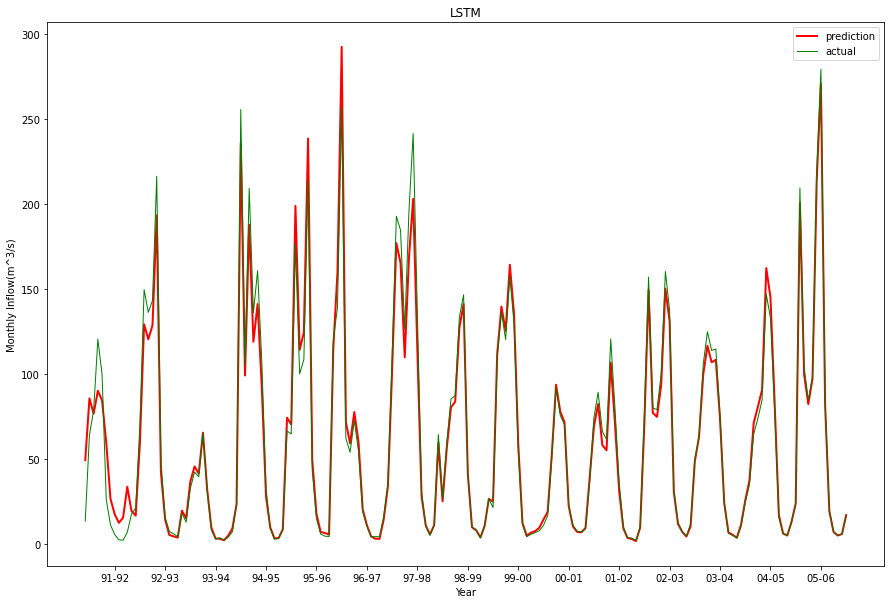

In [ ]:
a = predictions_lstm[24:-4]
b = real_lstm[24:-4]
i = 0
p = []
r = []
while i < len(a):
  t = a[i:i+30]
  avg = sum(t)/30
  p.append(avg)
  t = b[i:i+30]
  avg = sum(t)/30
  r.append(avg)
  i = i+30
plt.figure(figsize=(15, 10))
plt.plot(p, "red", label="prediction", linewidth=2.0)
plt.plot(r, 'green', label="actual", linewidth=1.0)
plt.legend()
plt.ylabel('Monthly Inflow(m^3/s)')
plt.xlabel('Year')
plt.xticks(np.arange(7,182,step=12),['91-92','92-93','93-94','94-95','95-96','96-97','97-98','98-99','99-00','00-01','01-02','02-03','03-04','04-05','05-06'])
plt.title("LSTM")
plt.show()

**Daily**

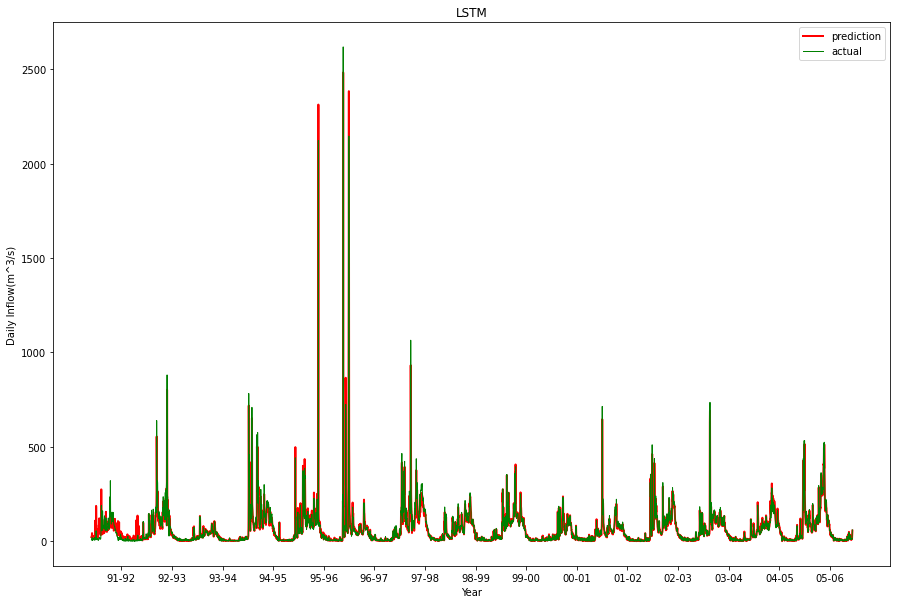

In [ ]:
plt.figure(figsize=(15, 10))
plt.plot(predictions_lstm, "red", label="prediction", linewidth=2.0)
plt.plot(real_lstm, 'green', label="actual", linewidth=1.0)
plt.legend()
plt.ylabel('Daily Inflow(m^3/s)')
plt.xlabel('Year')
plt.xticks(np.arange(215,5488,step=365),['91-92','92-93','93-94','94-95','95-96','96-97','97-98','98-99','99-00','00-01','01-02','02-03','03-04','04-05','05-06'])
plt.title("LSTM")
plt.show()

##Overall Comparison

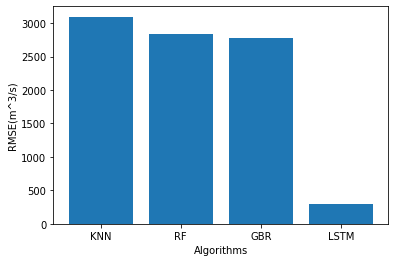

In [ ]:
D = {'KNN':3095.803650314192,'RF':2839.750828563568,'GBR':2775.260003572779,'LSTM':302.45617875012897}
plt.bar(range(len(D)), list(D.values()), align='center')
plt.ylabel('RMSE(m^3/s)')
plt.xlabel('Algorithms')
plt.xticks(range(len(D)), list(D.keys()))
plt.show()

##Experiments

In [ ]:
gbr_100_10 = pd.read_csv('/content/data/gbr_100_10.csv')
gbr_100_15 = pd.read_csv('/content/data/gbr_100_15.csv')
gbr_200_10 = pd.read_csv('/content/data/gbr_200_10.csv')
gbr_200_15 = pd.read_csv('/content/data/gbr_200_15.csv')
gbr_300_10 = pd.read_csv('/content/data/gbr_300_10.csv')
gbr_300_15 = pd.read_csv('/content/data/gbr_300_15.csv')
gbr_400_10 = pd.read_csv('/content/data/gbr_400_10.csv')
gbr_400_15 = pd.read_csv('/content/data/gbr_400_15.csv')
gbr_500_10 = pd.read_csv('/content/data/gbr_500_10.csv')
gbr_500_15 = pd.read_csv('/content/data/gbr_500_15.csv')
knn_55 = pd.read_csv('/content/data/knn_55.csv')
knn_57 = pd.read_csv('/content/data/knn_57.csv')
knn_59 = pd.read_csv('/content/data/knn_59.csv')
knn_61 = pd.read_csv('/content/data/knn_61.csv')
knn_63 = pd.read_csv('/content/data/knn_63.csv')
knn_65 = pd.read_csv('/content/data/knn_65.csv')
knn_67 = pd.read_csv('/content/data/knn_67.csv')
knn_69 = pd.read_csv('/content/data/knn_69.csv')
knn_71 = pd.read_csv('/content/data/knn_71.csv')
lstm_30 = pd.read_csv('/content/data/lstm_30.csv')
lstm_40 = pd.read_csv('/content/data/lstm_40.csv')
lstm_50 = pd.read_csv('/content/data/lstm_50.csv')
lstm_60 = pd.read_csv('/content/data/lstm_60.csv')
lstm_70 = pd.read_csv('/content/data/lstm_70.csv')
lstm_80 = pd.read_csv('/content/data/lstm_80.csv')
lstm_90 = pd.read_csv('/content/data/lstm_90.csv')
lstm_100 = pd.read_csv('/content/data/lstm_100.csv')
rf_500_29 = pd.read_csv('/content/data/rf_500_29.csv')
rf_500_31 = pd.read_csv('/content/data/rf_500_31.csv')
rf_600_29 = pd.read_csv('/content/data/rf_600_29.csv')
rf_600_31 = pd.read_csv('/content/data/rf_600_31.csv')
rf_700_29 = pd.read_csv('/content/data/rf_700_29.csv')
rf_700_31 = pd.read_csv('/content/data/rf_700_31.csv')
rf_800_29 = pd.read_csv('/content/data/rf_800_29.csv')
rf_800_31 = pd.read_csv('/content/data/rf_800_31.csv')
rf_900_29 = pd.read_csv('/content/data/rf_900_29.csv')
rf_900_31 = pd.read_csv('/content/data/rf_900_31.csv')
rf_1000_29 = pd.read_csv('/content/data/rf_1000_29.csv')
rf_1000_31 = pd.read_csv('/content/data/rf_1000_31.csv')

##Monthly Comparison

##GBR

In [ ]:
a_gbr_100_10 = []
p_gbr_100_10 = []
a_gbr_100_15 = []
p_gbr_100_15 = []
a_gbr_200_10 = []
p_gbr_200_10 = []
a_gbr_200_15 = []
p_gbr_200_15 = []
a_gbr_300_10 = []
p_gbr_300_10 = []
a_gbr_300_15 = []
p_gbr_300_15 = []
a_gbr_400_10 = []
p_gbr_400_10 = []
a_gbr_400_15 = []
p_gbr_400_15 = []
a_gbr_500_10 = []
p_gbr_500_10 = []
a_gbr_500_15 = []
p_gbr_500_15 = []

for i in range(0,5460,30):
  a_gbr_100_10.append(sum(list(gbr_100_10['actual'])[i:i+30]))
  p_gbr_100_10.append(sum(list(gbr_100_10['predict'])[i:i+30]))
a_gbr_100_10.append(sum(list(gbr_100_10['actual'])[5460:]))
p_gbr_100_10.append(sum(list(gbr_100_10['predict'])[5460:]))

for i in range(0,5460,30):
  a_gbr_100_15.append(sum(list(gbr_100_15['actual'])[i:i+30]))
  p_gbr_100_15.append(sum(list(gbr_100_15['predict'])[i:i+30]))
a_gbr_100_15.append(sum(list(gbr_100_15['actual'])[5460:]))
p_gbr_100_15.append(sum(list(gbr_100_15['predict'])[5460:]))

for i in range(0,5460,30):
  a_gbr_200_10.append(sum(list(gbr_200_10['actual'])[i:i+30]))
  p_gbr_200_10.append(sum(list(gbr_200_10['predict'])[i:i+30]))
a_gbr_200_10.append(sum(list(gbr_200_10['actual'])[5460:]))
p_gbr_200_10.append(sum(list(gbr_200_10['predict'])[5460:]))

for i in range(0,5460,30):
  a_gbr_200_15.append(sum(list(gbr_200_15['actual'])[i:i+30]))
  p_gbr_200_15.append(sum(list(gbr_200_15['predict'])[i:i+30]))
a_gbr_200_15.append(sum(list(gbr_200_15['actual'])[5460:]))
p_gbr_200_15.append(sum(list(gbr_200_15['predict'])[5460:]))

for i in range(0,5460,30):
  a_gbr_300_10.append(sum(list(gbr_300_10['actual'])[i:i+30]))
  p_gbr_300_10.append(sum(list(gbr_300_10['predict'])[i:i+30]))
a_gbr_300_10.append(sum(list(gbr_300_10['actual'])[5460:]))
p_gbr_300_10.append(sum(list(gbr_300_10['predict'])[5460:]))

for i in range(0,5460,30):
  a_gbr_300_15.append(sum(list(gbr_300_15['actual'])[i:i+30]))
  p_gbr_300_15.append(sum(list(gbr_300_15['predict'])[i:i+30]))
a_gbr_300_15.append(sum(list(gbr_300_15['actual'])[5460:]))
p_gbr_300_15.append(sum(list(gbr_300_15['predict'])[5460:]))

for i in range(0,5460,30):
  a_gbr_400_10.append(sum(list(gbr_400_10['actual'])[i:i+30]))
  p_gbr_400_10.append(sum(list(gbr_400_10['predict'])[i:i+30]))
a_gbr_400_10.append(sum(list(gbr_400_10['actual'])[5460:]))
p_gbr_400_10.append(sum(list(gbr_400_10['predict'])[5460:]))

for i in range(0,5460,30):
  a_gbr_400_15.append(sum(list(gbr_400_15['actual'])[i:i+30]))
  p_gbr_400_15.append(sum(list(gbr_400_15['predict'])[i:i+30]))
a_gbr_400_15.append(sum(list(gbr_400_15['actual'])[5460:]))
p_gbr_400_15.append(sum(list(gbr_400_15['predict'])[5460:]))

for i in range(0,5460,30):
  a_gbr_500_10.append(sum(list(gbr_500_10['actual'])[i:i+30]))
  p_gbr_500_10.append(sum(list(gbr_500_10['predict'])[i:i+30]))
a_gbr_500_10.append(sum(list(gbr_500_10['actual'])[5460:]))
p_gbr_500_10.append(sum(list(gbr_500_10['predict'])[5460:]))

for i in range(0,5460,30):
  a_gbr_500_15.append(sum(list(gbr_500_15['actual'])[i:i+30]))
  p_gbr_500_15.append(sum(list(gbr_500_15['predict'])[i:i+30]))
a_gbr_500_15.append(sum(list(gbr_500_15['actual'])[5460:]))
p_gbr_500_15.append(sum(list(gbr_500_15['predict'])[5460:]))

print(math.sqrt(mean_squared_error(a_gbr_100_10, p_gbr_100_10)))
print(math.sqrt(mean_squared_error(a_gbr_100_15, p_gbr_100_15)))
print(math.sqrt(mean_squared_error(a_gbr_200_10, p_gbr_200_10)))
print(math.sqrt(mean_squared_error(a_gbr_200_15, p_gbr_200_15)))
print(math.sqrt(mean_squared_error(a_gbr_300_10, p_gbr_300_10)))
print(math.sqrt(mean_squared_error(a_gbr_300_15, p_gbr_300_15)))
print(math.sqrt(mean_squared_error(a_gbr_400_10, p_gbr_400_10)))
print(math.sqrt(mean_squared_error(a_gbr_400_15, p_gbr_400_15)))
print(math.sqrt(mean_squared_error(a_gbr_500_10, p_gbr_500_10)))
print(math.sqrt(mean_squared_error(a_gbr_500_15, p_gbr_500_15)))

1396.9307724992716
1347.2700320876872
1419.5336951494044
1356.969786457627
1422.0521006762733
1363.108228408567
1425.0252396812061
1359.5954590279027
1419.6515679910576
1355.2333217280852


##KNN

In [ ]:
a_knn_55 = []
p_knn_55 = []
a_knn_57 = []
p_knn_57 = [] 
a_knn_59 = []
p_knn_59 = [] 
a_knn_61 = []
p_knn_61 = [] 
a_knn_63 = []
p_knn_63 = [] 
a_knn_65 = []
p_knn_65 = [] 
a_knn_67 = []
p_knn_67 = [] 
a_knn_69 = []
p_knn_69 = [] 
a_knn_71 = []
p_knn_71 = []

for i in range(0,5460,30):
  a_knn_55.append(sum(list(knn_55['actual'])[i:i+30]))
  p_knn_55.append(sum(list(knn_55['predict'])[i:i+30]))
a_knn_55.append(sum(list(knn_55['actual'])[5460:]))
p_knn_55.append(sum(list(knn_55['predict'])[5460:]))

for i in range(0,5460,30):
  a_knn_57.append(sum(list(knn_57['actual'])[i:i+30]))
  p_knn_57.append(sum(list(knn_57['predict'])[i:i+30]))
a_knn_57.append(sum(list(knn_57['actual'])[5460:]))
p_knn_57.append(sum(list(knn_57['predict'])[5460:]))

for i in range(0,5460,30):
  a_knn_59.append(sum(list(knn_59['actual'])[i:i+30]))
  p_knn_59.append(sum(list(knn_59['predict'])[i:i+30]))
a_knn_59.append(sum(list(knn_59['actual'])[5460:]))
p_knn_59.append(sum(list(knn_59['predict'])[5460:]))

for i in range(0,5460,30):
  a_knn_61.append(sum(list(knn_61['actual'])[i:i+30]))
  p_knn_61.append(sum(list(knn_61['predict'])[i:i+30]))
a_knn_61.append(sum(list(knn_61['actual'])[5460:]))
p_knn_61.append(sum(list(knn_61['predict'])[5460:]))

for i in range(0,5460,30):
  a_knn_63.append(sum(list(knn_63['actual'])[i:i+30]))
  p_knn_63.append(sum(list(knn_63['predict'])[i:i+30]))
a_knn_63.append(sum(list(knn_63['actual'])[5460:]))
p_knn_63.append(sum(list(knn_63['predict'])[5460:]))

for i in range(0,5460,30):
  a_knn_65.append(sum(list(knn_65['actual'])[i:i+30]))
  p_knn_65.append(sum(list(knn_65['predict'])[i:i+30]))
a_knn_65.append(sum(list(knn_65['actual'])[5460:]))
p_knn_65.append(sum(list(knn_65['predict'])[5460:]))

for i in range(0,5460,30):
  a_knn_67.append(sum(list(knn_67['actual'])[i:i+30]))
  p_knn_67.append(sum(list(knn_67['predict'])[i:i+30]))
a_knn_67.append(sum(list(knn_67['actual'])[5460:]))
p_knn_67.append(sum(list(knn_67['predict'])[5460:]))

for i in range(0,5460,30):
  a_knn_69.append(sum(list(knn_69['actual'])[i:i+30]))
  p_knn_69.append(sum(list(knn_69['predict'])[i:i+30]))
a_knn_69.append(sum(list(knn_69['actual'])[5460:]))
p_knn_69.append(sum(list(knn_69['predict'])[5460:]))

for i in range(0,5460,30):
  a_knn_71.append(sum(list(knn_71['actual'])[i:i+30]))
  p_knn_71.append(sum(list(knn_71['predict'])[i:i+30]))
a_knn_71.append(sum(list(knn_71['actual'])[5460:]))
p_knn_71.append(sum(list(knn_71['predict'])[5460:]))

print(math.sqrt(mean_squared_error(a_knn_55, p_knn_55)))
print(math.sqrt(mean_squared_error(a_knn_57, p_knn_57)))
print(math.sqrt(mean_squared_error(a_knn_59, p_knn_59)))
print(math.sqrt(mean_squared_error(a_knn_61, p_knn_61)))
print(math.sqrt(mean_squared_error(a_knn_63, p_knn_63)))
print(math.sqrt(mean_squared_error(a_knn_65, p_knn_65)))
print(math.sqrt(mean_squared_error(a_knn_67, p_knn_67)))
print(math.sqrt(mean_squared_error(a_knn_69, p_knn_69)))
print(math.sqrt(mean_squared_error(a_knn_71, p_knn_71)))

1838.8360456839396
1840.920555559655
1843.4941230209242
1845.4582176540728
1848.8351209030727
1850.7545347737719
1851.5611246716942
1852.38408790356
1853.6515437894616


##LSTM

In [ ]:
a_lstm_30 = []
p_lstm_30 = []
a_lstm_40 = []
p_lstm_40 = []
a_lstm_50 = []
p_lstm_50 = []
a_lstm_60 = []
p_lstm_60 = []
a_lstm_70 = []
p_lstm_70 = []
a_lstm_80 = []
p_lstm_80 = []
a_lstm_90 = []
p_lstm_90 = []
a_lstm_100 = []
p_lstm_100 = []

for i in range(0,5460,30):
  a_lstm_30.append(sum(list(lstm_30['actual'])[i:i+30]))
  p_lstm_30.append(sum(list(lstm_30['predict'])[i:i+30]))
a_lstm_30.append(sum(list(lstm_30['actual'])[5460:]))
p_lstm_30.append(sum(list(lstm_30['predict'])[5460:]))

for i in range(0,5460,30):
  a_lstm_40.append(sum(list(lstm_40['actual'])[i:i+30]))
  p_lstm_40.append(sum(list(lstm_40['predict'])[i:i+30]))
a_lstm_40.append(sum(list(lstm_40['actual'])[5460:]))
p_lstm_40.append(sum(list(lstm_40['predict'])[5460:]))

for i in range(0,5460,30):
  a_lstm_50.append(sum(list(lstm_50['actual'])[i:i+30]))
  p_lstm_50.append(sum(list(lstm_50['predict'])[i:i+30]))
a_lstm_50.append(sum(list(lstm_50['actual'])[5460:]))
p_lstm_50.append(sum(list(lstm_50['predict'])[5460:]))

for i in range(0,5460,30):
  a_lstm_60.append(sum(list(lstm_60['actual'])[i:i+30]))
  p_lstm_60.append(sum(list(lstm_60['predict'])[i:i+30]))
a_lstm_60.append(sum(list(lstm_60['actual'])[5460:]))
p_lstm_60.append(sum(list(lstm_60['predict'])[5460:]))

for i in range(0,5460,30):
  a_lstm_70.append(sum(list(lstm_70['actual'])[i:i+30]))
  p_lstm_70.append(sum(list(lstm_70['predict'])[i:i+30]))
a_lstm_70.append(sum(list(lstm_70['actual'])[5460:]))
p_lstm_70.append(sum(list(lstm_70['predict'])[5460:]))

for i in range(0,5460,30):
  a_lstm_80.append(sum(list(lstm_80['actual'])[i:i+30]))
  p_lstm_80.append(sum(list(lstm_80['predict'])[i:i+30]))
a_lstm_80.append(sum(list(lstm_80['actual'])[5460:]))
p_lstm_80.append(sum(list(lstm_80['predict'])[5460:]))

for i in range(0,5460,30):
  a_lstm_90.append(sum(list(lstm_90['actual'])[i:i+30]))
  p_lstm_90.append(sum(list(lstm_90['predict'])[i:i+30]))
a_lstm_90.append(sum(list(lstm_90['actual'])[5460:]))
p_lstm_90.append(sum(list(lstm_90['predict'])[5460:]))

for i in range(0,5460,30):
  a_lstm_100.append(sum(list(lstm_100['actual'])[i:i+30]))
  p_lstm_100.append(sum(list(lstm_100['predict'])[i:i+30]))
a_lstm_100.append(sum(list(lstm_100['actual'])[5460:]))
p_lstm_100.append(sum(list(lstm_100['predict'])[5460:]))

print(math.sqrt(mean_squared_error(a_lstm_30, p_lstm_30)))
print(math.sqrt(mean_squared_error(a_lstm_40, p_lstm_40)))
print(math.sqrt(mean_squared_error(a_lstm_50, p_lstm_50)))
print(math.sqrt(mean_squared_error(a_lstm_60, p_lstm_60)))
print(math.sqrt(mean_squared_error(a_lstm_70, p_lstm_70)))
print(math.sqrt(mean_squared_error(a_lstm_80, p_lstm_80)))
print(math.sqrt(mean_squared_error(a_lstm_90, p_lstm_90)))
print(math.sqrt(mean_squared_error(a_lstm_100, p_lstm_100)))

252.66014283720574
348.39322724212343
392.82623776318036
301.0840692802889
368.0745051722533
363.49664427898074
339.51414531817557
300.3960400219387


##RF

In [ ]:
a_rf_500_29 = []
p_rf_500_29 = []
a_rf_500_31 = []
p_rf_500_31 = []
a_rf_600_29 = []
p_rf_600_29 = []
a_rf_600_31 = []
p_rf_600_31 = []
a_rf_700_29 = []
p_rf_700_29 = []
a_rf_700_31 = []
p_rf_700_31 = []
a_rf_800_29 = []
p_rf_800_29 = []
a_rf_800_31 = []
p_rf_800_31 = []
a_rf_900_29 = []
p_rf_900_29 = []
a_rf_900_31 = []
p_rf_900_31 = []
a_rf_1000_29 = []
p_rf_1000_29 = []
a_rf_1000_31 = []
p_rf_1000_31 = []

for i in range(0,5460,30):
  a_rf_500_29.append(sum(list(rf_500_29['actual'])[i:i+30]))
  p_rf_500_29.append(sum(list(rf_500_29['predict'])[i:i+30]))
a_rf_500_29.append(sum(list(rf_500_29['actual'])[5460:]))
p_rf_500_29.append(sum(list(rf_500_29['predict'])[5460:]))

for i in range(0,5460,30):
  a_rf_500_31.append(sum(list(rf_500_31['actual'])[i:i+30]))
  p_rf_500_31.append(sum(list(rf_500_31['predict'])[i:i+30]))
a_rf_500_31.append(sum(list(rf_500_31['actual'])[5460:]))
p_rf_500_31.append(sum(list(rf_500_31['predict'])[5460:]))

for i in range(0,5460,30):
  a_rf_600_29.append(sum(list(rf_600_29['actual'])[i:i+30]))
  p_rf_600_29.append(sum(list(rf_600_29['predict'])[i:i+30]))
a_rf_600_29.append(sum(list(rf_600_29['actual'])[5460:]))
p_rf_600_29.append(sum(list(rf_600_29['predict'])[5460:]))

for i in range(0,5460,30):
  a_rf_600_31.append(sum(list(rf_600_31['actual'])[i:i+30]))
  p_rf_600_31.append(sum(list(rf_600_31['predict'])[i:i+30]))
a_rf_600_31.append(sum(list(rf_600_31['actual'])[5460:]))
p_rf_600_31.append(sum(list(rf_600_31['predict'])[5460:]))

for i in range(0,5460,30):
  a_rf_700_29.append(sum(list(rf_700_29['actual'])[i:i+30]))
  p_rf_700_29.append(sum(list(rf_700_29['predict'])[i:i+30]))
a_rf_700_29.append(sum(list(rf_700_29['actual'])[5460:]))
p_rf_700_29.append(sum(list(rf_700_29['predict'])[5460:]))

for i in range(0,5460,30):
  a_rf_700_31.append(sum(list(rf_700_31['actual'])[i:i+30]))
  p_rf_700_31.append(sum(list(rf_700_31['predict'])[i:i+30]))
a_rf_700_31.append(sum(list(rf_700_31['actual'])[5460:]))
p_rf_700_31.append(sum(list(rf_700_31['predict'])[5460:]))

for i in range(0,5460,30):
  a_rf_800_29.append(sum(list(rf_800_29['actual'])[i:i+30]))
  p_rf_800_29.append(sum(list(rf_800_29['predict'])[i:i+30]))
a_rf_800_29.append(sum(list(rf_800_29['actual'])[5460:]))
p_rf_800_29.append(sum(list(rf_800_29['predict'])[5460:]))

for i in range(0,5460,30):
  a_rf_800_31.append(sum(list(rf_800_31['actual'])[i:i+30]))
  p_rf_800_31.append(sum(list(rf_800_31['predict'])[i:i+30]))
a_rf_800_31.append(sum(list(rf_800_31['actual'])[5460:]))
p_rf_800_31.append(sum(list(rf_800_31['predict'])[5460:]))

for i in range(0,5460,30):
  a_rf_900_29.append(sum(list(rf_900_29['actual'])[i:i+30]))
  p_rf_900_29.append(sum(list(rf_900_29['predict'])[i:i+30]))
a_rf_900_29.append(sum(list(rf_900_29['actual'])[5460:]))
p_rf_900_29.append(sum(list(rf_900_29['predict'])[5460:]))

for i in range(0,5460,30):
  a_rf_900_31.append(sum(list(rf_900_31['actual'])[i:i+30]))
  p_rf_900_31.append(sum(list(rf_900_31['predict'])[i:i+30]))
a_rf_900_31.append(sum(list(rf_900_31['actual'])[5460:]))
p_rf_900_31.append(sum(list(rf_900_31['predict'])[5460:]))

for i in range(0,5460,30):
  a_rf_1000_29.append(sum(list(rf_1000_29['actual'])[i:i+30]))
  p_rf_1000_29.append(sum(list(rf_1000_29['predict'])[i:i+30]))
a_rf_1000_29.append(sum(list(rf_1000_29['actual'])[5460:]))
p_rf_1000_29.append(sum(list(rf_1000_29['predict'])[5460:]))

for i in range(0,5460,30):
  a_rf_1000_31.append(sum(list(rf_1000_31['actual'])[i:i+30]))
  p_rf_1000_31.append(sum(list(rf_1000_31['predict'])[i:i+30]))
a_rf_1000_31.append(sum(list(rf_1000_31['actual'])[5460:]))
p_rf_1000_31.append(sum(list(rf_1000_31['predict'])[5460:]))

print(math.sqrt(mean_squared_error(a_rf_500_29, p_rf_500_29)))
print(math.sqrt(mean_squared_error(a_rf_500_31, p_rf_500_31)))
print(math.sqrt(mean_squared_error(a_rf_600_29, p_rf_600_29)))
print(math.sqrt(mean_squared_error(a_rf_600_31, p_rf_600_31)))
print(math.sqrt(mean_squared_error(a_rf_700_29, p_rf_700_29)))
print(math.sqrt(mean_squared_error(a_rf_700_31, p_rf_700_31)))
print(math.sqrt(mean_squared_error(a_rf_800_29, p_rf_800_29)))
print(math.sqrt(mean_squared_error(a_rf_800_31, p_rf_800_31)))
print(math.sqrt(mean_squared_error(a_rf_900_29, p_rf_900_29)))
print(math.sqrt(mean_squared_error(a_rf_900_31, p_rf_900_31)))
print(math.sqrt(mean_squared_error(a_rf_1000_29, p_rf_1000_29)))
print(math.sqrt(mean_squared_error(a_rf_1000_31, p_rf_1000_31)))

1442.3855968037312
1445.2986202082604
1443.0953141136672
1448.0840013711477
1440.9774918248975
1440.9393921980175
1445.1315318242243
1443.1934775684522
1442.7916661426532
1444.9257006357523
1443.4079360794094
1447.984418037473


##Flood-control Season

##GBR

In [ ]:
a_gbr_100_10 = []
p_gbr_100_10 = []
a_gbr_100_15 = []
p_gbr_100_15 = []
a_gbr_200_10 = []
p_gbr_200_10 = []
a_gbr_200_15 = []
p_gbr_200_15 = []
a_gbr_300_10 = []
p_gbr_300_10 = []
a_gbr_300_15 = []
p_gbr_300_15 = []
a_gbr_400_10 = []
p_gbr_400_10 = []
a_gbr_400_15 = []
p_gbr_400_15 = []
a_gbr_500_10 = []
p_gbr_500_10 = []
a_gbr_500_15 = []
p_gbr_500_15 = []

a_gbr_100_10.extend(list(gbr_100_10['actual'])[:115])
p_gbr_100_10.extend(list(gbr_100_10['predict'])[:115])
for i in range(300,5460,365):
  a_gbr_100_10.extend(list(gbr_100_10['actual'])[i:i+182])
  p_gbr_100_10.extend(list(gbr_100_10['predict'])[i:i+182])

a_gbr_100_15.extend(list(gbr_100_15['actual'])[:115])
p_gbr_100_15.extend(list(gbr_100_15['predict'])[:115])
for i in range(300,5460,365):
  a_gbr_100_15.extend(list(gbr_100_15['actual'])[i:i+182])
  p_gbr_100_15.extend(list(gbr_100_15['predict'])[i:i+182])

a_gbr_200_10.extend(list(gbr_200_10['actual'])[:115])
p_gbr_200_10.extend(list(gbr_200_10['predict'])[:115])
for i in range(300,5460,365):
  a_gbr_200_10.extend(list(gbr_200_10['actual'])[i:i+182])
  p_gbr_200_10.extend(list(gbr_200_10['predict'])[i:i+182])

a_gbr_200_15.extend(list(gbr_200_15['actual'])[:115])
p_gbr_200_15.extend(list(gbr_200_15['predict'])[:115])
for i in range(300,5460,365):
  a_gbr_200_15.extend(list(gbr_200_15['actual'])[i:i+182])
  p_gbr_200_15.extend(list(gbr_200_15['predict'])[i:i+182])

a_gbr_300_10.extend(list(gbr_300_10['actual'])[:115])
p_gbr_300_10.extend(list(gbr_300_10['predict'])[:115])
for i in range(300,5460,365):
  a_gbr_300_10.extend(list(gbr_300_10['actual'])[i:i+182])
  p_gbr_300_10.extend(list(gbr_300_10['predict'])[i:i+182])

a_gbr_300_15.extend(list(gbr_300_15['actual'])[:115])
p_gbr_300_15.extend(list(gbr_300_15['predict'])[:115])
for i in range(300,5460,365):
  a_gbr_300_15.extend(list(gbr_300_15['actual'])[i:i+182])
  p_gbr_300_15.extend(list(gbr_300_15['predict'])[i:i+182])

a_gbr_400_10.extend(list(gbr_400_10['actual'])[:115])
p_gbr_400_10.extend(list(gbr_400_10['predict'])[:115])
for i in range(300,5460,365):
  a_gbr_400_10.extend(list(gbr_400_10['actual'])[i:i+182])
  p_gbr_400_10.extend(list(gbr_400_10['predict'])[i:i+182])

a_gbr_400_15.extend(list(gbr_400_15['actual'])[:115])
p_gbr_400_15.extend(list(gbr_400_15['predict'])[:115])
for i in range(300,5460,365):
  a_gbr_400_15.extend(list(gbr_400_15['actual'])[i:i+182])
  p_gbr_400_15.extend(list(gbr_400_15['predict'])[i:i+182])

a_gbr_500_10.extend(list(gbr_500_10['actual'])[:115])
p_gbr_500_10.extend(list(gbr_500_10['predict'])[:115])
for i in range(300,5460,365):
  a_gbr_500_10.extend(list(gbr_500_10['actual'])[i:i+182])
  p_gbr_500_10.extend(list(gbr_500_10['predict'])[i:i+182])

a_gbr_500_15.extend(list(gbr_500_15['actual'])[:115])
p_gbr_500_15.extend(list(gbr_500_15['predict'])[:115])
for i in range(300,5460,365):
  a_gbr_500_15.extend(list(gbr_500_15['actual'])[i:i+182])
  p_gbr_500_15.extend(list(gbr_500_15['predict'])[i:i+182])

print(math.sqrt(mean_squared_error(a_gbr_100_10, p_gbr_100_10)))
print(math.sqrt(mean_squared_error(a_gbr_100_15, p_gbr_100_15)))
print(math.sqrt(mean_squared_error(a_gbr_200_10, p_gbr_200_10)))
print(math.sqrt(mean_squared_error(a_gbr_200_15, p_gbr_200_15)))
print(math.sqrt(mean_squared_error(a_gbr_300_10, p_gbr_300_10)))
print(math.sqrt(mean_squared_error(a_gbr_300_15, p_gbr_300_15)))
print(math.sqrt(mean_squared_error(a_gbr_400_10, p_gbr_400_10)))
print(math.sqrt(mean_squared_error(a_gbr_400_15, p_gbr_400_15)))
print(math.sqrt(mean_squared_error(a_gbr_500_10, p_gbr_500_10)))
print(math.sqrt(mean_squared_error(a_gbr_500_15, p_gbr_500_15)))

104.6343704776886
104.27684827631707
104.39846669034407
103.86072070427682
103.68485126093113
103.3966767459965
103.31157565037913
102.96805551364162
102.9043245959826
102.58161348279882


In [ ]:
gbr = pd.DataFrame({'actual':a_gbr_500_15,'predict':p_gbr_500_15})
gbr.to_csv('gbr_500_15_floodcontrol.csv')

##KNN

In [ ]:
a_knn_55 = []
p_knn_55 = []
a_knn_57 = []
p_knn_57 = [] 
a_knn_59 = []
p_knn_59 = [] 
a_knn_61 = []
p_knn_61 = [] 
a_knn_63 = []
p_knn_63 = [] 
a_knn_65 = []
p_knn_65 = [] 
a_knn_67 = []
p_knn_67 = [] 
a_knn_69 = []
p_knn_69 = [] 
a_knn_71 = []
p_knn_71 = []

a_knn_55.extend(list(knn_55['actual'])[:115])
p_knn_55.extend(list(knn_55['predict'])[:115])
for i in range(300,5460,365):
  a_knn_55.extend(list(knn_55['actual'])[i:i+182])
  p_knn_55.extend(list(knn_55['predict'])[i:i+182])

a_knn_57.extend(list(knn_57['actual'])[:115])
p_knn_57.extend(list(knn_57['predict'])[:115])
for i in range(300,5460,365):
  a_knn_57.extend(list(knn_57['actual'])[i:i+182])
  p_knn_57.extend(list(knn_57['predict'])[i:i+182])

a_knn_59.extend(list(knn_59['actual'])[:115])
p_knn_59.extend(list(knn_59['predict'])[:115])
for i in range(300,5460,365):
  a_knn_59.extend(list(knn_59['actual'])[i:i+182])
  p_knn_59.extend(list(knn_59['predict'])[i:i+182])

a_knn_61.extend(list(knn_61['actual'])[:115])
p_knn_61.extend(list(knn_61['predict'])[:115])
for i in range(300,5460,365):
  a_knn_61.extend(list(knn_61['actual'])[i:i+182])
  p_knn_61.extend(list(knn_61['predict'])[i:i+182])

a_knn_63.extend(list(knn_63['actual'])[:115])
p_knn_63.extend(list(knn_63['predict'])[:115])
for i in range(300,5460,365):
  a_knn_63.extend(list(knn_63['actual'])[i:i+182])
  p_knn_63.extend(list(knn_63['predict'])[i:i+182])

a_knn_65.extend(list(knn_65['actual'])[:115])
p_knn_65.extend(list(knn_65['predict'])[:115])
for i in range(300,5460,365):
  a_knn_65.extend(list(knn_65['actual'])[i:i+182])
  p_knn_65.extend(list(knn_65['predict'])[i:i+182])

a_knn_67.extend(list(knn_67['actual'])[:115])
p_knn_67.extend(list(knn_67['predict'])[:115])
for i in range(300,5460,365):
  a_knn_67.extend(list(knn_67['actual'])[i:i+182])
  p_knn_67.extend(list(knn_67['predict'])[i:i+182])

a_knn_69.extend(list(knn_69['actual'])[:115])
p_knn_69.extend(list(knn_69['predict'])[:115])
for i in range(300,5460,365):
  a_knn_69.extend(list(knn_69['actual'])[i:i+182])
  p_knn_69.extend(list(knn_69['predict'])[i:i+182])

a_knn_71.extend(list(knn_71['actual'])[:115])
p_knn_71.extend(list(knn_71['predict'])[:115])
for i in range(300,5460,365):
  a_knn_71.extend(list(knn_71['actual'])[i:i+182])
  p_knn_71.extend(list(knn_71['predict'])[i:i+182])

print(math.sqrt(mean_squared_error(a_knn_55, p_knn_55)))
print(math.sqrt(mean_squared_error(a_knn_57, p_knn_57)))
print(math.sqrt(mean_squared_error(a_knn_59, p_knn_59)))
print(math.sqrt(mean_squared_error(a_knn_61, p_knn_61)))
print(math.sqrt(mean_squared_error(a_knn_63, p_knn_63)))
print(math.sqrt(mean_squared_error(a_knn_65, p_knn_65)))
print(math.sqrt(mean_squared_error(a_knn_67, p_knn_67)))
print(math.sqrt(mean_squared_error(a_knn_69, p_knn_69)))
print(math.sqrt(mean_squared_error(a_knn_71, p_knn_71)))

110.80930824803009
110.82906689424829
110.84199825368795
110.83350515144237
110.91401096584165
110.93476728972678
110.85245828172606
110.76577129655927
110.74553572509318


In [ ]:
knn = pd.DataFrame({'actual':a_knn_71,'predict':p_knn_71})
knn.to_csv('knn_71_floodcontrol.csv')

##RF

In [ ]:
a_rf_500_29 = []
p_rf_500_29 = []
a_rf_500_31 = []
p_rf_500_31 = []
a_rf_600_29 = []
p_rf_600_29 = []
a_rf_600_31 = []
p_rf_600_31 = []
a_rf_700_29 = []
p_rf_700_29 = []
a_rf_700_31 = []
p_rf_700_31 = []
a_rf_800_29 = []
p_rf_800_29 = []
a_rf_800_31 = []
p_rf_800_31 = []
a_rf_900_29 = []
p_rf_900_29 = []
a_rf_900_31 = []
p_rf_900_31 = []
a_rf_1000_29 = []
p_rf_1000_29 = []
a_rf_1000_31 = []
p_rf_1000_31 = []

a_rf_500_29.extend(list(rf_500_29['actual'])[:115])
p_rf_500_29.extend(list(rf_500_29['predict'])[:115])
for i in range(300,5460,365):
  a_rf_500_29.extend(list(rf_500_29['actual'])[i:i+182])
  p_rf_500_29.extend(list(rf_500_29['predict'])[i:i+182])

a_rf_500_31.extend(list(rf_500_31['actual'])[:115])
p_rf_500_31.extend(list(rf_500_31['predict'])[:115])
for i in range(300,5460,365):
  a_rf_500_31.extend(list(rf_500_31['actual'])[i:i+182])
  p_rf_500_31.extend(list(rf_500_31['predict'])[i:i+182])

a_rf_600_29.extend(list(rf_600_29['actual'])[:115])
p_rf_600_29.extend(list(rf_600_29['predict'])[:115])
for i in range(300,5460,365):
  a_rf_600_29.extend(list(rf_600_29['actual'])[i:i+182])
  p_rf_600_29.extend(list(rf_600_29['predict'])[i:i+182])

a_rf_600_31.extend(list(rf_600_31['actual'])[:115])
p_rf_600_31.extend(list(rf_600_31['predict'])[:115])
for i in range(300,5460,365):
  a_rf_600_31.extend(list(rf_600_31['actual'])[i:i+182])
  p_rf_600_31.extend(list(rf_600_31['predict'])[i:i+182])

a_rf_700_29.extend(list(rf_700_29['actual'])[:115])
p_rf_700_29.extend(list(rf_700_29['predict'])[:115])
for i in range(300,5460,365):
  a_rf_700_29.extend(list(rf_700_29['actual'])[i:i+182])
  p_rf_700_29.extend(list(rf_700_29['predict'])[i:i+182])

a_rf_700_31.extend(list(rf_700_31['actual'])[:115])
p_rf_700_31.extend(list(rf_700_31['predict'])[:115])
for i in range(300,5460,365):
  a_rf_700_31.extend(list(rf_700_31['actual'])[i:i+182])
  p_rf_700_31.extend(list(rf_700_31['predict'])[i:i+182])

a_rf_800_29.extend(list(rf_800_29['actual'])[:115])
p_rf_800_29.extend(list(rf_800_29['predict'])[:115])
for i in range(300,5460,365):
  a_rf_800_29.extend(list(rf_800_29['actual'])[i:i+182])
  p_rf_800_29.extend(list(rf_800_29['predict'])[i:i+182])

a_rf_800_31.extend(list(rf_800_31['actual'])[:115])
p_rf_800_31.extend(list(rf_800_31['predict'])[:115])
for i in range(300,5460,365):
  a_rf_800_31.extend(list(rf_800_31['actual'])[i:i+182])
  p_rf_800_31.extend(list(rf_800_31['predict'])[i:i+182])

a_rf_900_29.extend(list(rf_900_29['actual'])[:115])
p_rf_900_29.extend(list(rf_900_29['predict'])[:115])
for i in range(300,5460,365):
  a_rf_900_29.extend(list(rf_900_29['actual'])[i:i+182])
  p_rf_900_29.extend(list(rf_900_29['predict'])[i:i+182])

a_rf_900_31.extend(list(rf_900_31['actual'])[:115])
p_rf_900_31.extend(list(rf_900_31['predict'])[:115])
for i in range(300,5460,365):
  a_rf_900_31.extend(list(rf_900_31['actual'])[i:i+182])
  p_rf_900_31.extend(list(rf_900_31['predict'])[i:i+182])

a_rf_1000_29.extend(list(rf_1000_29['actual'])[:115])
p_rf_1000_29.extend(list(rf_1000_29['predict'])[:115])
for i in range(300,5460,365):
  a_rf_1000_29.extend(list(rf_1000_29['actual'])[i:i+182])
  p_rf_1000_29.extend(list(rf_1000_29['predict'])[i:i+182])

a_rf_1000_31.extend(list(rf_1000_31['actual'])[:115])
p_rf_1000_31.extend(list(rf_1000_31['predict'])[:115])
for i in range(300,5460,365):
  a_rf_1000_31.extend(list(rf_1000_31['actual'])[i:i+182])
  p_rf_1000_31.extend(list(rf_1000_31['predict'])[i:i+182])

print(math.sqrt(mean_squared_error(a_rf_500_29, p_rf_500_29)))
print(math.sqrt(mean_squared_error(a_rf_500_31, p_rf_500_31)))
print(math.sqrt(mean_squared_error(a_rf_600_29, p_rf_600_29)))
print(math.sqrt(mean_squared_error(a_rf_600_31, p_rf_600_31)))
print(math.sqrt(mean_squared_error(a_rf_700_29, p_rf_700_29)))
print(math.sqrt(mean_squared_error(a_rf_700_31, p_rf_700_31)))
print(math.sqrt(mean_squared_error(a_rf_800_29, p_rf_800_29)))
print(math.sqrt(mean_squared_error(a_rf_800_31, p_rf_800_31)))
print(math.sqrt(mean_squared_error(a_rf_900_29, p_rf_900_29)))
print(math.sqrt(mean_squared_error(a_rf_900_31, p_rf_900_31)))
print(math.sqrt(mean_squared_error(a_rf_1000_29, p_rf_1000_29)))
print(math.sqrt(mean_squared_error(a_rf_1000_31, p_rf_1000_31)))

102.39682096602205
102.36901610008181
102.37855505036099
102.41430268006519
102.31868128603037
102.4647593590761
102.41851208169246
102.46302652971714
102.35293292641056
102.39040063824585
102.39402075382976
102.45998968166082


In [ ]:
rf = pd.DataFrame({'actual':a_rf_700_29,'predict':p_rf_700_29})
rf.to_csv('rf_700_29_floodcontrol.csv')

##LSTM

In [ ]:
a_lstm_30 = []
p_lstm_30 = []
a_lstm_40 = []
p_lstm_40 = []
a_lstm_50 = []
p_lstm_50 = []
a_lstm_60 = []
p_lstm_60 = []
a_lstm_70 = []
p_lstm_70 = []
a_lstm_80 = []
p_lstm_80 = []
a_lstm_90 = []
p_lstm_90 = []
a_lstm_100 = []
p_lstm_100 = []

a_lstm_30.extend(list(lstm_30['actual'])[:115])
p_lstm_30.extend(list(lstm_30['predict'])[:115])
for i in range(300,5460,365):
  a_lstm_30.extend(list(lstm_30['actual'])[i:i+182])
  p_lstm_30.extend(list(lstm_30['predict'])[i:i+182])

a_lstm_40.extend(list(lstm_40['actual'])[:115])
p_lstm_40.extend(list(lstm_40['predict'])[:115])
for i in range(300,5460,365):
  a_lstm_40.extend(list(lstm_40['actual'])[i:i+182])
  p_lstm_40.extend(list(lstm_40['predict'])[i:i+182])

a_lstm_50.extend(list(lstm_50['actual'])[:115])
p_lstm_50.extend(list(lstm_50['predict'])[:115])
for i in range(300,5460,365):
  a_lstm_50.extend(list(lstm_50['actual'])[i:i+182])
  p_lstm_50.extend(list(lstm_50['predict'])[i:i+182])

a_lstm_60.extend(list(lstm_60['actual'])[:115])
p_lstm_60.extend(list(lstm_60['predict'])[:115])
for i in range(300,5460,365):
  a_lstm_60.extend(list(lstm_60['actual'])[i:i+182])
  p_lstm_60.extend(list(lstm_60['predict'])[i:i+182])

a_lstm_70.extend(list(lstm_70['actual'])[:115])
p_lstm_70.extend(list(lstm_70['predict'])[:115])
for i in range(300,5460,365):
  a_lstm_70.extend(list(lstm_70['actual'])[i:i+182])
  p_lstm_70.extend(list(lstm_70['predict'])[i:i+182])

a_lstm_80.extend(list(lstm_80['actual'])[:115])
p_lstm_80.extend(list(lstm_80['predict'])[:115])
for i in range(300,5460,365):
  a_lstm_80.extend(list(lstm_80['actual'])[i:i+182])
  p_lstm_80.extend(list(lstm_80['predict'])[i:i+182])

a_lstm_90.extend(list(lstm_90['actual'])[:115])
p_lstm_90.extend(list(lstm_90['predict'])[:115])
for i in range(300,5460,365):
  a_lstm_90.extend(list(lstm_90['actual'])[i:i+182])
  p_lstm_90.extend(list(lstm_90['predict'])[i:i+182])

a_lstm_100.extend(list(lstm_100['actual'])[:115])
p_lstm_100.extend(list(lstm_100['predict'])[:115])
for i in range(300,5460,365):
  a_lstm_100.extend(list(lstm_100['actual'])[i:i+182])
  p_lstm_100.extend(list(lstm_100['predict'])[i:i+182])

print(math.sqrt(mean_squared_error(a_lstm_30, p_lstm_30)))
print(math.sqrt(mean_squared_error(a_lstm_40, p_lstm_40)))
print(math.sqrt(mean_squared_error(a_lstm_50, p_lstm_50)))
print(math.sqrt(mean_squared_error(a_lstm_60, p_lstm_60)))
print(math.sqrt(mean_squared_error(a_lstm_70, p_lstm_70)))
print(math.sqrt(mean_squared_error(a_lstm_80, p_lstm_80)))
print(math.sqrt(mean_squared_error(a_lstm_90, p_lstm_90)))
print(math.sqrt(mean_squared_error(a_lstm_100, p_lstm_100)))

12.852592638954494
13.788622242257919
23.774592357211706
13.72282692105741
18.38139495468973
19.369174298208996
19.504547208966542
16.351565029217593


In [ ]:
lstm = pd.DataFrame({'actual':a_lstm_30,'predict':p_lstm_30})
lstm.to_csv('lstm_30__floodcontrol.csv')

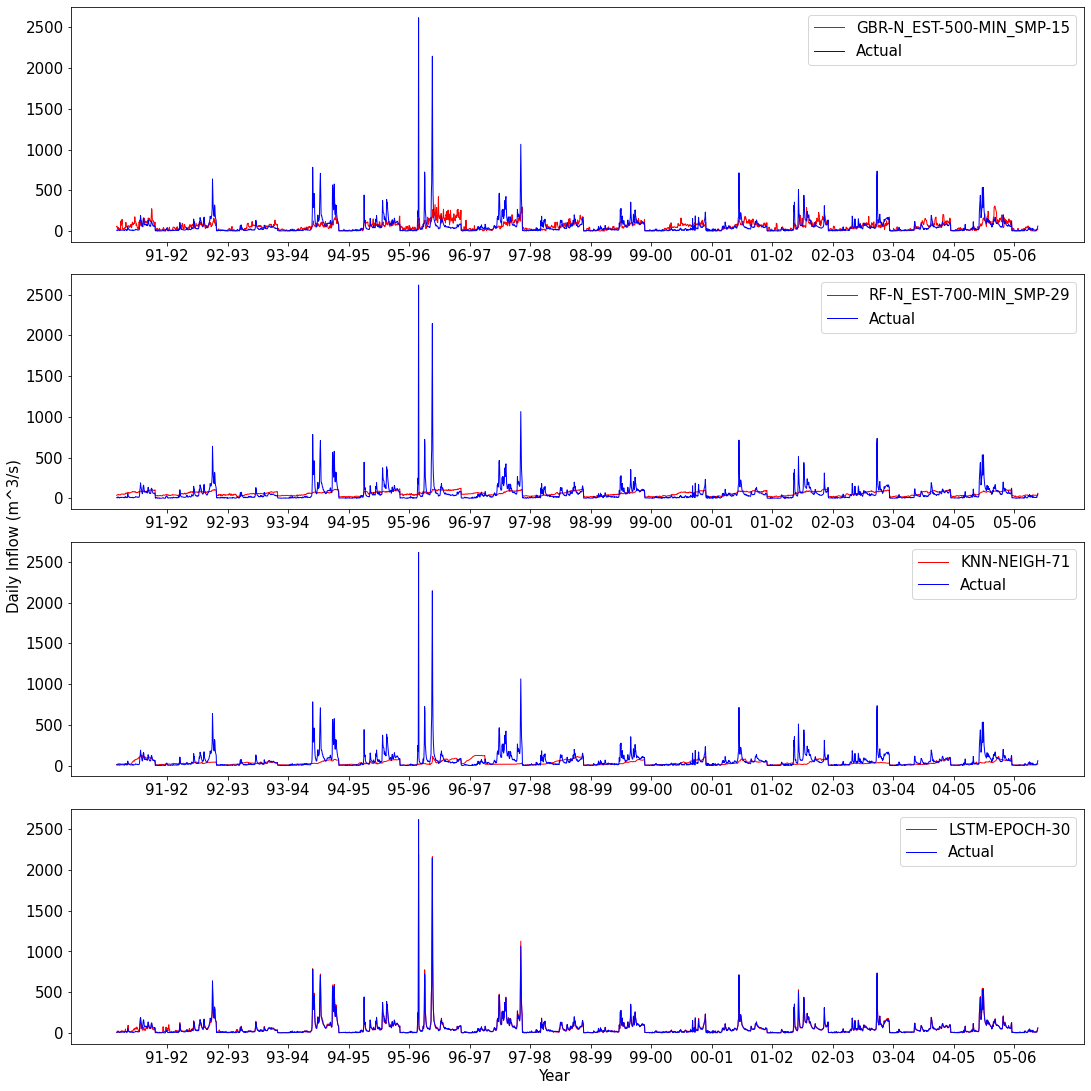

In [ ]:
fig,ax = plt.subplots(4,1,figsize=(15,15))
plt.setp(ax, xticks=np.arange(150,2730,step=180),xticklabels=['91-92','92-93','93-94','94-95','95-96','96-97','97-98','98-99','99-00','00-01','01-02','02-03','03-04','04-05','05-06'])
fig.text(0.5, 0.0, 'Year', ha='center', va='center',fontsize=15)
fig.text(0.0, 0.5, 'Daily Inflow (m^3/s)', ha='center', va='center', rotation='vertical',fontsize=15)
ax[0].plot(p_gbr_500_15,"red",label='GBR-N_EST-500-MIN_SMP-15',linewidth=1.0)
ax[0].plot(a_gbr_500_15,"blue",label='Actual',linewidth=1.0)
ax[0].legend(prop={'size': 15})
ax[0].tick_params(axis='x', labelsize= 15)
ax[0].tick_params(axis='y', labelsize= 15)
ax[1].plot(p_rf_700_29,"red",label='RF-N_EST-700-MIN_SMP-29',linewidth=1.0)
ax[1].plot(a_rf_700_29,"blue",label='Actual',linewidth=1.0)
ax[1].legend(prop={'size': 15})
ax[1].tick_params(axis='x', labelsize= 15)
ax[1].tick_params(axis='y', labelsize= 15)
ax[2].plot(p_knn_71,"red",label='KNN-NEIGH-71',linewidth=1.0)
ax[2].plot(a_knn_71,"blue",label='Actual',linewidth=1.0)
ax[2].legend(prop={'size': 15})
ax[2].tick_params(axis='x', labelsize= 15)
ax[2].tick_params(axis='y', labelsize= 15)
ax[3].plot(p_lstm_30,"red",label='LSTM-EPOCH-30',linewidth=1.0)
ax[3].plot(a_lstm_30,"blue",label='Actual',linewidth=1.0)
ax[3].legend(prop={'size': 15})
ax[3].tick_params(axis='x', labelsize= 15)
ax[3].tick_params(axis='y', labelsize= 15)
plt.tight_layout()
plt.show()

##Runoff Season

##GBR

In [ ]:
a_gbr_100_10 = []
p_gbr_100_10 = []
a_gbr_100_15 = []
p_gbr_100_15 = []
a_gbr_200_10 = []
p_gbr_200_10 = []
a_gbr_200_15 = []
p_gbr_200_15 = []
a_gbr_300_10 = []
p_gbr_300_10 = []
a_gbr_300_15 = []
p_gbr_300_15 = []
a_gbr_400_10 = []
p_gbr_400_10 = []
a_gbr_400_15 = []
p_gbr_400_15 = []
a_gbr_500_10 = []
p_gbr_500_10 = []
a_gbr_500_15 = []
p_gbr_500_15 = []

for i in range(115,5460,365):
  a_gbr_100_10.extend(list(gbr_100_10['actual'])[i:i+182])
  p_gbr_100_10.extend(list(gbr_100_10['predict'])[i:i+182])

for i in range(115,5460,365):
  a_gbr_100_15.extend(list(gbr_100_15['actual'])[i:i+182])
  p_gbr_100_15.extend(list(gbr_100_15['predict'])[i:i+182])

for i in range(115,5460,365):
  a_gbr_200_10.extend(list(gbr_200_10['actual'])[i:i+182])
  p_gbr_200_10.extend(list(gbr_200_10['predict'])[i:i+182])

for i in range(115,5460,365):
  a_gbr_200_15.extend(list(gbr_200_15['actual'])[i:i+182])
  p_gbr_200_15.extend(list(gbr_200_15['predict'])[i:i+182])

for i in range(115,5460,365):
  a_gbr_300_10.extend(list(gbr_300_10['actual'])[i:i+182])
  p_gbr_300_10.extend(list(gbr_300_10['predict'])[i:i+182])

for i in range(115,5460,365):
  a_gbr_300_15.extend(list(gbr_300_15['actual'])[i:i+182])
  p_gbr_300_15.extend(list(gbr_300_15['predict'])[i:i+182])

for i in range(115,5460,365):
  a_gbr_400_10.extend(list(gbr_400_10['actual'])[i:i+182])
  p_gbr_400_10.extend(list(gbr_400_10['predict'])[i:i+182])

for i in range(115,5460,365):
  a_gbr_400_15.extend(list(gbr_400_15['actual'])[i:i+182])
  p_gbr_400_15.extend(list(gbr_400_15['predict'])[i:i+182])

for i in range(115,5460,365):
  a_gbr_500_10.extend(list(gbr_500_10['actual'])[i:i+182])
  p_gbr_500_10.extend(list(gbr_500_10['predict'])[i:i+182])

for i in range(115,5460,365):
  a_gbr_500_15.extend(list(gbr_500_15['actual'])[i:i+182])
  p_gbr_500_15.extend(list(gbr_500_15['predict'])[i:i+182])

print(math.sqrt(mean_squared_error(a_gbr_100_10, p_gbr_100_10)))
print(math.sqrt(mean_squared_error(a_gbr_100_15, p_gbr_100_15)))
print(math.sqrt(mean_squared_error(a_gbr_200_10, p_gbr_200_10)))
print(math.sqrt(mean_squared_error(a_gbr_200_15, p_gbr_200_15)))
print(math.sqrt(mean_squared_error(a_gbr_300_10, p_gbr_300_10)))
print(math.sqrt(mean_squared_error(a_gbr_300_15, p_gbr_300_15)))
print(math.sqrt(mean_squared_error(a_gbr_400_10, p_gbr_400_10)))
print(math.sqrt(mean_squared_error(a_gbr_400_15, p_gbr_400_15)))
print(math.sqrt(mean_squared_error(a_gbr_500_10, p_gbr_500_10)))
print(math.sqrt(mean_squared_error(a_gbr_500_15, p_gbr_500_15)))

72.2151127406249
70.61534252306517
73.94125927197027
72.11651818920907
74.32349063003971
72.44982809894611
74.87031242041938
72.64812732399125
74.88580030177745
72.75010988769519


In [ ]:
gbr = pd.DataFrame({'actual':a_gbr_100_15,'predict':p_gbr_100_15})
gbr.to_csv('gbr_100_15_runoff.csv')

##KNN

In [ ]:
a_knn_55 = []
p_knn_55 = []
a_knn_57 = []
p_knn_57 = [] 
a_knn_59 = []
p_knn_59 = [] 
a_knn_61 = []
p_knn_61 = [] 
a_knn_63 = []
p_knn_63 = [] 
a_knn_65 = []
p_knn_65 = [] 
a_knn_67 = []
p_knn_67 = [] 
a_knn_69 = []
p_knn_69 = [] 
a_knn_71 = []
p_knn_71 = []

for i in range(115,5460,365):
  a_knn_55.extend(list(knn_55['actual'])[i:i+182])
  p_knn_55.extend(list(knn_55['predict'])[i:i+182])

for i in range(115,5460,365):
  a_knn_57.extend(list(knn_57['actual'])[i:i+182])
  p_knn_57.extend(list(knn_57['predict'])[i:i+182])

for i in range(115,5460,365):
  a_knn_59.extend(list(knn_59['actual'])[i:i+182])
  p_knn_59.extend(list(knn_59['predict'])[i:i+182])

for i in range(115,5460,365):
  a_knn_61.extend(list(knn_61['actual'])[i:i+182])
  p_knn_61.extend(list(knn_61['predict'])[i:i+182])

for i in range(115,5460,365):
  a_knn_63.extend(list(knn_63['actual'])[i:i+182])
  p_knn_63.extend(list(knn_63['predict'])[i:i+182])

for i in range(115,5460,365):
  a_knn_65.extend(list(knn_65['actual'])[i:i+182])
  p_knn_65.extend(list(knn_65['predict'])[i:i+182])

for i in range(115,5460,365):
  a_knn_67.extend(list(knn_67['actual'])[i:i+182])
  p_knn_67.extend(list(knn_67['predict'])[i:i+182])

for i in range(115,5460,365):
  a_knn_69.extend(list(knn_69['actual'])[i:i+182])
  p_knn_69.extend(list(knn_69['predict'])[i:i+182])

for i in range(115,5460,365):
  a_knn_71.extend(list(knn_71['actual'])[i:i+182])
  p_knn_71.extend(list(knn_71['predict'])[i:i+182])

print(math.sqrt(mean_squared_error(a_knn_55, p_knn_55)))
print(math.sqrt(mean_squared_error(a_knn_57, p_knn_57)))
print(math.sqrt(mean_squared_error(a_knn_59, p_knn_59)))
print(math.sqrt(mean_squared_error(a_knn_61, p_knn_61)))
print(math.sqrt(mean_squared_error(a_knn_63, p_knn_63)))
print(math.sqrt(mean_squared_error(a_knn_65, p_knn_65)))
print(math.sqrt(mean_squared_error(a_knn_67, p_knn_67)))
print(math.sqrt(mean_squared_error(a_knn_69, p_knn_69)))
print(math.sqrt(mean_squared_error(a_knn_71, p_knn_71)))

79.91813436348477
80.04746569655782
80.1653062000707
80.27598312024735
80.38539677124383
80.46611749117011
80.47664872648633
80.6081165223471
80.74024431816721


In [ ]:
knn = pd.DataFrame({'actual':a_knn_55,'predict':p_knn_55})
knn.to_csv('knn_55_runoff.csv')

##RF

In [ ]:
a_rf_500_29 = []
p_rf_500_29 = []
a_rf_500_31 = []
p_rf_500_31 = []
a_rf_600_29 = []
p_rf_600_29 = []
a_rf_600_31 = []
p_rf_600_31 = []
a_rf_700_29 = []
p_rf_700_29 = []
a_rf_700_31 = []
p_rf_700_31 = []
a_rf_800_29 = []
p_rf_800_29 = []
a_rf_800_31 = []
p_rf_800_31 = []
a_rf_900_29 = []
p_rf_900_29 = []
a_rf_900_31 = []
p_rf_900_31 = []
a_rf_1000_29 = []
p_rf_1000_29 = []
a_rf_1000_31 = []
p_rf_1000_31 = []

for i in range(115,5460,365):
  a_rf_500_29.extend(list(rf_500_29['actual'])[i:i+182])
  p_rf_500_29.extend(list(rf_500_29['predict'])[i:i+182])

for i in range(115,5460,365):
  a_rf_500_31.extend(list(rf_500_31['actual'])[i:i+182])
  p_rf_500_31.extend(list(rf_500_31['predict'])[i:i+182])


for i in range(115,5460,365):
  a_rf_600_29.extend(list(rf_600_29['actual'])[i:i+182])
  p_rf_600_29.extend(list(rf_600_29['predict'])[i:i+182])


for i in range(115,5460,365):
  a_rf_600_31.extend(list(rf_600_31['actual'])[i:i+182])
  p_rf_600_31.extend(list(rf_600_31['predict'])[i:i+182])


for i in range(115,5460,365):
  a_rf_700_29.extend(list(rf_700_29['actual'])[i:i+182])
  p_rf_700_29.extend(list(rf_700_29['predict'])[i:i+182])


for i in range(115,5460,365):
  a_rf_700_31.extend(list(rf_700_31['actual'])[i:i+182])
  p_rf_700_31.extend(list(rf_700_31['predict'])[i:i+182])

for i in range(115,5460,365):
  a_rf_800_29.extend(list(rf_800_29['actual'])[i:i+182])
  p_rf_800_29.extend(list(rf_800_29['predict'])[i:i+182])

for i in range(115,5460,365):
  a_rf_800_31.extend(list(rf_800_31['actual'])[i:i+182])
  p_rf_800_31.extend(list(rf_800_31['predict'])[i:i+182])

for i in range(115,5460,365):
  a_rf_900_29.extend(list(rf_900_29['actual'])[i:i+182])
  p_rf_900_29.extend(list(rf_900_29['predict'])[i:i+182])

for i in range(115,5460,365):
  a_rf_900_31.extend(list(rf_900_31['actual'])[i:i+182])
  p_rf_900_31.extend(list(rf_900_31['predict'])[i:i+182])

for i in range(115,5460,365):
  a_rf_1000_29.extend(list(rf_1000_29['actual'])[i:i+182])
  p_rf_1000_29.extend(list(rf_1000_29['predict'])[i:i+182])

for i in range(115,5460,365):
  a_rf_1000_31.extend(list(rf_1000_31['actual'])[i:i+182])
  p_rf_1000_31.extend(list(rf_1000_31['predict'])[i:i+182])

print(math.sqrt(mean_squared_error(a_rf_500_29, p_rf_500_29)))
print(math.sqrt(mean_squared_error(a_rf_500_31, p_rf_500_31)))
print(math.sqrt(mean_squared_error(a_rf_600_29, p_rf_600_29)))
print(math.sqrt(mean_squared_error(a_rf_600_31, p_rf_600_31)))
print(math.sqrt(mean_squared_error(a_rf_700_29, p_rf_700_29)))
print(math.sqrt(mean_squared_error(a_rf_700_31, p_rf_700_31)))
print(math.sqrt(mean_squared_error(a_rf_800_29, p_rf_800_29)))
print(math.sqrt(mean_squared_error(a_rf_800_31, p_rf_800_31)))
print(math.sqrt(mean_squared_error(a_rf_900_29, p_rf_900_29)))
print(math.sqrt(mean_squared_error(a_rf_900_31, p_rf_900_31)))
print(math.sqrt(mean_squared_error(a_rf_1000_29, p_rf_1000_29)))
print(math.sqrt(mean_squared_error(a_rf_1000_31, p_rf_1000_31)))

72.16376307526598
72.2548103790503
72.22329159150723
72.44653074526751
72.19510440920475
72.07473320014502
72.13989712845698
72.17786548082643
72.15169970679021
72.2800137166486
72.1852395976081
72.3412660636878


In [ ]:
rf = pd.DataFrame({'actual':a_rf_700_29,'predict':p_rf_700_29})
rf.to_csv('rf_700_29_runoff.csv')

##LSTM

In [ ]:
a_lstm_30 = []
p_lstm_30 = []
a_lstm_40 = []
p_lstm_40 = []
a_lstm_50 = []
p_lstm_50 = []
a_lstm_60 = []
p_lstm_60 = []
a_lstm_70 = []
p_lstm_70 = []
a_lstm_80 = []
p_lstm_80 = []
a_lstm_90 = []
p_lstm_90 = []
a_lstm_100 = []
p_lstm_100 = []

for i in range(115,5460,365):
  a_lstm_30.extend(list(lstm_30['actual'])[i:i+182])
  p_lstm_30.extend(list(lstm_30['predict'])[i:i+182])

for i in range(115,5460,365):
  a_lstm_40.extend(list(lstm_40['actual'])[i:i+182])
  p_lstm_40.extend(list(lstm_40['predict'])[i:i+182])

for i in range(115,5460,365):
  a_lstm_50.extend(list(lstm_50['actual'])[i:i+182])
  p_lstm_50.extend(list(lstm_50['predict'])[i:i+182])

for i in range(115,5460,365):
  a_lstm_60.extend(list(lstm_60['actual'])[i:i+182])
  p_lstm_60.extend(list(lstm_60['predict'])[i:i+182])

for i in range(115,5460,365):
  a_lstm_70.extend(list(lstm_70['actual'])[i:i+182])
  p_lstm_70.extend(list(lstm_70['predict'])[i:i+182])

for i in range(115,5460,365):
  a_lstm_80.extend(list(lstm_80['actual'])[i:i+182])
  p_lstm_80.extend(list(lstm_80['predict'])[i:i+182])

for i in range(115,5460,365):
  a_lstm_90.extend(list(lstm_90['actual'])[i:i+182])
  p_lstm_90.extend(list(lstm_90['predict'])[i:i+182])

for i in range(115,5460,365):
  a_lstm_100.extend(list(lstm_100['actual'])[i:i+182])
  p_lstm_100.extend(list(lstm_100['predict'])[i:i+182])

print(math.sqrt(mean_squared_error(a_lstm_30, p_lstm_30)))
print(math.sqrt(mean_squared_error(a_lstm_40, p_lstm_40)))
print(math.sqrt(mean_squared_error(a_lstm_50, p_lstm_50)))
print(math.sqrt(mean_squared_error(a_lstm_60, p_lstm_60)))
print(math.sqrt(mean_squared_error(a_lstm_70, p_lstm_70)))
print(math.sqrt(mean_squared_error(a_lstm_80, p_lstm_80)))
print(math.sqrt(mean_squared_error(a_lstm_90, p_lstm_90)))
print(math.sqrt(mean_squared_error(a_lstm_100, p_lstm_100)))

15.729338021790818
18.474001343479046
19.965991890268278
13.962196999688928
17.29694773886694
15.017859666008443
15.580510785146194
21.300751631299228


In [ ]:
lstm = pd.DataFrame({'actual':a_lstm_60,'predict':p_lstm_60})
lstm.to_csv('lstm_60_runoff.csv')

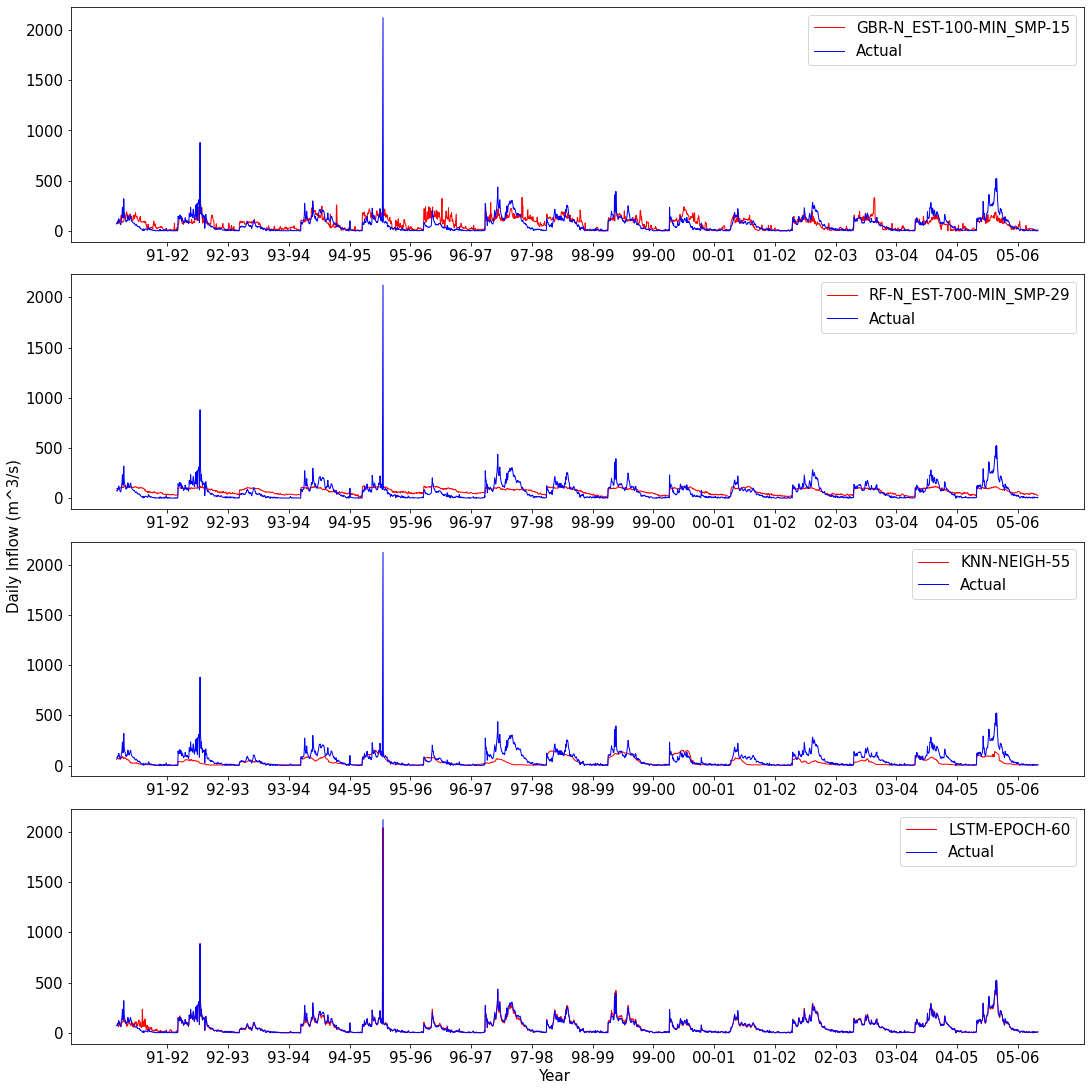

In [ ]:
fig,ax = plt.subplots(4,1,figsize=(15,15))
plt.setp(ax, xticks=np.arange(150,2730,step=180),xticklabels=['91-92','92-93','93-94','94-95','95-96','96-97','97-98','98-99','99-00','00-01','01-02','02-03','03-04','04-05','05-06'])
fig.text(0.5, 0.0, 'Year', ha='center', va='center',fontsize=15)
fig.text(0.0, 0.5, 'Daily Inflow (m^3/s)', ha='center', va='center', rotation='vertical',fontsize=15)
ax[0].plot(p_gbr_100_15,"red",label='GBR-N_EST-100-MIN_SMP-15',linewidth=1.0)
ax[0].plot(a_gbr_100_15,"blue",label='Actual',linewidth=1.0)
ax[0].legend(prop={'size': 15})
ax[0].tick_params(axis='x', labelsize= 15)
ax[0].tick_params(axis='y', labelsize= 15)
ax[1].plot(p_rf_700_29,"red",label='RF-N_EST-700-MIN_SMP-29',linewidth=1.0)
ax[1].plot(a_rf_700_29,"blue",label='Actual',linewidth=1.0)
ax[1].legend(prop={'size': 15})
ax[1].tick_params(axis='x', labelsize= 15)
ax[1].tick_params(axis='y', labelsize= 15)
ax[2].plot(p_knn_55,"red",label='KNN-NEIGH-55',linewidth=1.0)
ax[2].plot(a_knn_55,"blue",label='Actual',linewidth=1.0)
ax[2].legend(prop={'size': 15})
ax[2].tick_params(axis='x', labelsize= 15)
ax[2].tick_params(axis='y', labelsize= 15)
ax[3].plot(p_lstm_60,"red",label='LSTM-EPOCH-60',linewidth=1.0)
ax[3].plot(a_lstm_60,"blue",label='Actual',linewidth=1.0)
ax[3].legend(prop={'size': 15})
ax[3].tick_params(axis='x', labelsize= 15)
ax[3].tick_params(axis='y', labelsize= 15)
plt.tight_layout()
plt.show()